<a href="https://colab.research.google.com/github/giusi07/Debates-Agreement-vs-Disagreement/blob/main/Debates_agreement_or_disagreement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import scipy.stats as ss
import random as python_random
import matplotlib.pyplot as plt
from random import shuffle

import io
import string
import re
import nltk
import pickle
import dill as pickle

from pprint import pprint
from time import time
from sklearn import utils
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, make_scorer, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [23]:
%load_ext google.colab.data_table

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Import data

In [3]:
from google.colab import files
uploaded= files.upload()

Saving debatepedia_agreement_dataset.tsv to debatepedia_agreement_dataset.tsv


In [4]:
data = pd.read_csv(io.StringIO(uploaded['debatepedia_agreement_dataset.tsv'].decode('utf-8')), sep= '\t',error_bad_lines= False, names=["id", "agreement","topic", "debateReason", "debateQuestion", "position1", "position2"])

In [5]:
print(data.shape)
data.head(5)

(29343, 7)


id  ...                                          position2
0   1  ...  $700 bailout wrongly trusts culprits to solve ...
1   2  ...  $700 billion bailout plan is too little too la...
2   3  ...  $700b bailout would increase US deficit and in...
3   4  ...  No assurances that a $700b bailout would work ...
4   5  ...  $700 bailout wrongly trusts culprits to solve ...

[5 rows x 7 columns]

# **Exploratory Data Analysis**

In [ ]:
data.isnull().sum()

id                 0
agreement          0
topic              0
debateReason       0
debateQuestion    97
position1          0
position2          2
dtype: int64

In [6]:
data.dropna(inplace=True)
data.isnull().sum()

id                0
agreement         0
topic             0
debateReason      0
debateQuestion    0
position1         0
position2         0
dtype: int64

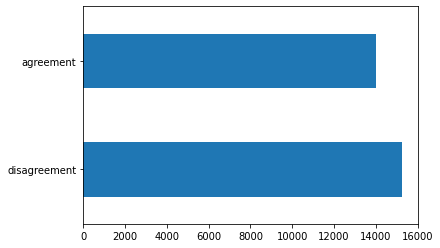

In [ ]:
data.agreement.value_counts().plot.barh()
plt.show()

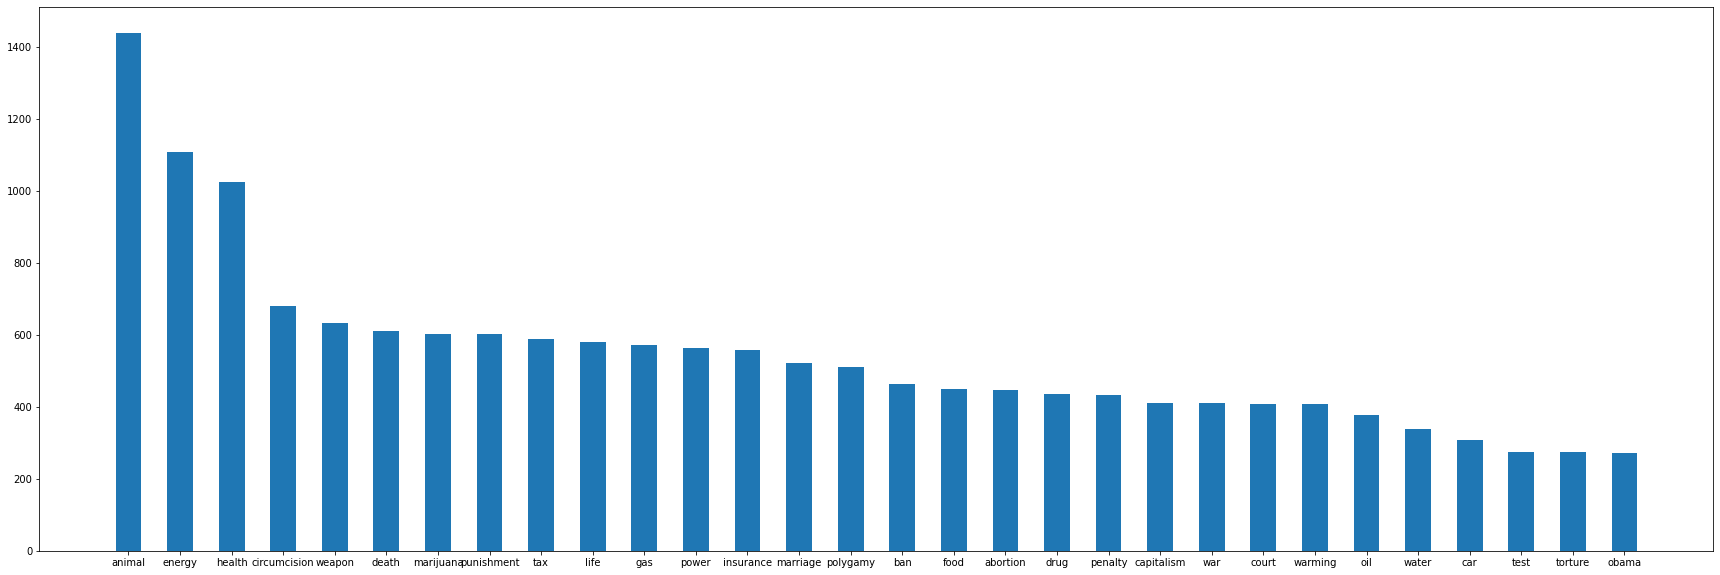

In [6]:
topics = data['topic'].value_counts().index
counts = data['topic'].value_counts().values
plt.figure(figsize=(30,10))
plt.bar(topics[:30], counts[:30], width=0.5)
toptentopics= data['topic'].value_counts(ascending= False).index.tolist()[:10] 

In [ ]:
data['agreement'].value_counts()

disagreement    15259
agreement       13985
Name: agreement, dtype: int64

In [ ]:
data['agreement'].unique()

array(['disagreement', 'agreement'], dtype=object)

In [ ]:
questions= data['debateQuestion'].unique()

In [ ]:
for i in range(0, len(questions)):
  print(f'question {i} -> {questions[i]}')

question 0 -> Economics: Is the $700b "bailout" economically sound/necessary?
question 1 -> Immediacy: Is/was the passage of a $700b bill urgent?
question 2 -> Intervention: Can government intervention help? Or is it generally a bad idea?
question 3 -> Wallstreet: Will a $700 bailout go toward benefiting greedy capitalists?
question 4 -> Taxpayers: Will the $700 billion bailout help or hurt taxpayers?
question 5 -> Public opinion: Does public opinion favor or oppose the bailout? Does it matter?
question 6 -> Government stimulus: Is the government generally capable of stimulating the economy?
question 7 -> Consequences: What are the consequence of no stimulus?
question 8 -> Debt: Is adding to debt to stimulate the economy justified?
question 9 -> Public opinion: Where does public opinion stand?
question 10 -> Size: Is the size of the stimulus package appropriate?
question 11 -> Growing government: Does US stimulus right/wrongly grow government?
question 12 -> Immediate stimulus: Does th

# **Text preprocessing**

### Clean text <br>
- Remove contractions <br>
- Remove to lowercase <br>
- Remove digits <br>
- Remove punctuation <br>
- Remove extraspaces 

In [7]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will", "bankruptcieslayoffs": "bankruptcies or layoffs",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

cols= ['position1', 'position2']
for col in cols:
  data[f'{col}_cleaned']=data[col].apply(lambda x:expand_contractions(str(x)))  #remove contractions
  data[f'{col}_cleaned']=data[f'{col}_cleaned'].apply(lambda x: str(x).lower()) # reduce to lowercase
  data[f'{col}_cleaned']=data[f'{col}_cleaned'].apply(lambda x: re.sub('\w*\d\w*','', str(x))) #remove digits
  data[f'{col}_cleaned']=data[f'{col}_cleaned'].apply(lambda x: re.sub('[/]',' ', str(x))) 
  data[f'{col}_cleaned']=data[f'{col}_cleaned'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', str(x))) #remove punctuation
  data[f'{col}_cleaned']=data[f'{col}_cleaned'].apply(lambda x: re.sub(' +',' ', str(x))) #remove extra spaces

# Create Datasets 
Create one dataset with postion 1 and position 2 separated and one with the two positions merged together

In [8]:
data_separated= data.copy()
data_merged = data.copy()

### Stop-words removal

In [9]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))


data_separated['position1_cleaned']=data_separated['position1_cleaned'].apply(lambda x: [w for w in word_tokenize(str(x)) if not w in stop_words])
data_separated['position2_cleaned']=data_separated['position2_cleaned'].apply(lambda x: [w for w in word_tokenize(str(x)) if not w in stop_words])

data_merged['position1_cleaned']=data_merged['position1_cleaned'].apply(lambda x: [w for w in word_tokenize(str(x)) if not w in stop_words])
data_merged['position2_cleaned']=data_merged['position2_cleaned'].apply(lambda x: [w for w in word_tokenize(str(x)) if not w in stop_words])

In [10]:
data_merged['position1_cleaned'].apply(lambda x: x.insert(0, 'SP1'))
data_merged['position1_cleaned'].apply(lambda x: x.append('EP1'))
data_merged['position2_cleaned'].apply(lambda x: x.insert(0, 'SP2'))
data_merged['position2_cleaned'].apply(lambda x: x.append('EP2'))

0        None
1        None
2        None
3        None
4        None
         ... 
29338    None
29339    None
29340    None
29341    None
29342    None
Name: position2_cleaned, Length: 29244, dtype: object

### Drop unnecessary columns

In [11]:
data_separated.drop(columns=['debateReason', 'debateQuestion', 'id', 'position1', 'position2'], inplace= True) #drop unnecessary columns
data_merged.drop(columns=['debateReason', 'debateQuestion', 'id', 'position1', 'position2'], inplace= True)

In [12]:
data_separated['position1_cleaned']= data_separated['position1_cleaned'].apply(lambda x: ' '.join(x).strip())
data_separated['position2_cleaned']= data_separated['position2_cleaned'].apply(lambda x: ' '.join(x).strip())
data_separated.head()

agreement  ...                                  position2_cleaned
0  disagreement  ...  bailout wrongly trusts culprits solve crisis n...
1  disagreement  ...  billion bailout plan little late proposed bill...
2  disagreement  ...  bailout would increase us deficit interest rat...
3  disagreement  ...  assurances bailout would work sen richard c sh...
4  disagreement  ...  bailout wrongly trusts culprits solve crisis n...

[5 rows x 4 columns]

In [13]:
data_merged['debate']= data_merged['position1_cleaned'] + data_merged['position2_cleaned']
data_merged['debate']= data_merged['debate'].apply(lambda x: ' '.join(x).strip())
data_merged.drop(columns=['position1_cleaned', 'position2_cleaned'], inplace=True)
data_merged.head()
#data_merged.loc[0]['debate']

agreement    topic                                             debate
0  disagreement  bailout  SP1 bailout helps avoid widespread bankruptcie...
1  disagreement  bailout  SP1 bailout helps avoid widespread bankruptcie...
2  disagreement  bailout  SP1 bailout helps avoid widespread bankruptcie...
3  disagreement  bailout  SP1 bailout helps avoid widespread bankruptcie...
4  disagreement  bailout  SP1 bailout generally well designed solve us e...

### Words Specificity 
In this section I look at which are the words most specific to each one of the two classes, to do so I extract the words with highest tf-idf score and for visualization purposes I use a word cloud to plot them 

In [120]:
corpus_dis= data_merged.loc[data_merged['agreement'] == 'disagreement']
corpus_agr= data_merged.loc[data_merged['agreement'] == 'agreement']

In [122]:
def wordcloud(words_list):
  shuffle(words_list)
  unique_string=(" ").join(words_list)
  wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
  plt.figure(figsize=(15,8))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()
  plt.close()

Disagreement

In [123]:
vectorizer_dis = TfidfVectorizer()
X_dis = vectorizer_dis.fit_transform(corpus_dis['debate'])
tfidf_dic_dis = dict(zip(vectorizer_dis.get_feature_names(), X_dis.toarray()[0]))
tfidf_words_dis= {k for k, v in tfidf_dic_dis.items() if v> 0.1}
words_dis= list(tfidf_words_dis)

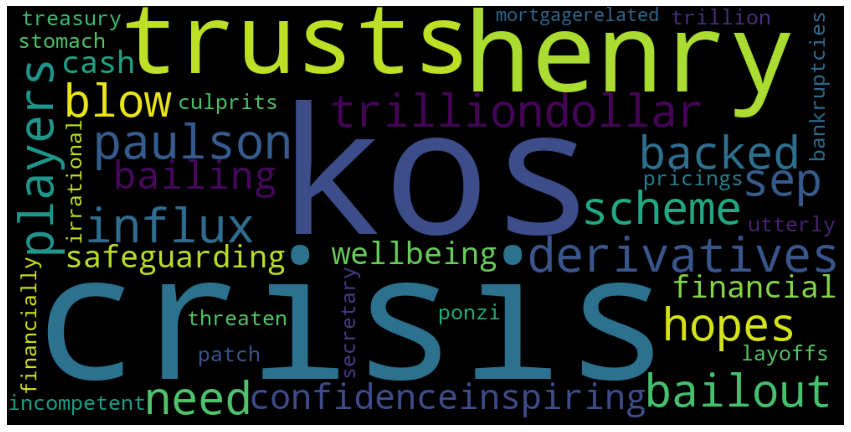

In [132]:
wordcloud(words_dis)

Agreement

In [125]:
vectorizer_agr = TfidfVectorizer()
X_agr = vectorizer_agr.fit_transform(corpus_agr['debate'])
tfidf_dic_agr = dict(zip(vectorizer_agr.get_feature_names(), X_agr.toarray()[0]))
tfidf_words_agr= {k for k, v in tfidf_dic_agr.items() if v> 0.1}
words_agr= list(tfidf_words_agr)

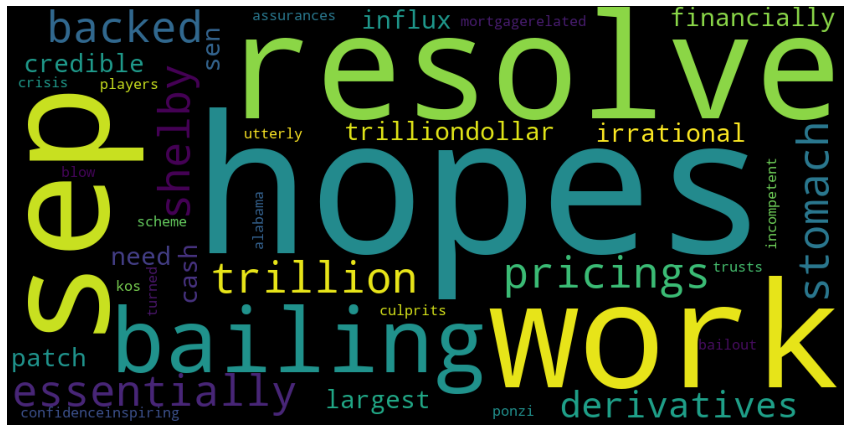

In [131]:
wordcloud(words_agr)

# Models without polarity score

## Models with complete Debate
In this section the debate is considered fully, by taking the two positions joined together instead of keeping them separated. Therefore, for the 10 most discussed topics we create a specific classification model considering the entire debate  

In [14]:
def dummy(text):
    return text

def tokenizer(text):
  return word_tokenize(text)

In [15]:
def gridsearch(pipeline, parameters, X_train, y_train):
  if __name__ == "__main__":
    
    
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring= 'f1_weighted')

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters: \n")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
    print("Executed in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
    return grid_search

In [16]:
def modelevaluation(model, X_test, y_test):
  
  y_pred = model.predict(X_test)
    
  print("Test Classification Report")
  print(classification_report(y_test, y_pred))
  print("Balanced test accuracy: ", round(balanced_accuracy_score(y_test, y_pred),3))


In [17]:
toptentopics= data['topic'].value_counts(ascending= False).index.tolist()[:10]
ngramranges= [(1,1), (1,2), (1,3), (1,4)]

In [18]:
def confusionMatrix(model=None, modelname=None, X_test=None, y_test=None, y_true=None, y_pred=None):
  normalize=['true', None]

  for n in normalize:
    plot_confusion_matrix(model, X_test, y_test, display_labels= labelEncoder.classes_,
                                 cmap=plt.cm.Blues, normalize= n)
    if n== 'true':
      plt.text(-1,-1, s= modelname + " - Test Confusion Matrix with Normalization")
    else:
      plt.text(-1,-1, s= modelname +  " - Test Confusion Matrix without Normalization")
    plt.show()


In [19]:
def save_model(modelname= 'SVC', topic= None, ngramrange= None, model= None, separated = None):
  if separated:
    filename = f'{modelname}_finalized_model_{topic}_{ngramrange}_separated.sav'
  else:
    filename = f'{modelname}_finalized_model_{topic}_{ngramrange}_merged.sav'
  pickle.dump(model, open(filename, 'wb'))

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 89.014s

Best score: 0.759
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       150
           1       0.71      0.80      0.75       138

    accuracy                           0.75       288
   macro avg       0.75      0.75      0.75       288
weighted avg       0.75      0.75      0.75       288

Balanced test accuracy:  0.752


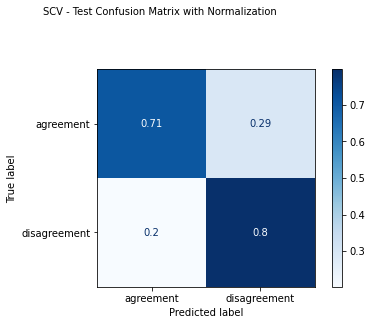

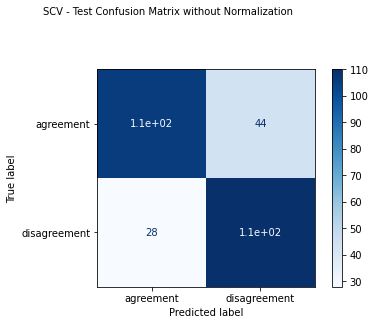

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 119.083s

Best score: 0.878
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       150
           1       0.84      0.93      0.88       138

    accuracy                           0.88       288
   macro avg       0.89      0.88      0.88       288
weighted avg       0.89      0.88      0.88       288

Balanced test accuracy:  0.884


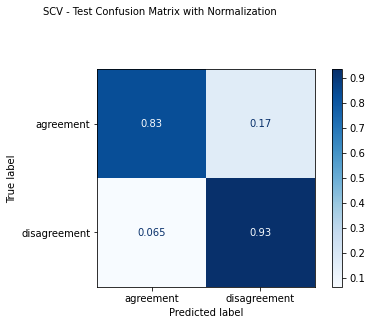

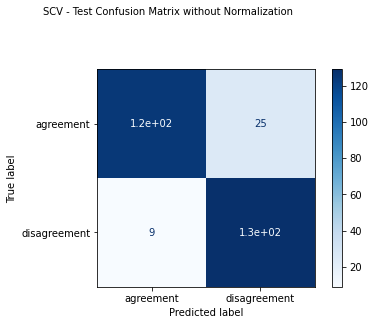

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 141.440s

Best score: 0.902
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       150
           1       0.87      0.95      0.91       138

    accuracy                           0.91       288
   macro avg       0.91      0.91      0.91       288
weighted avg       0.91      0.91      0.91       288

Balanced test accuracy:  0.908


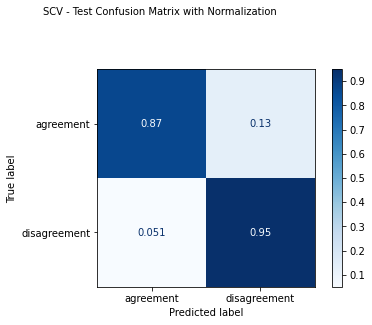

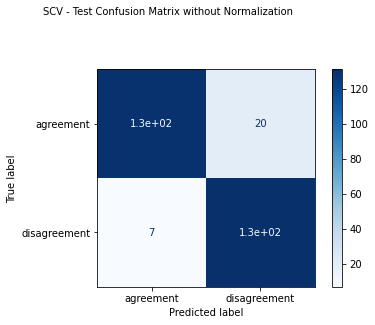

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 162.912s

Best score: 0.898
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       150
           1       0.86      0.95      0.90       138

    accuracy                           0.90       288
   macro avg       0.91      0.90      0.90       288
weighted avg       0.91      0.90      0.90       288

Balanced test accuracy:  0.905


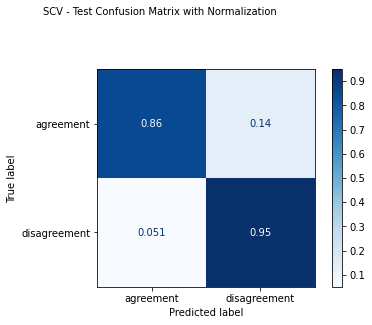

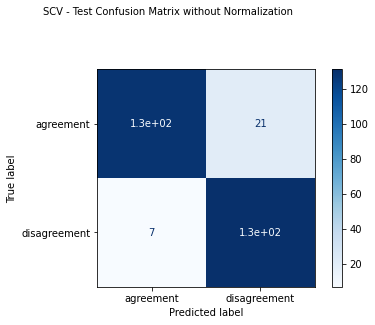

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 80.615s

Best score: 0.602
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        90
           1       0.74      0.80      0.77       132

    accuracy                           0.72       222
   macro avg       0.71      0.70      0.70       222
weighted avg       0.71      0.72      0.71       222

Balanced test accuracy:  0.698


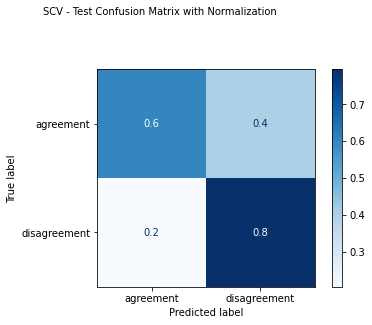

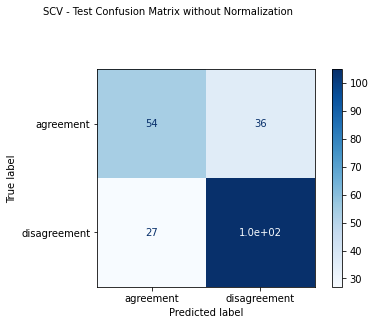

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 109.751s

Best score: 0.682
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.76      0.71      0.74        90
           1       0.81      0.85      0.83       132

    accuracy                           0.79       222
   macro avg       0.79      0.78      0.78       222
weighted avg       0.79      0.79      0.79       222

Balanced test accuracy:  0.78


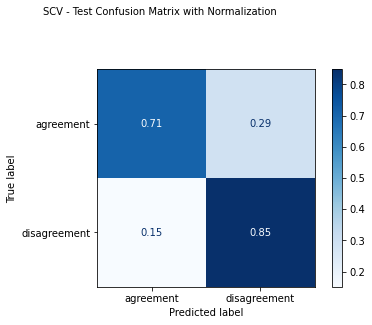

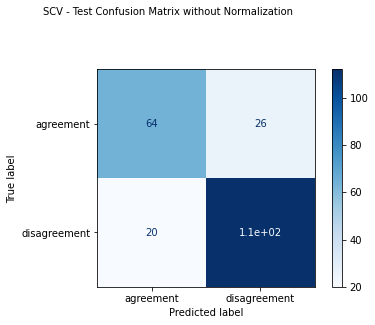

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 134.577s

Best score: 0.733
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.75      0.74      0.75        90
           1       0.83      0.83      0.83       132

    accuracy                           0.80       222
   macro avg       0.79      0.79      0.79       222
weighted avg       0.80      0.80      0.80       222

Balanced test accuracy:  0.789


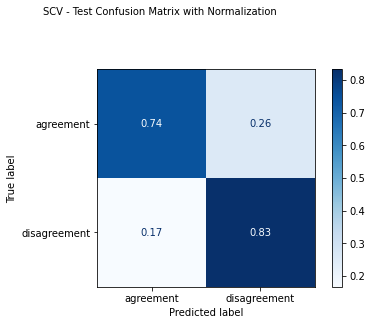

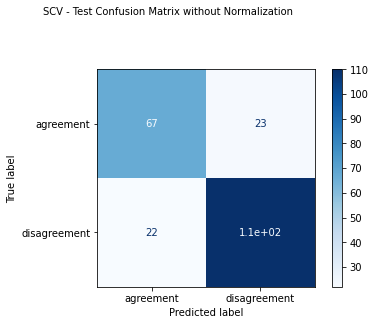

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 155.076s

Best score: 0.746
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        90
           1       0.82      0.82      0.82       132

    accuracy                           0.78       222
   macro avg       0.78      0.78      0.78       222
weighted avg       0.78      0.78      0.78       222

Balanced test accuracy:  0.776


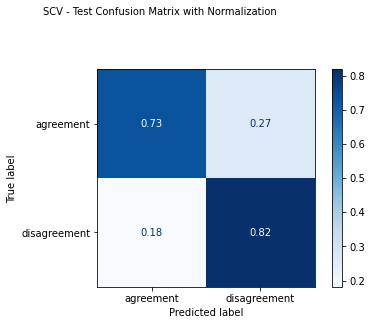

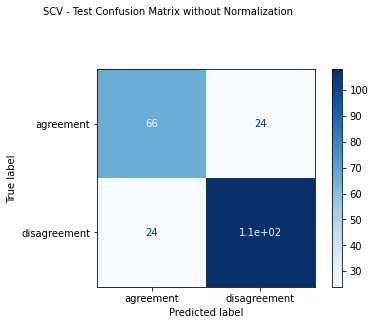

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 74.332s

Best score: 0.639
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.66      0.63      0.64        91
           1       0.71      0.75      0.73       114

    accuracy                           0.69       205
   macro avg       0.69      0.69      0.69       205
weighted avg       0.69      0.69      0.69       205

Balanced test accuracy:  0.686


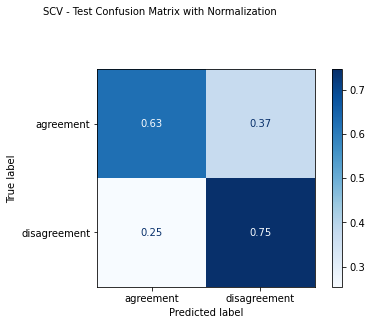

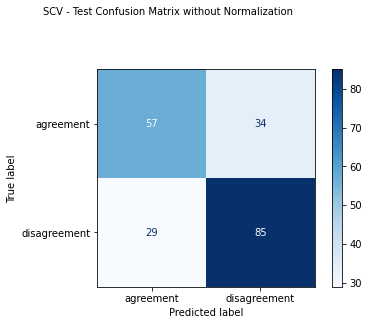

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 102.700s

Best score: 0.714
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        91
           1       0.84      0.89      0.86       114

    accuracy                           0.84       205
   macro avg       0.84      0.84      0.84       205
weighted avg       0.84      0.84      0.84       205

Balanced test accuracy:  0.839


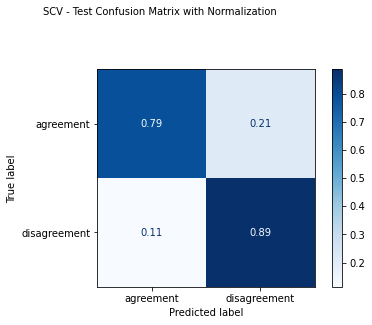

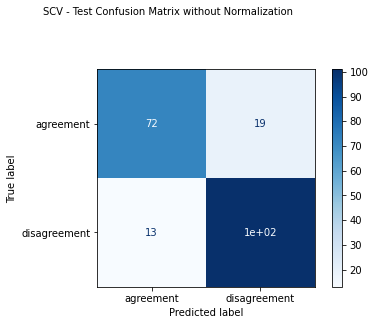

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 125.092s

Best score: 0.742
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        91
           1       0.87      0.91      0.89       114

    accuracy                           0.88       205
   macro avg       0.88      0.87      0.88       205
weighted avg       0.88      0.88      0.88       205

Balanced test accuracy:  0.874


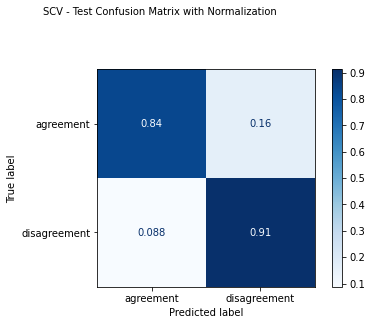

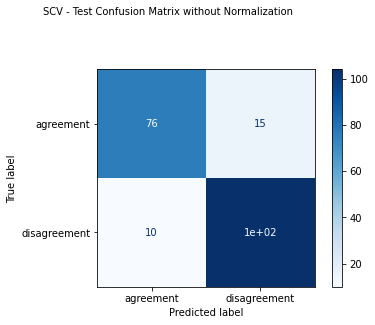

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 145.130s

Best score: 0.749
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        91
           1       0.88      0.91      0.90       114

    accuracy                           0.88       205
   macro avg       0.88      0.88      0.88       205
weighted avg       0.88      0.88      0.88       205

Balanced test accuracy:  0.879


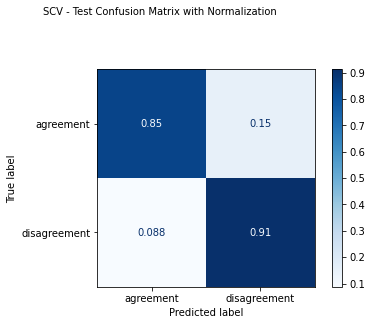

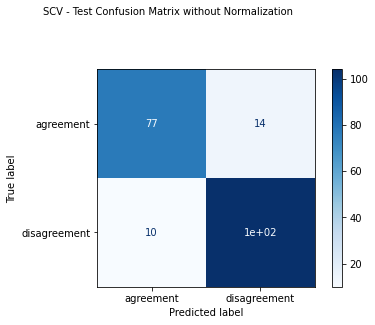

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 35.633s

Best score: 0.864
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.79      0.86        52
           1       0.88      0.98      0.93        85

    accuracy                           0.91       137
   macro avg       0.92      0.88      0.90       137
weighted avg       0.91      0.91      0.90       137

Balanced test accuracy:  0.882


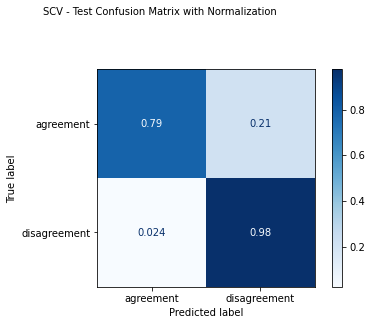

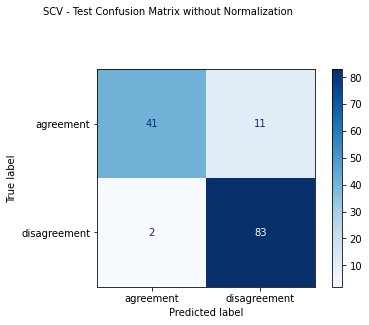

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 45.625s

Best score: 0.949
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        52
           1       0.98      0.98      0.98        85

    accuracy                           0.97       137
   macro avg       0.97      0.97      0.97       137
weighted avg       0.97      0.97      0.97       137

Balanced test accuracy:  0.969


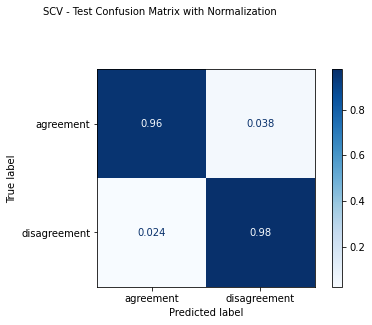

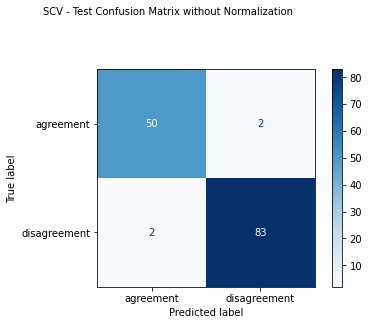

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 53.066s

Best score: 0.960
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        52
           1       0.98      0.98      0.98        85

    accuracy                           0.97       137
   macro avg       0.97      0.97      0.97       137
weighted avg       0.97      0.97      0.97       137

Balanced test accuracy:  0.969


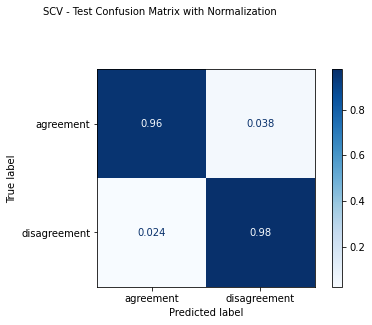

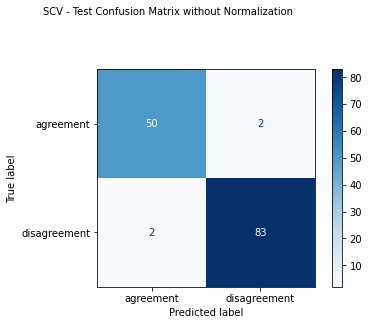

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 59.700s

Best score: 0.960
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        52
           1       0.99      0.95      0.97        85

    accuracy                           0.96       137
   macro avg       0.96      0.97      0.96       137
weighted avg       0.96      0.96      0.96       137

Balanced test accuracy:  0.967


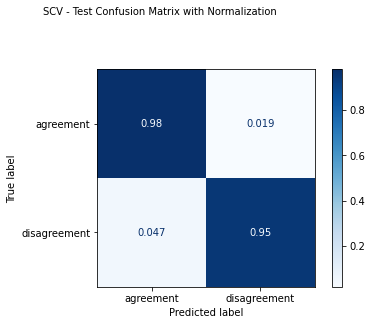

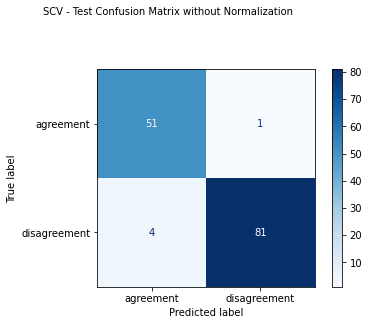

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 34.652s

Best score: 0.719
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        58
           1       0.74      0.93      0.82        69

    accuracy                           0.78       127
   macro avg       0.81      0.77      0.77       127
weighted avg       0.80      0.78      0.77       127

Balanced test accuracy:  0.765


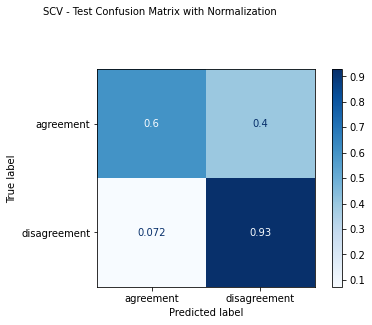

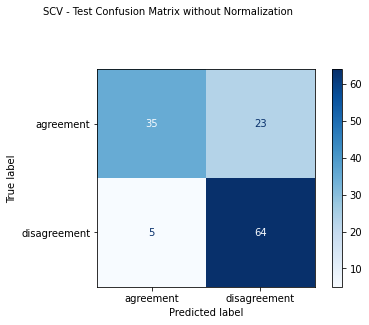

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 45.984s

Best score: 0.864
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        58
           1       0.86      0.94      0.90        69

    accuracy                           0.88       127
   macro avg       0.89      0.88      0.88       127
weighted avg       0.89      0.88      0.88       127

Balanced test accuracy:  0.876


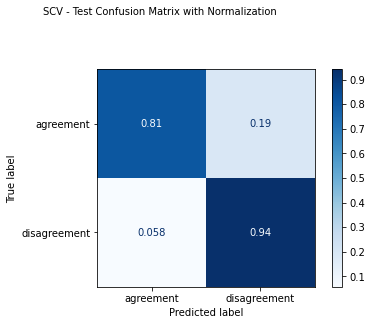

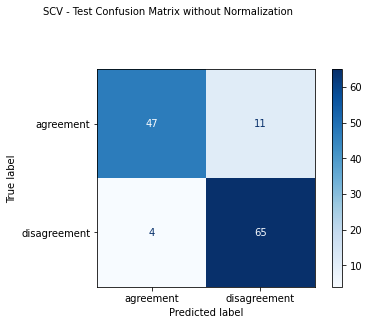

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 54.795s

Best score: 0.870
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.84      0.91        58
           1       0.88      0.99      0.93        69

    accuracy                           0.92       127
   macro avg       0.93      0.92      0.92       127
weighted avg       0.93      0.92      0.92       127

Balanced test accuracy:  0.915


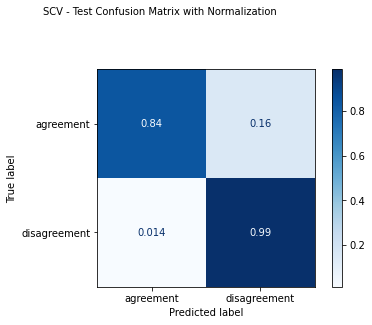

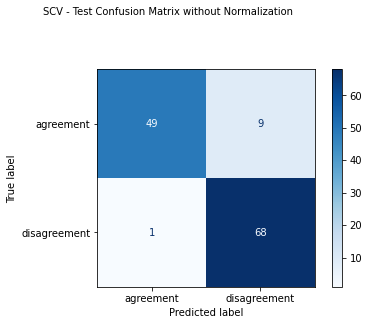

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 63.542s

Best score: 0.860
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.84      0.91        58
           1       0.88      0.99      0.93        69

    accuracy                           0.92       127
   macro avg       0.93      0.92      0.92       127
weighted avg       0.93      0.92      0.92       127

Balanced test accuracy:  0.915


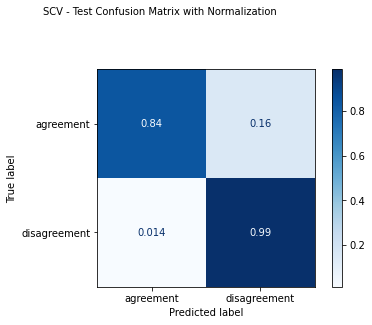

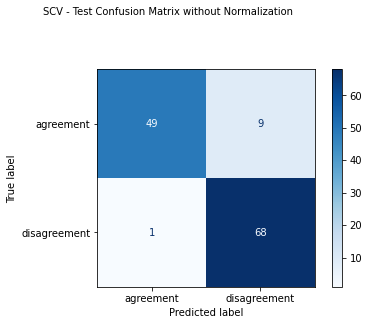

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 34.862s

Best score: 0.590
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.56      0.54      0.55        52
           1       0.67      0.69      0.68        71

    accuracy                           0.63       123
   macro avg       0.62      0.61      0.61       123
weighted avg       0.62      0.63      0.62       123

Balanced test accuracy:  0.614


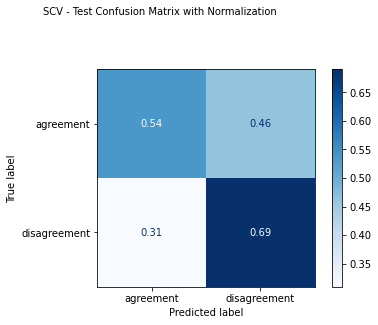

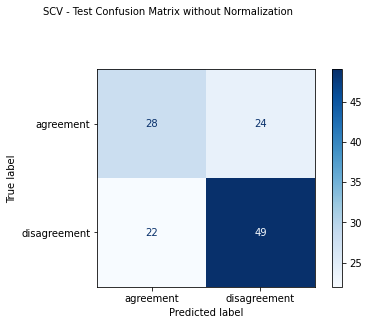

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 46.034s

Best score: 0.858
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        52
           1       0.88      0.94      0.91        71

    accuracy                           0.89       123
   macro avg       0.90      0.89      0.89       123
weighted avg       0.90      0.89      0.89       123

Balanced test accuracy:  0.885


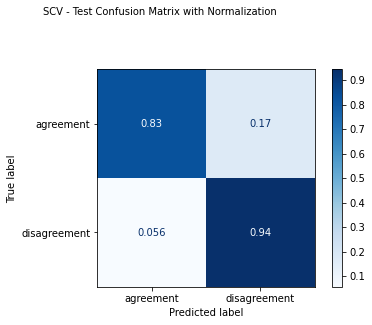

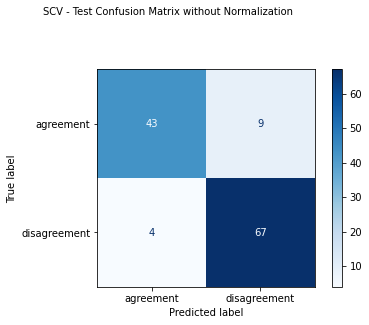

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 54.423s

Best score: 0.873
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.88      0.83      0.85        52
           1       0.88      0.92      0.90        71

    accuracy                           0.88       123
   macro avg       0.88      0.87      0.87       123
weighted avg       0.88      0.88      0.88       123

Balanced test accuracy:  0.871


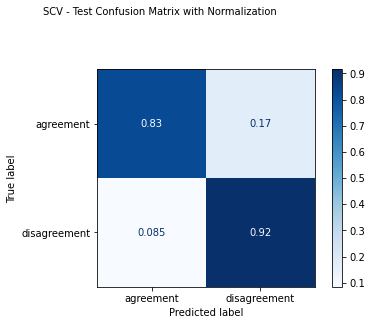

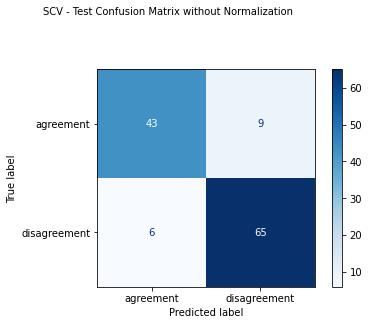

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 63.133s

Best score: 0.867
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        52
           1       0.88      0.93      0.90        71

    accuracy                           0.89       123
   macro avg       0.89      0.88      0.88       123
weighted avg       0.89      0.89      0.89       123

Balanced test accuracy:  0.878


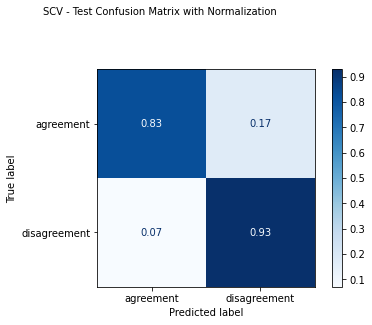

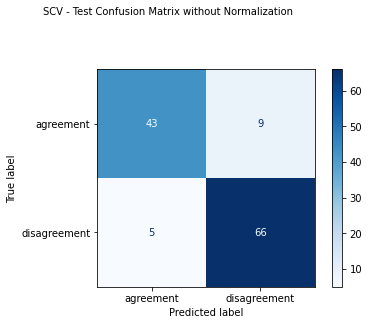

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 32.658s

Best score: 0.628
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.73      0.55      0.62        55
           1       0.69      0.83      0.75        66

    accuracy                           0.70       121
   macro avg       0.71      0.69      0.69       121
weighted avg       0.71      0.70      0.70       121

Balanced test accuracy:  0.689


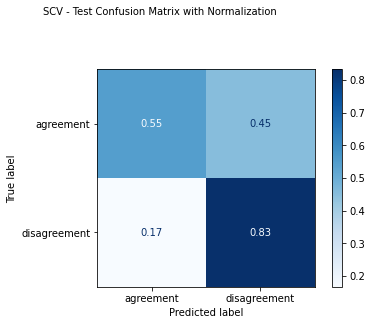

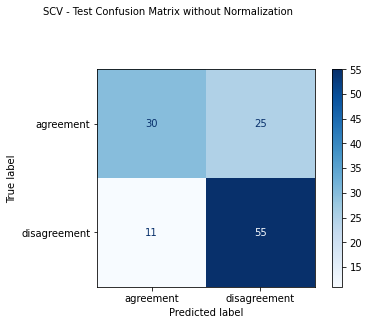

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 42.165s

Best score: 0.836
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        55
           1       0.84      0.95      0.89        66

    accuracy                           0.88       121
   macro avg       0.89      0.87      0.87       121
weighted avg       0.88      0.88      0.87       121

Balanced test accuracy:  0.868


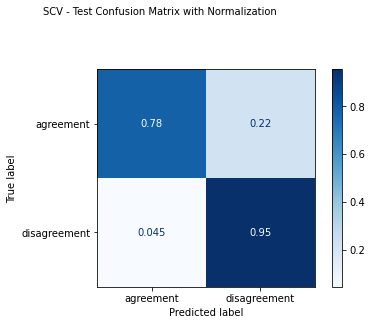

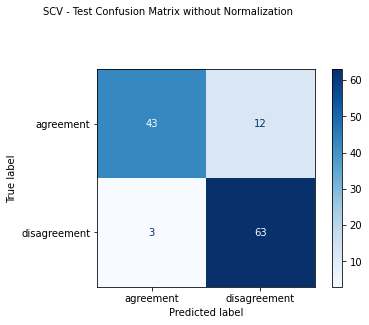

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 50.295s

Best score: 0.867
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.85      0.91        55
           1       0.89      0.98      0.94        66

    accuracy                           0.93       121
   macro avg       0.93      0.92      0.92       121
weighted avg       0.93      0.93      0.92       121

Balanced test accuracy:  0.92


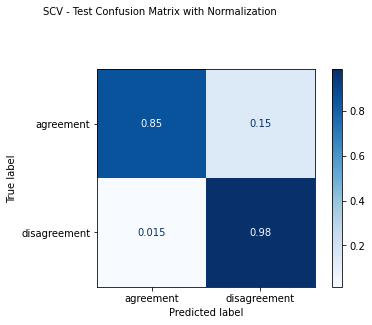

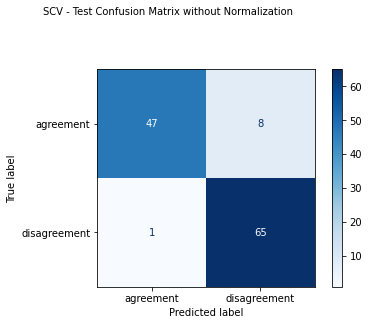

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 56.981s

Best score: 0.873
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.87      0.92        55
           1       0.90      0.98      0.94        66

    accuracy                           0.93       121
   macro avg       0.94      0.93      0.93       121
weighted avg       0.94      0.93      0.93       121

Balanced test accuracy:  0.929


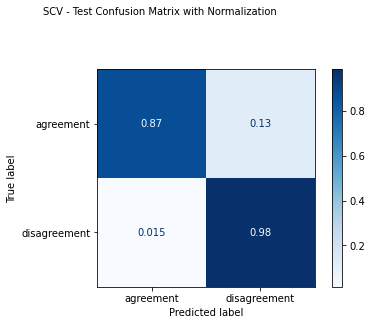

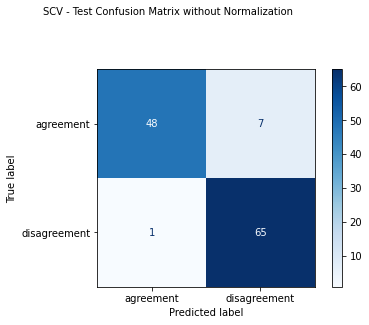

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 32.212s

Best score: 0.677
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.79      0.69      0.73        54
           1       0.77      0.85      0.81        67

    accuracy                           0.78       121
   macro avg       0.78      0.77      0.77       121
weighted avg       0.78      0.78      0.77       121

Balanced test accuracy:  0.768


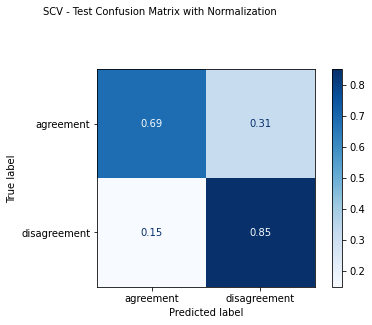

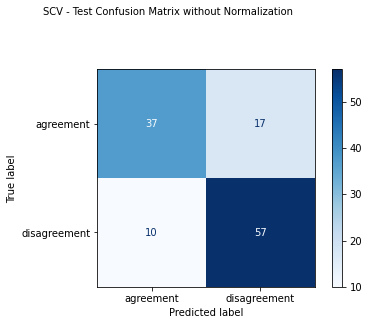

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 41.389s

Best score: 0.819
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        54
           1       0.84      0.96      0.90        67

    accuracy                           0.88       121
   macro avg       0.89      0.87      0.87       121
weighted avg       0.88      0.88      0.87       121

Balanced test accuracy:  0.867


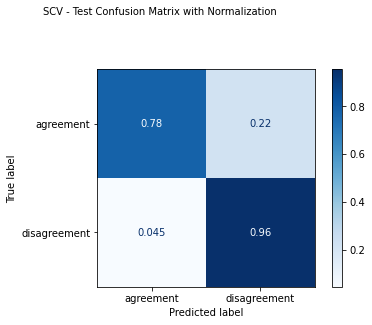

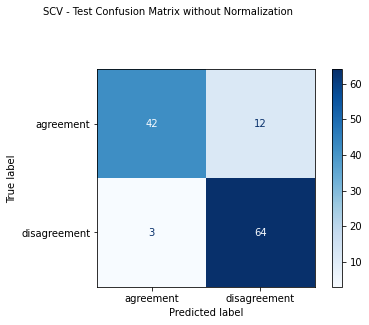

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 49.488s

Best score: 0.852
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        54
           1       0.85      0.96      0.90        67

    accuracy                           0.88       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.89      0.88      0.88       121

Balanced test accuracy:  0.876


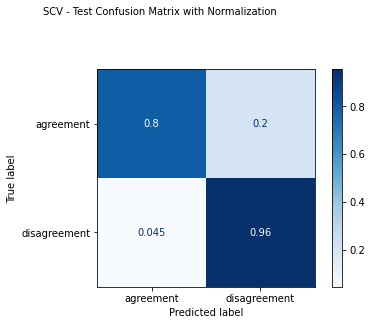

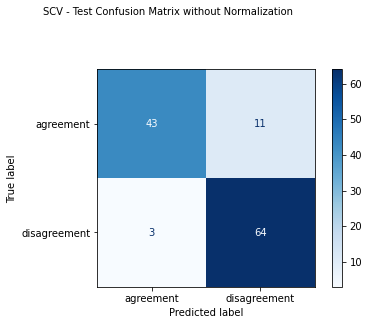

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 57.157s

Best score: 0.869
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        54
           1       0.85      0.96      0.90        67

    accuracy                           0.88       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.89      0.88      0.88       121

Balanced test accuracy:  0.876


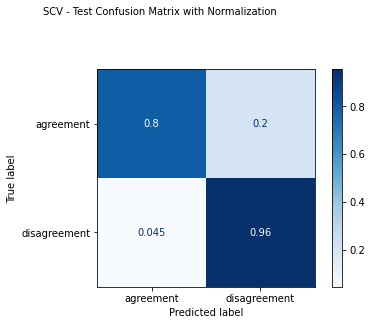

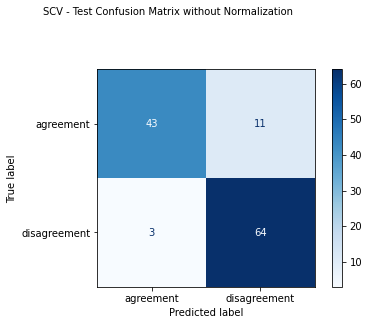

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 32.775s

Best score: 0.744
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.66      0.63      0.65        52
           1       0.72      0.74      0.73        66

    accuracy                           0.69       118
   macro avg       0.69      0.69      0.69       118
weighted avg       0.69      0.69      0.69       118

Balanced test accuracy:  0.689


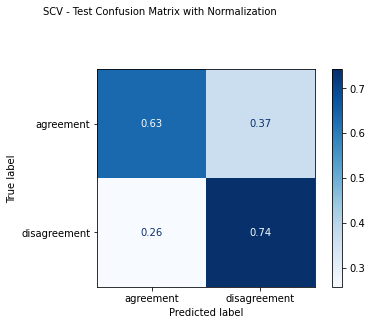

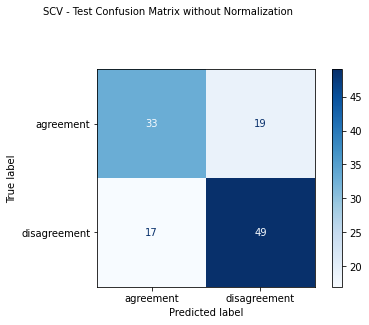

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 43.002s

Best score: 0.763
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.72      0.75      0.74        52
           1       0.80      0.77      0.78        66

    accuracy                           0.76       118
   macro avg       0.76      0.76      0.76       118
weighted avg       0.76      0.76      0.76       118

Balanced test accuracy:  0.761


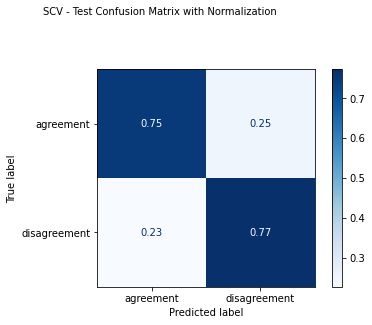

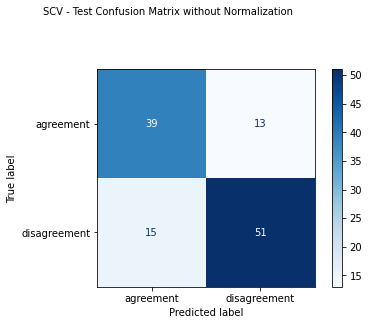

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 52.686s

Best score: 0.761
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        52
           1       0.84      0.80      0.82        66

    accuracy                           0.81       118
   macro avg       0.80      0.81      0.80       118
weighted avg       0.81      0.81      0.81       118

Balanced test accuracy:  0.805


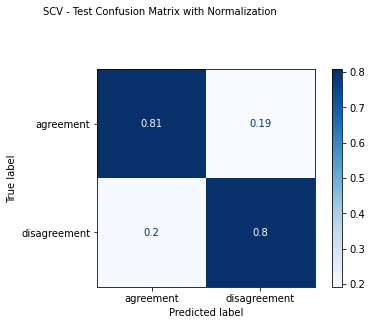

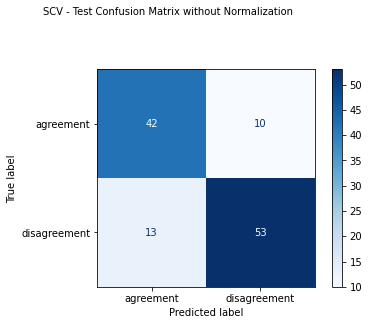

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 61.352s

Best score: 0.759
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        52
           1       0.87      0.80      0.83        66

    accuracy                           0.82       118
   macro avg       0.82      0.82      0.82       118
weighted avg       0.83      0.82      0.82       118

Balanced test accuracy:  0.825


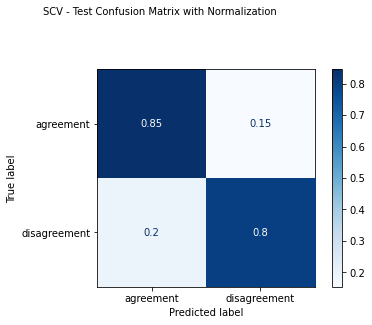

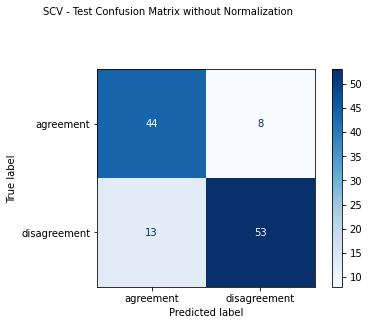

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 37.506s

Best score: 0.647
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.58      0.74      0.65        47
           1       0.79      0.64      0.70        69

    accuracy                           0.68       116
   macro avg       0.68      0.69      0.68       116
weighted avg       0.70      0.68      0.68       116

Balanced test accuracy:  0.691


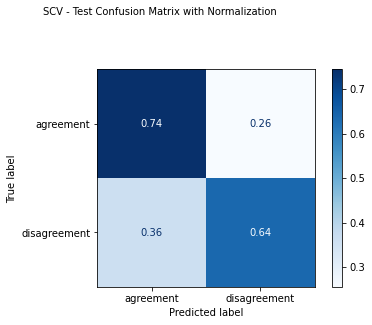

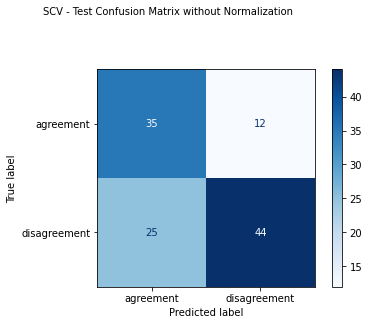

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 49.075s

Best score: 0.743
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.67      0.72      0.69        47
           1       0.80      0.75      0.78        69

    accuracy                           0.74       116
   macro avg       0.73      0.74      0.73       116
weighted avg       0.75      0.74      0.74       116

Balanced test accuracy:  0.739


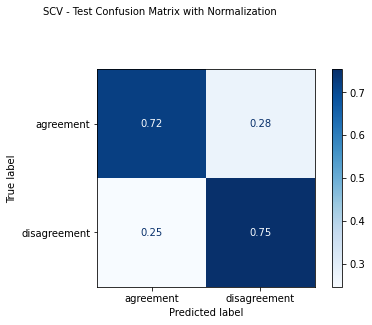

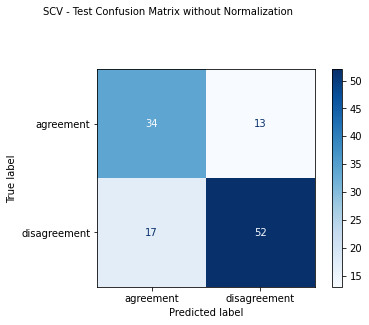

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 59.477s

Best score: 0.762
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        47
           1       0.79      0.80      0.79        69

    accuracy                           0.75       116
   macro avg       0.74      0.74      0.74       116
weighted avg       0.75      0.75      0.75       116

Balanced test accuracy:  0.739


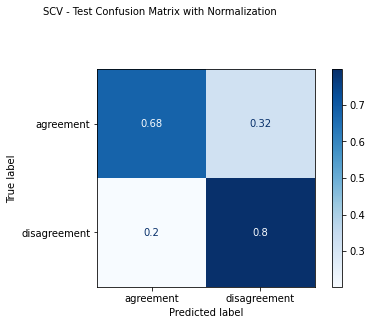

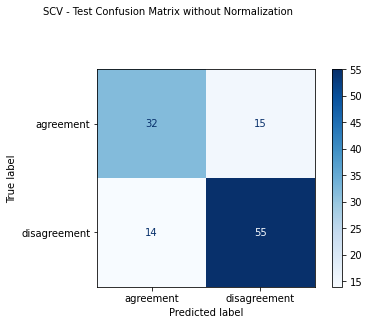

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 70.512s

Best score: 0.773
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        47
           1       0.79      0.81      0.80        69

    accuracy                           0.76       116
   macro avg       0.75      0.75      0.75       116
weighted avg       0.76      0.76      0.76       116

Balanced test accuracy:  0.746


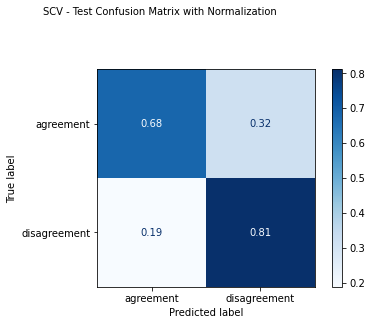

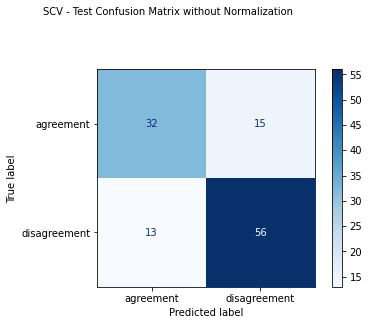

In [ ]:
f1_score_dict = {}
for topic in toptentopics:
  for nrange in ngramranges:
    df= data_merged.loc[data_merged['topic'] == topic]
    X_train, X_test, y_train, y_test = train_test_split(df['debate'], df['agreement'], test_size=0.20, random_state=42)


    labelEncoder = preprocessing.LabelEncoder()
    labelEncoder.fit(["disagreement", "agreement"])
    y_train= labelEncoder.transform(y_train)
    y_test= labelEncoder.transform(y_test)


    print(f'CREATING MODEL FOR TOPIC: "{topic}" WITH N-GRAMS RANGE {nrange} \n')
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer= tokenizer, ngram_range= nrange)),
        ('tfidf', TfidfTransformer(use_idf=True)),
        ('clf',  SVC()),
    ])

    parameters = {'clf__kernel': ['linear', 'rbf'], 'clf__gamma': [1e-3, 1e-4],
                        'clf__C': [0.1, 1, 10, 100]
    }

    model_svc= gridsearch(pipeline=pipeline, parameters=parameters, X_train= X_train, y_train= y_train)
    save_model(modelname= 'SVC_fullDebate', topic= topic, ngramrange=nrange, model= model_svc, separated = False)
    modelname= f'svm_{topic}_{nrange}'
    f1_score_dict[modelname]= f1_score(y_test, y_pred = model_svc.predict(X_test), average='weighted')
    modelevaluation(model_svc, X_test, y_test)
    confusionMatrix (model=model_svc, modelname= 'SCV', X_test=X_test, y_test=y_test)

In [ ]:
f1_score_df= pd.DataFrame.from_dict(f1_score_dict, orient='index', columns= ['f1_score'])
f1_score_df

f1_score
svm_animal_(1, 1)        0.749807
svm_animal_(1, 2)        0.881853
svm_animal_(1, 3)        0.906235
svm_animal_(1, 4)        0.902745
svm_energy_(1, 1)        0.713426
svm_energy_(1, 2)        0.791523
svm_energy_(1, 3)        0.797114
svm_energy_(1, 4)        0.783784
svm_health_(1, 1)        0.691640
svm_health_(1, 2)        0.843243
svm_health_(1, 3)        0.877635
svm_health_(1, 4)        0.882621
svm_circumcision_(1, 1)  0.903000
svm_circumcision_(1, 2)  0.970803
svm_circumcision_(1, 3)  0.970803
svm_circumcision_(1, 4)  0.963687
svm_weapon_(1, 1)        0.772000
svm_weapon_(1, 2)        0.880948
svm_weapon_(1, 3)        0.920501
svm_weapon_(1, 4)        0.920501
svm_death_(1, 1)         0.624947
svm_death_(1, 2)         0.893437
svm_death_(1, 3)         0.877499
svm_death_(1, 4)         0.885462
svm_marijuana_(1, 1)     0.695050
svm_marijuana_(1, 2)     0.874466
svm_marijuana_(1, 3)     0.924965
svm_marijuana_(1, 4)     0.933414
svm_punishment_(1, 1)    0.774666
svm_punishment_(1, 2)    0.874299
svm_punishment_(1, 3)    0.882929
svm_punishment_(1, 4)    0.882929
svm_tax_(1, 1)           0.694201
svm_tax_(1, 2)           0.763125
svm_tax_(1, 3)           0.805551
svm_tax_(1, 4)           0.822612
svm_life_(1, 1)          0.683825
svm_life_(1, 2)          0.742797
svm_life_(1, 3)          0.749555
svm_life_(1, 4)          0.757721

## Models with split Debate
In this section I create a model for each topic but taking position1 and position2 separately

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 86.918s

Best score: 0.905
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       150
           1       0.87      0.95      0.91       138

    accuracy                           0.91       288
   macro avg       0.91      0.91      0.91       288
weighted avg       0.91      0.91      0.91       288

Balanced test accuracy:  0.911


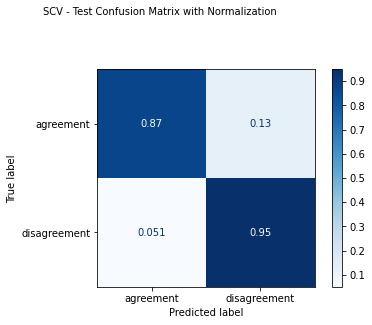

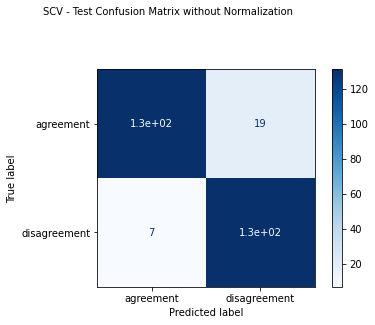

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 114.179s

Best score: 0.901
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       150
           1       0.88      0.96      0.92       138

    accuracy                           0.92       288
   macro avg       0.92      0.92      0.92       288
weighted avg       0.92      0.92      0.92       288

Balanced test accuracy:  0.918


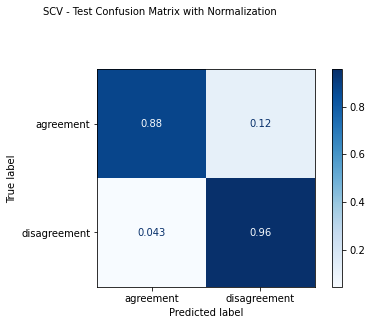

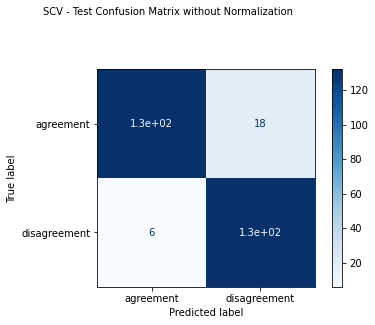

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 135.471s

Best score: 0.902
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       150
           1       0.86      0.96      0.90       138

    accuracy                           0.90       288
   macro avg       0.91      0.90      0.90       288
weighted avg       0.91      0.90      0.90       288

Balanced test accuracy:  0.905


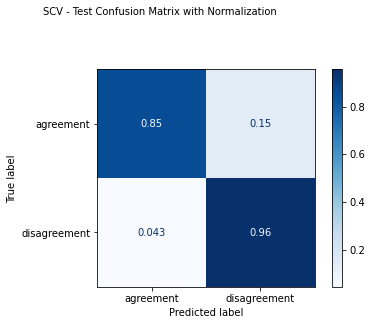

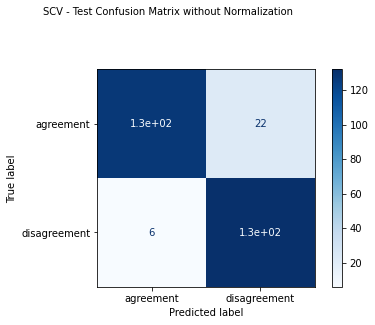

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 155.261s

Best score: 0.899
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       150
           1       0.86      0.96      0.90       138

    accuracy                           0.90       288
   macro avg       0.91      0.90      0.90       288
weighted avg       0.91      0.90      0.90       288

Balanced test accuracy:  0.905


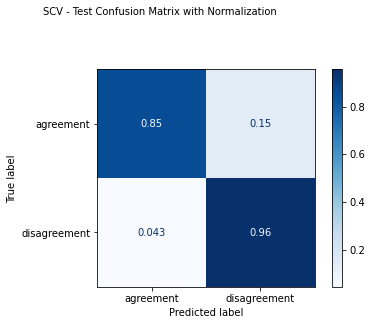

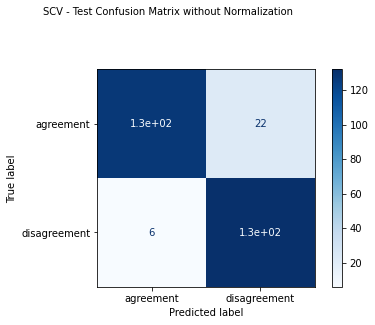

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 80.593s

Best score: 0.836
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        90
           1       0.92      0.93      0.92       132

    accuracy                           0.91       222
   macro avg       0.91      0.90      0.91       222
weighted avg       0.91      0.91      0.91       222

Balanced test accuracy:  0.905


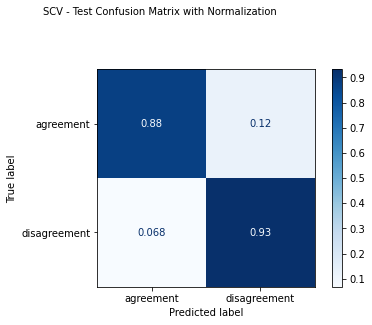

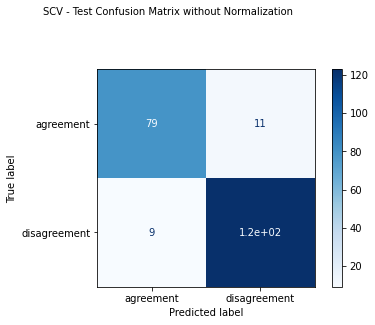

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 106.516s

Best score: 0.832
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.87      0.84      0.86        90
           1       0.90      0.92      0.91       132

    accuracy                           0.89       222
   macro avg       0.88      0.88      0.88       222
weighted avg       0.89      0.89      0.89       222

Balanced test accuracy:  0.881


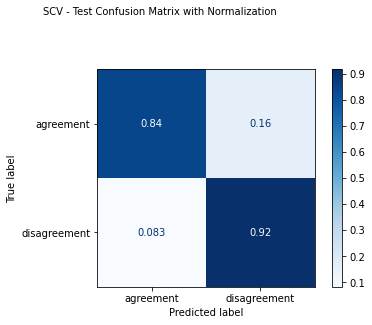

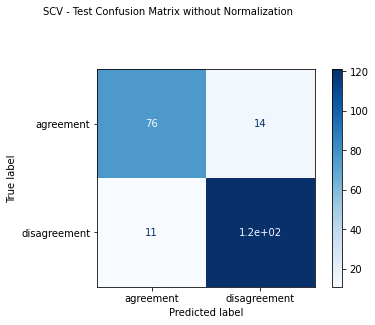

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 128.939s

Best score: 0.823
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        90
           1       0.88      0.92      0.90       132

    accuracy                           0.88       222
   macro avg       0.88      0.87      0.88       222
weighted avg       0.88      0.88      0.88       222

Balanced test accuracy:  0.873


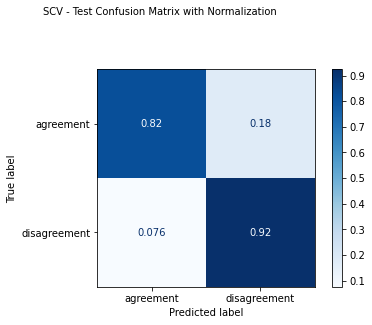

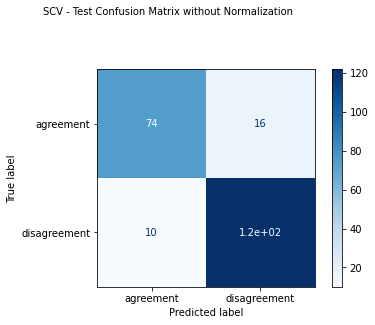

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 152.076s

Best score: 0.819
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        90
           1       0.88      0.92      0.90       132

    accuracy                           0.88       222
   macro avg       0.88      0.87      0.88       222
weighted avg       0.88      0.88      0.88       222

Balanced test accuracy:  0.873


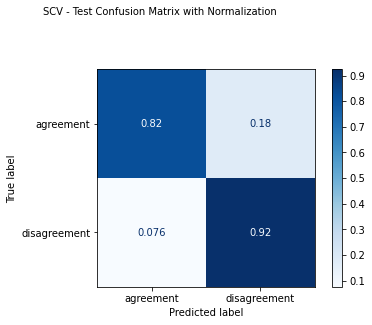

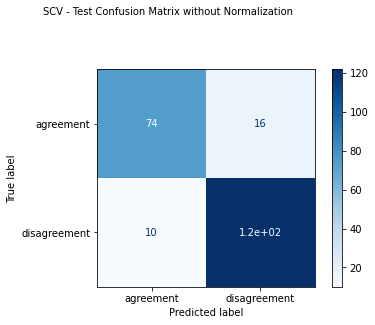

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 76.445s

Best score: 0.851
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        91
           1       0.89      0.96      0.93       114

    accuracy                           0.92       205
   macro avg       0.92      0.91      0.92       205
weighted avg       0.92      0.92      0.92       205

Balanced test accuracy:  0.911


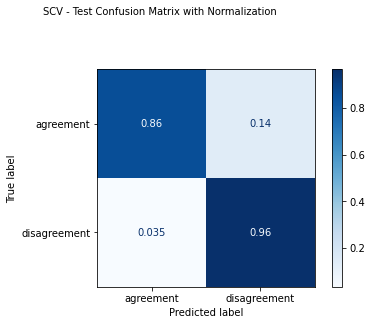

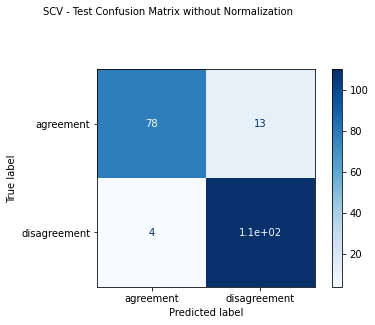

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 100.579s

Best score: 0.854
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        91
           1       0.92      0.96      0.94       114

    accuracy                           0.93       205
   macro avg       0.93      0.92      0.93       205
weighted avg       0.93      0.93      0.93       205

Balanced test accuracy:  0.923


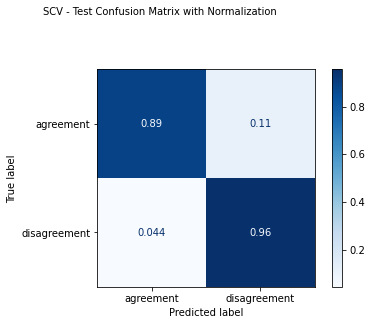

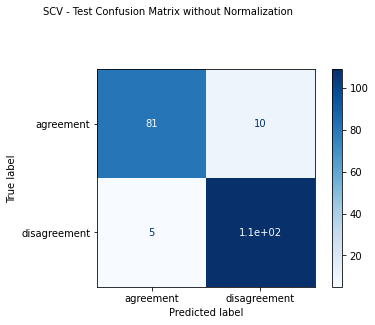

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 122.490s

Best score: 0.847
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        91
           1       0.92      0.96      0.94       114

    accuracy                           0.93       205
   macro avg       0.93      0.92      0.93       205
weighted avg       0.93      0.93      0.93       205

Balanced test accuracy:  0.923


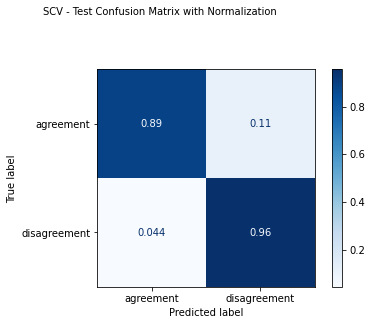

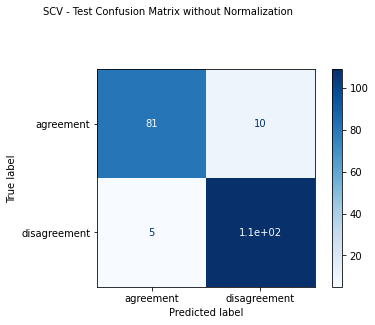

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 143.280s

Best score: 0.843
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        91
           1       0.92      0.96      0.94       114

    accuracy                           0.93       205
   macro avg       0.93      0.92      0.93       205
weighted avg       0.93      0.93      0.93       205

Balanced test accuracy:  0.923


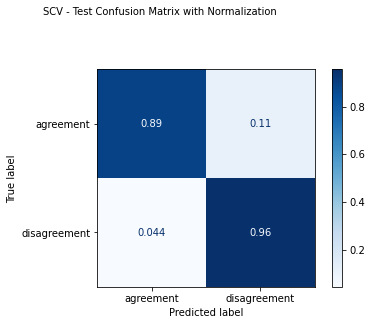

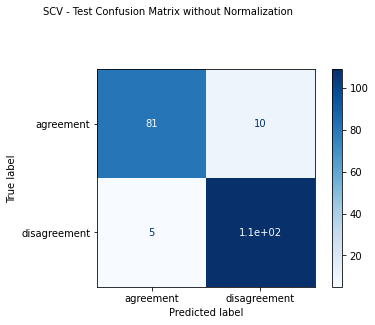

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 34.990s

Best score: 0.976
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        85

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137

Balanced test accuracy:  1.0


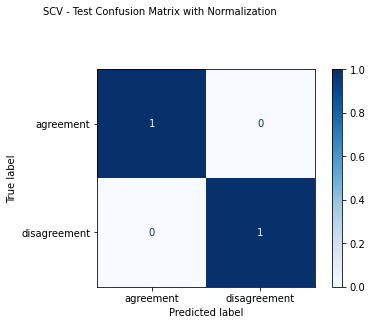

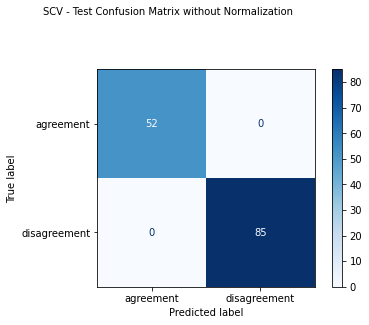

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 43.450s

Best score: 0.978
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        85

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137

Balanced test accuracy:  1.0


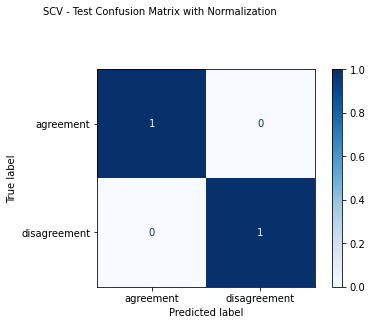

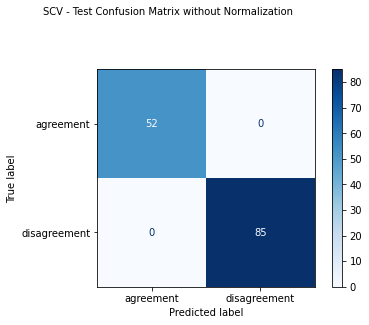

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 50.362s

Best score: 0.978
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        85

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137

Balanced test accuracy:  1.0


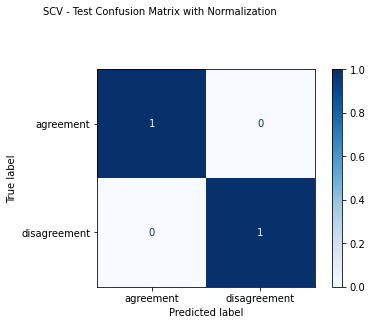

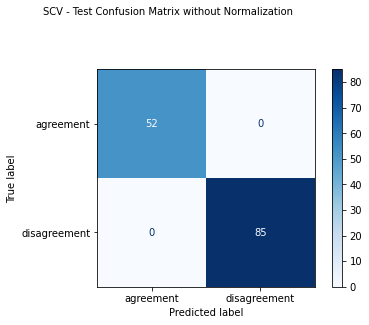

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 57.346s

Best score: 0.978
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        85

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137

Balanced test accuracy:  1.0


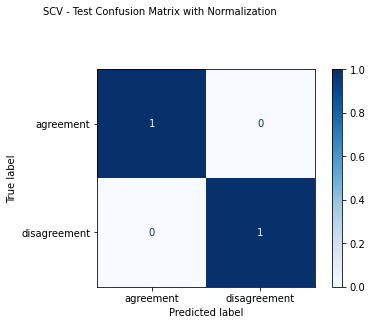

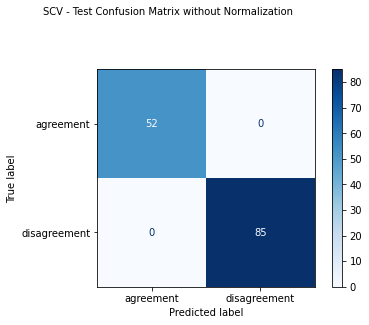

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 36.109s

Best score: 0.939
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.93        58
           1       0.90      1.00      0.95        69

    accuracy                           0.94       127
   macro avg       0.95      0.93      0.94       127
weighted avg       0.94      0.94      0.94       127

Balanced test accuracy:  0.931


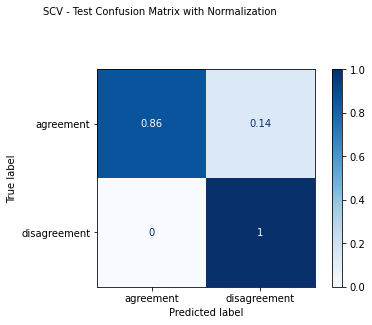

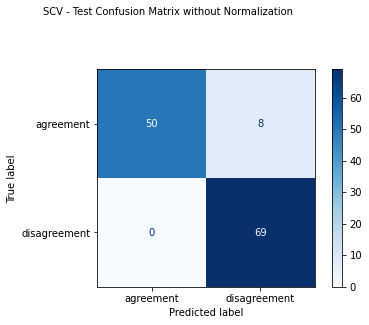

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 46.226s

Best score: 0.931
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        58
           1       0.87      1.00      0.93        69

    accuracy                           0.92       127
   macro avg       0.94      0.91      0.92       127
weighted avg       0.93      0.92      0.92       127

Balanced test accuracy:  0.914


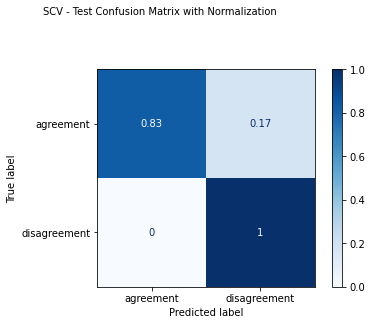

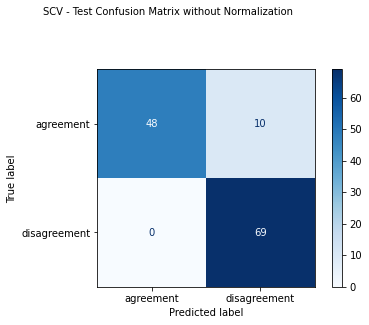

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 55.094s

Best score: 0.929
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        58
           1       0.87      1.00      0.93        69

    accuracy                           0.92       127
   macro avg       0.94      0.91      0.92       127
weighted avg       0.93      0.92      0.92       127

Balanced test accuracy:  0.914


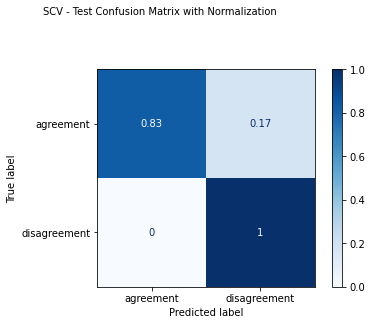

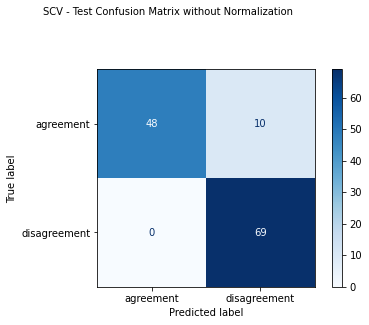

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 63.475s

Best score: 0.929
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        58
           1       0.87      1.00      0.93        69

    accuracy                           0.92       127
   macro avg       0.94      0.91      0.92       127
weighted avg       0.93      0.92      0.92       127

Balanced test accuracy:  0.914


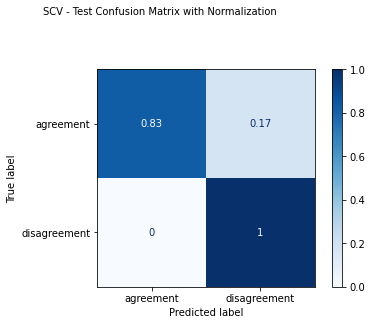

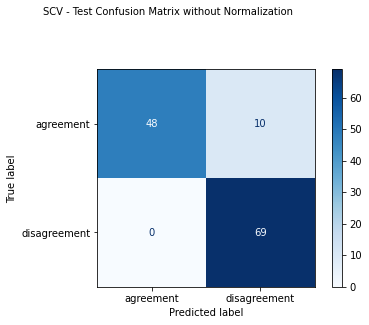

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 35.329s

Best score: 0.910
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.81      0.88        52
           1       0.87      0.97      0.92        71

    accuracy                           0.90       123
   macro avg       0.91      0.89      0.90       123
weighted avg       0.91      0.90      0.90       123

Balanced test accuracy:  0.89


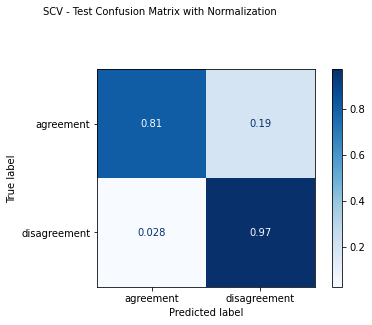

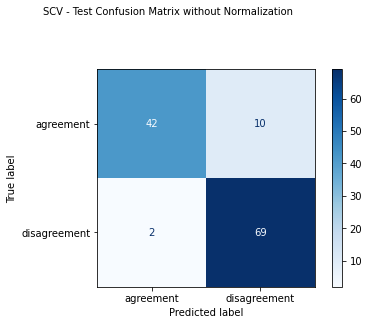

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 44.956s

Best score: 0.914
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.81      0.88        52
           1       0.87      0.97      0.92        71

    accuracy                           0.90       123
   macro avg       0.91      0.89      0.90       123
weighted avg       0.91      0.90      0.90       123

Balanced test accuracy:  0.89


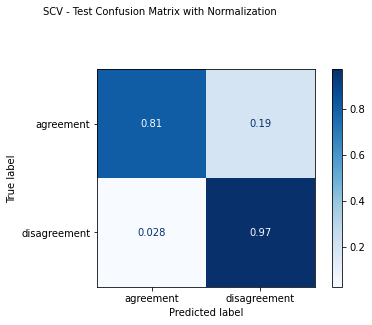

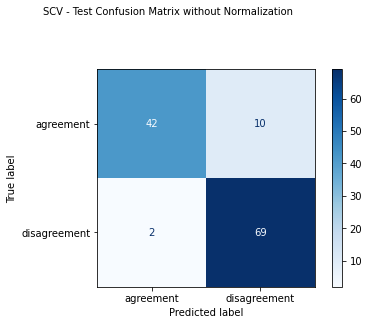

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 53.236s

Best score: 0.914
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.81      0.88        52
           1       0.87      0.97      0.92        71

    accuracy                           0.90       123
   macro avg       0.91      0.89      0.90       123
weighted avg       0.91      0.90      0.90       123

Balanced test accuracy:  0.89


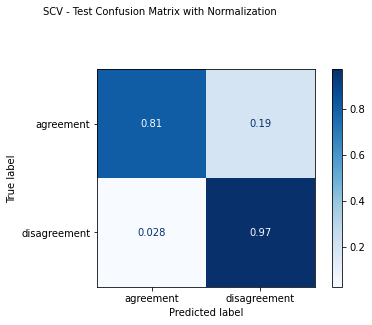

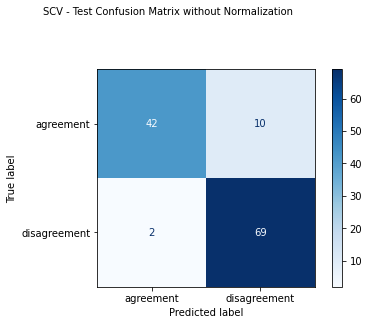

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 62.532s

Best score: 0.916
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.81      0.88        52
           1       0.87      0.97      0.92        71

    accuracy                           0.90       123
   macro avg       0.91      0.89      0.90       123
weighted avg       0.91      0.90      0.90       123

Balanced test accuracy:  0.89


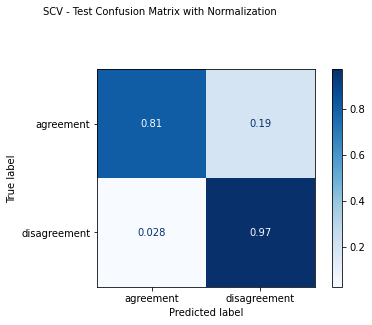

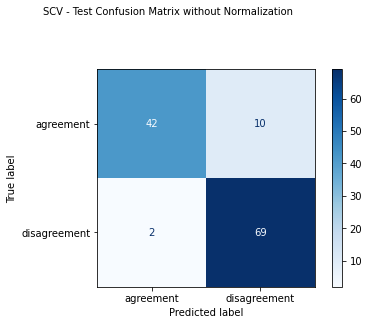

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 33.261s

Best score: 0.913
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        55
           1       0.96      1.00      0.98        66

    accuracy                           0.98       121
   macro avg       0.98      0.97      0.97       121
weighted avg       0.98      0.98      0.98       121

Balanced test accuracy:  0.973


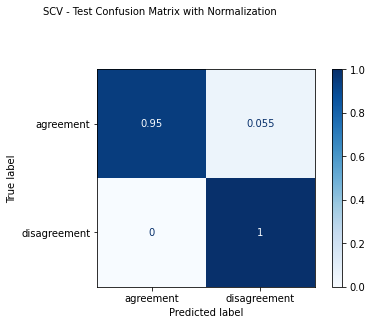

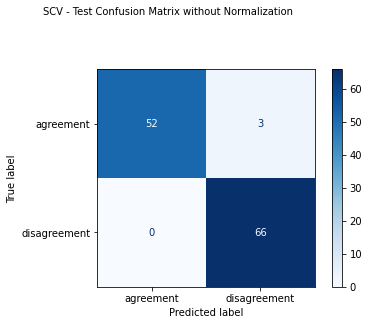

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 41.942s

Best score: 0.915
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        55
           1       0.96      1.00      0.98        66

    accuracy                           0.98       121
   macro avg       0.98      0.97      0.97       121
weighted avg       0.98      0.98      0.98       121

Balanced test accuracy:  0.973


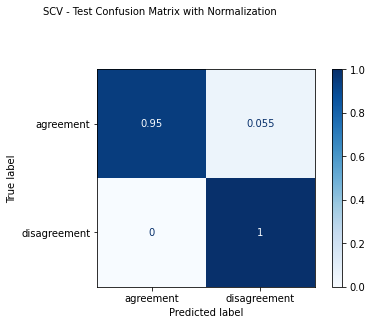

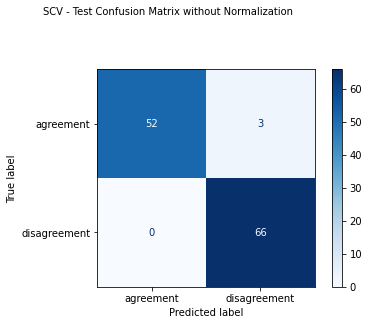

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 49.444s

Best score: 0.915
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        55
           1       0.96      0.98      0.97        66

    accuracy                           0.97       121
   macro avg       0.97      0.97      0.97       121
weighted avg       0.97      0.97      0.97       121

Balanced test accuracy:  0.965


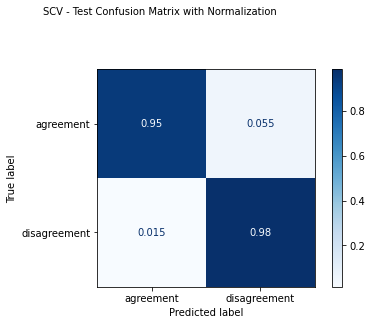

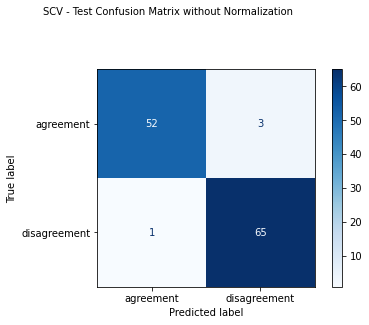

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 56.539s

Best score: 0.923
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        55
           1       0.96      0.98      0.97        66

    accuracy                           0.97       121
   macro avg       0.97      0.97      0.97       121
weighted avg       0.97      0.97      0.97       121

Balanced test accuracy:  0.965


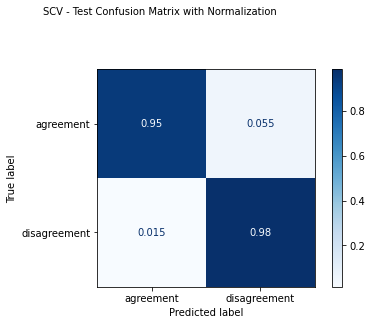

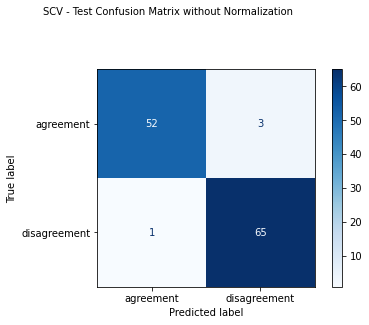

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 32.855s

Best score: 0.904
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.94      0.81      0.87        54
           1       0.86      0.96      0.91        67

    accuracy                           0.89       121
   macro avg       0.90      0.89      0.89       121
weighted avg       0.90      0.89      0.89       121

Balanced test accuracy:  0.885


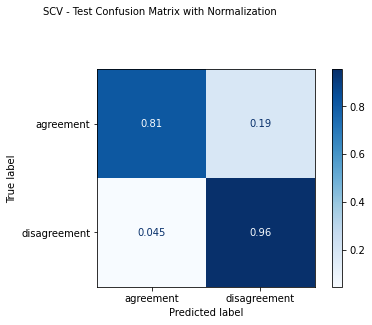

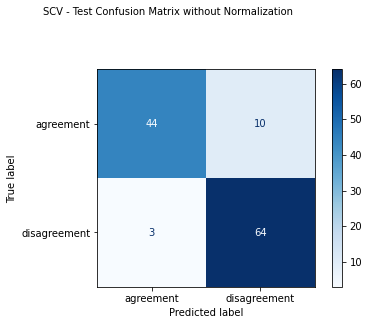

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 41.347s

Best score: 0.908
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        54
           1       0.85      0.96      0.90        67

    accuracy                           0.88       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.89      0.88      0.88       121

Balanced test accuracy:  0.876


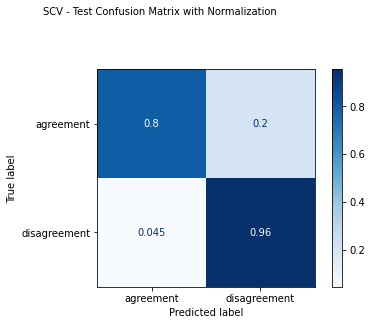

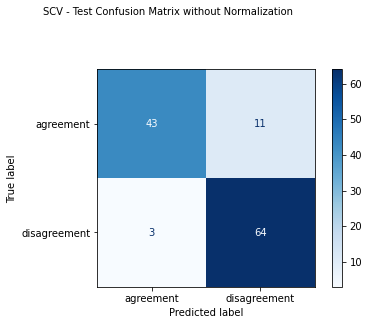

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 48.767s

Best score: 0.910
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        54
           1       0.85      0.96      0.90        67

    accuracy                           0.88       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.89      0.88      0.88       121

Balanced test accuracy:  0.876


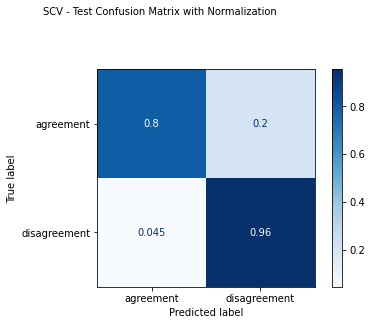

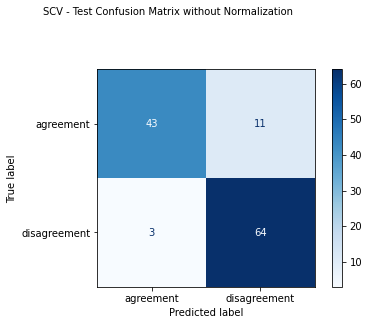

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 56.828s

Best score: 0.908
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        54
           1       0.85      0.96      0.90        67

    accuracy                           0.88       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.89      0.88      0.88       121

Balanced test accuracy:  0.876


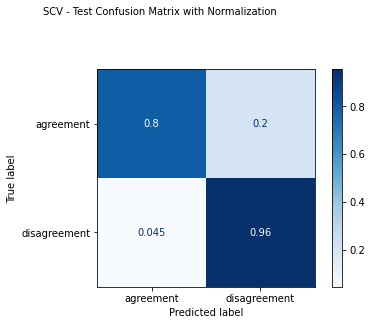

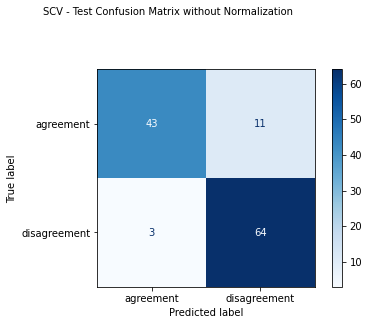

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 34.377s

Best score: 0.846
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        52
           1       0.92      0.85      0.88        66

    accuracy                           0.87       118
   macro avg       0.87      0.88      0.87       118
weighted avg       0.88      0.87      0.87       118

Balanced test accuracy:  0.876


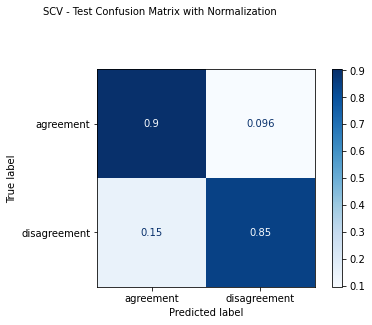

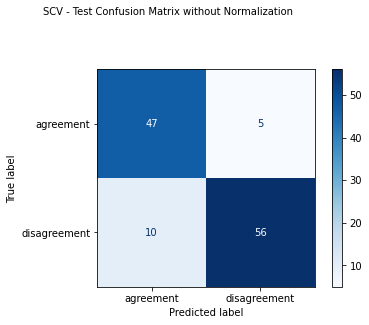

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 43.963s

Best score: 0.854
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        52
           1       0.94      0.88      0.91        66

    accuracy                           0.90       118
   macro avg       0.90      0.90      0.90       118
weighted avg       0.90      0.90      0.90       118

Balanced test accuracy:  0.901


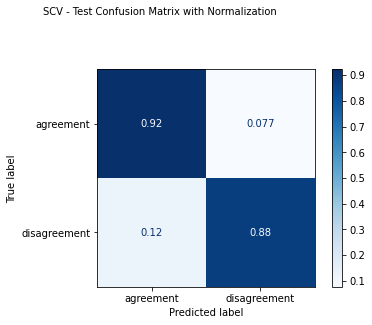

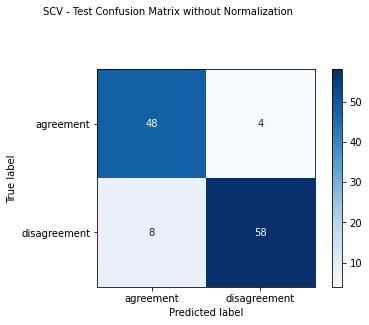

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 52.673s

Best score: 0.854
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        52
           1       0.94      0.88      0.91        66

    accuracy                           0.90       118
   macro avg       0.90      0.90      0.90       118
weighted avg       0.90      0.90      0.90       118

Balanced test accuracy:  0.901


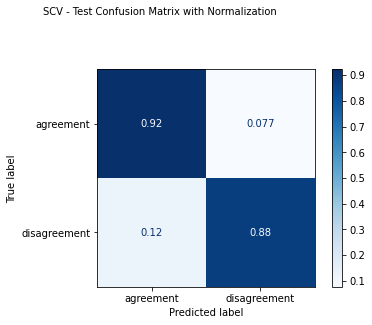

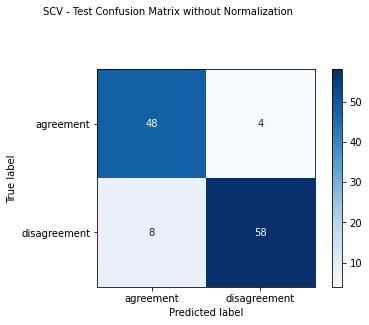

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 61.334s

Best score: 0.850
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        52
           1       0.94      0.88      0.91        66

    accuracy                           0.90       118
   macro avg       0.90      0.90      0.90       118
weighted avg       0.90      0.90      0.90       118

Balanced test accuracy:  0.901


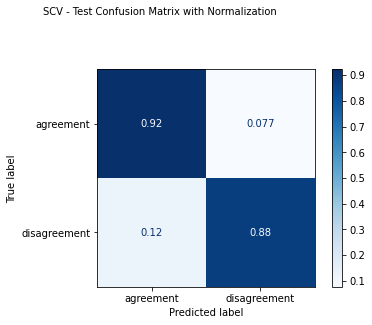

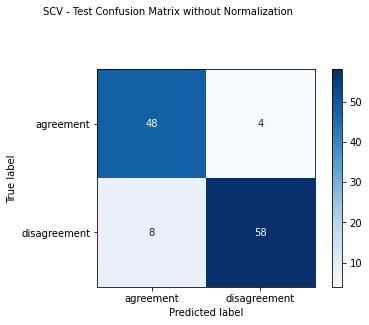

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 1) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 38.872s

Best score: 0.834
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.80      0.94      0.86        47
           1       0.95      0.84      0.89        69

    accuracy                           0.88       116
   macro avg       0.88      0.89      0.88       116
weighted avg       0.89      0.88      0.88       116

Balanced test accuracy:  0.888


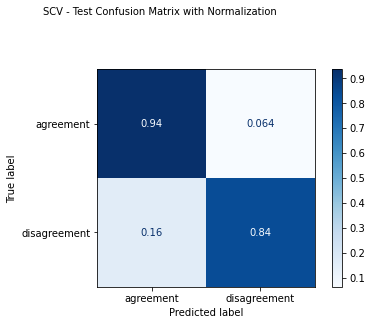

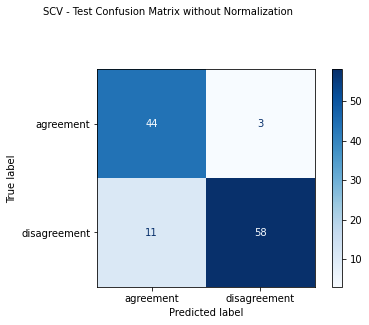

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 2) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 49.774s

Best score: 0.842
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        47
           1       0.94      0.90      0.92        69

    accuracy                           0.91       116
   macro avg       0.90      0.91      0.90       116
weighted avg       0.91      0.91      0.91       116

Balanced test accuracy:  0.907


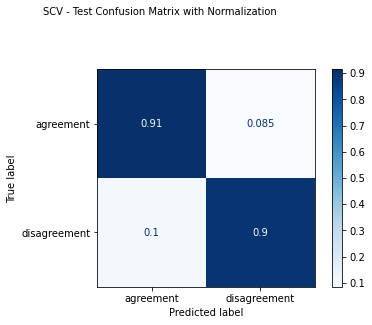

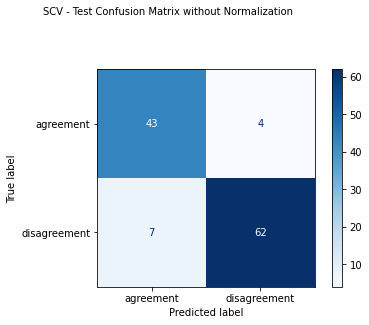

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 3) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 60.679s

Best score: 0.838
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        47
           1       0.94      0.88      0.91        69

    accuracy                           0.90       116
   macro avg       0.89      0.90      0.89       116
weighted avg       0.90      0.90      0.90       116

Balanced test accuracy:  0.899


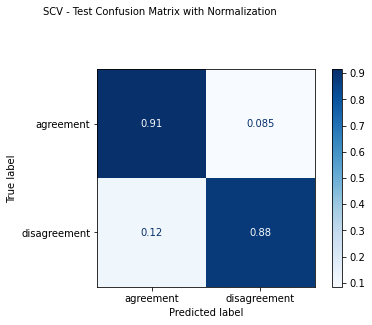

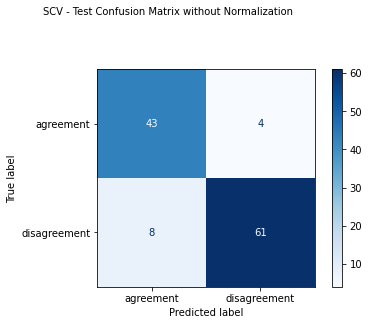

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 4) 

Performing grid search...
pipeline: ['transformer', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 72.928s

Best score: 0.838
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        47
           1       0.94      0.88      0.91        69

    accuracy                           0.90       116
   macro avg       0.89      0.90      0.89       116
weighted avg       0.90      0.90      0.90       116

Balanced test accuracy:  0.899


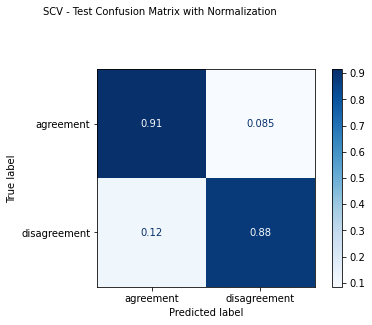

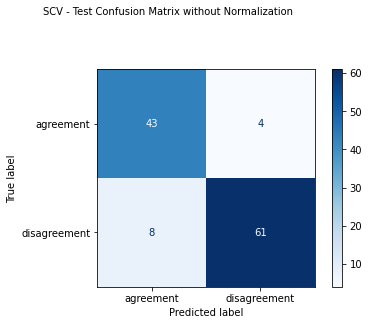

In [ ]:
f1_score_dict_separated={}
for topic in toptentopics:
  for nrange in ngramranges:
    df= data_separated.loc[data_separated['topic'] == topic]
    y = df['agreement']
    X= df.drop(columns=['agreement', 'topic'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    labelEncoder = preprocessing.LabelEncoder()
    labelEncoder.fit(["disagreement", "agreement"])
    y_train= labelEncoder.transform(y_train)
    y_test= labelEncoder.transform(y_test)


    print(f'CREATING MODEL FOR TOPIC: "{topic}" WITH N-GRAMS RANGE {nrange} \n')
    pipeline = Pipeline([ 
        ('transformer', FeatureUnion([
                ('pos1_tfidf', 
                  Pipeline([('extract_field', FunctionTransformer(lambda x: x['position1_cleaned'], validate=False)),
                            ('tfidf', TfidfVectorizer(tokenizer= tokenizer, ngram_range= nrange))])),
                ('pos2_tfidf', 
                  Pipeline([('extract_field', FunctionTransformer(lambda x: x['position2_cleaned'], validate=False)),
                            ('tfidf', TfidfVectorizer(tokenizer= tokenizer, ngram_range= nrange))]))
                ])),
        ('clf',  SVC()),
    ])

    parameters = {'clf__kernel': ['linear', 'rbf'], 'clf__gamma': [1e-3, 1e-4],
                        'clf__C': [0.1, 1, 10, 100]
    }

    model_svc= gridsearch(pipeline=pipeline, parameters=parameters, X_train= X_train, y_train= y_train)
    save_model(modelname= 'SVC_splitDebate', topic= topic, ngramrange=nrange, model= model_svc, separated= True)
    modelname= f'svm_{topic}_{nrange}'
    f1_score_dict_separated[modelname]= f1_score(y_test, y_pred = model_svc.predict(X_test), average='weighted')
    modelevaluation(model_svc, X_test, y_test)
    confusionMatrix (model=model_svc, modelname= 'SCV', X_test=X_test, y_test=y_test)

In [ ]:
f1_score_df_separated= pd.DataFrame.from_dict(f1_score_dict_separated, orient='index', columns= ['f1_score'])
f1_score_df_separated

f1_score
svm_animal_(1, 1)        0.909722
svm_animal_(1, 2)        0.916667
svm_animal_(1, 3)        0.902703
svm_animal_(1, 4)        0.902703
svm_energy_(1, 1)        0.909742
svm_energy_(1, 2)        0.887066
svm_energy_(1, 3)        0.882165
svm_energy_(1, 4)        0.882165
svm_health_(1, 1)        0.916491
svm_health_(1, 2)        0.926581
svm_health_(1, 3)        0.926581
svm_health_(1, 4)        0.926581
svm_circumcision_(1, 1)  1.000000
svm_circumcision_(1, 2)  1.000000
svm_circumcision_(1, 3)  1.000000
svm_circumcision_(1, 4)  1.000000
svm_weapon_(1, 1)        0.936401
svm_weapon_(1, 2)        0.920206
svm_weapon_(1, 3)        0.920206
svm_weapon_(1, 4)        0.920206
svm_death_(1, 1)         0.900976
svm_death_(1, 2)         0.900976
svm_death_(1, 3)         0.900976
svm_death_(1, 4)         0.900976
svm_marijuana_(1, 1)     0.975135
svm_marijuana_(1, 2)     0.975135
svm_marijuana_(1, 3)     0.966883
svm_marijuana_(1, 4)     0.966883
svm_punishment_(1, 1)    0.891506
svm_punishment_(1, 2)    0.882929
svm_punishment_(1, 3)    0.882929
svm_punishment_(1, 4)    0.882929
svm_tax_(1, 1)           0.873295
svm_tax_(1, 2)           0.898599
svm_tax_(1, 3)           0.898599
svm_tax_(1, 4)           0.898599
svm_life_(1, 1)          0.880330
svm_life_(1, 2)          0.905585
svm_life_(1, 3)          0.897119
svm_life_(1, 4)          0.897119

# Models with polarity score
In this section I create models that take as feature the tfidf score of the text, as well as the sentiment polarity score of each debate, or each position depedning on wether the used dataset is merged or separated 

In [20]:
sid = SentimentIntensityAnalyzer()

data_separated['polarity_score_1']= data_separated['position1_cleaned'].apply(lambda x: sid.polarity_scores(x)['compound'])
data_separated['polarity_score_2']= data_separated['position2_cleaned'].apply(lambda x: sid.polarity_scores(x)['compound'])
data_merged['polarity_score']= data_merged['debate'].apply(lambda x: sid.polarity_scores(x)['compound'])

In [ ]:
data_merged

agreement  ... polarity_score
0      disagreement  ...        -0.2534
1      disagreement  ...        -0.9314
2      disagreement  ...        -0.9322
3      disagreement  ...         0.6369
4      disagreement  ...         0.3990
...             ...  ...            ...
29338     agreement  ...         0.9360
29339     agreement  ...         0.8834
29340     agreement  ...         0.9877
29341     agreement  ...         0.9897
29342     agreement  ...         0.9337

[29244 rows x 4 columns]

In [ ]:
data_separated

agreement    topic  ... polarity_score_1 polarity_score_2
0      disagreement  bailout  ...           0.2960          -0.4964
1      disagreement  bailout  ...           0.2960          -0.9443
2      disagreement  bailout  ...           0.2960          -0.9448
3      disagreement  bailout  ...           0.2960           0.4588
4      disagreement  bailout  ...           0.7096          -0.4964
...             ...      ...  ...              ...              ...
29338     agreement    water  ...           0.4404           0.9081
29339     agreement    water  ...           0.5423           0.7783
29340     agreement    water  ...           0.9847           0.5423
29341     agreement    water  ...           0.9847           0.7783
29342     agreement    water  ...           0.9169           0.2960

[29244 rows x 6 columns]

## Models with complete Debate

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 95.799s

Best score: 0.761
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.79      0.71      0.75       150
           1       0.72      0.79      0.75       138

    accuracy                           0.75       288
   macro avg       0.75      0.75      0.75       288
weighted avg       0.75      0.75      0.75       288

Balanced test accuracy:  0.752


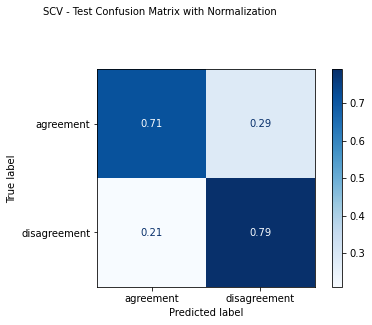

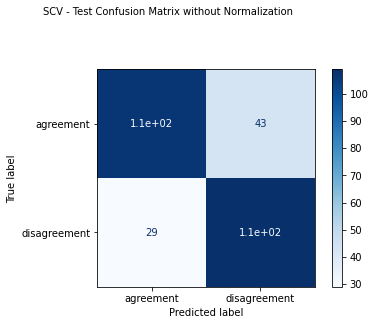

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 126.687s

Best score: 0.878
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       150
           1       0.84      0.93      0.88       138

    accuracy                           0.88       288
   macro avg       0.89      0.88      0.88       288
weighted avg       0.89      0.88      0.88       288

Balanced test accuracy:  0.884


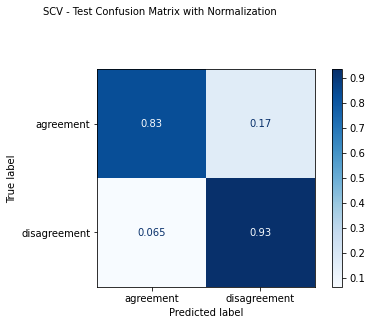

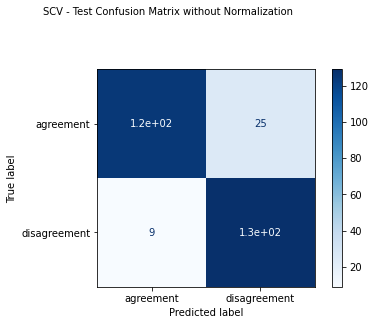

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 150.827s

Best score: 0.902
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       150
           1       0.87      0.95      0.91       138

    accuracy                           0.91       288
   macro avg       0.91      0.91      0.91       288
weighted avg       0.91      0.91      0.91       288

Balanced test accuracy:  0.908


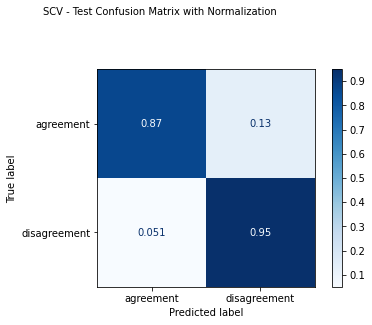

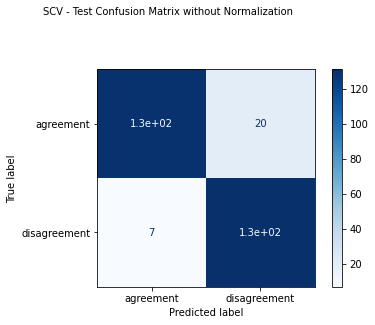

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 172.625s

Best score: 0.898
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       150
           1       0.86      0.95      0.90       138

    accuracy                           0.90       288
   macro avg       0.91      0.90      0.90       288
weighted avg       0.91      0.90      0.90       288

Balanced test accuracy:  0.905


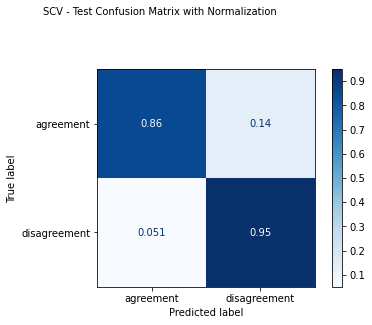

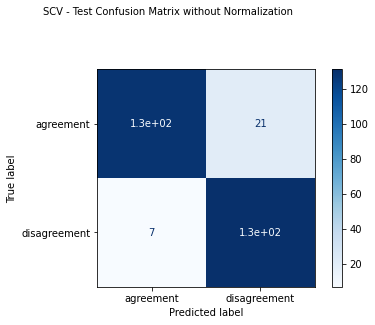

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 83.098s

Best score: 0.604
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        90
           1       0.74      0.80      0.77       132

    accuracy                           0.72       222
   macro avg       0.71      0.70      0.70       222
weighted avg       0.71      0.72      0.71       222

Balanced test accuracy:  0.698


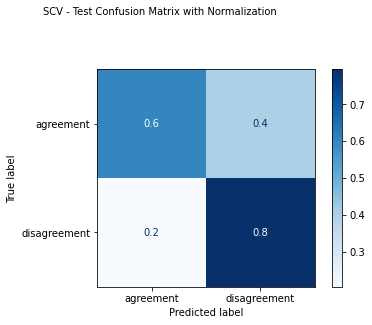

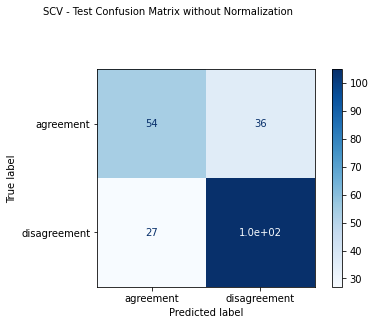

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 113.761s

Best score: 0.680
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        90
           1       0.81      0.86      0.83       132

    accuracy                           0.80       222
   macro avg       0.79      0.78      0.79       222
weighted avg       0.80      0.80      0.80       222

Balanced test accuracy:  0.784


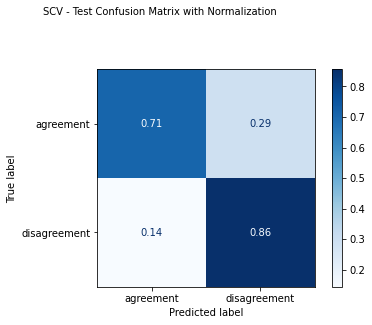

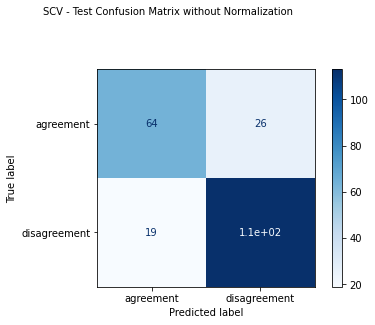

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 139.238s

Best score: 0.731
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.75      0.74      0.75        90
           1       0.83      0.83      0.83       132

    accuracy                           0.80       222
   macro avg       0.79      0.79      0.79       222
weighted avg       0.80      0.80      0.80       222

Balanced test accuracy:  0.789


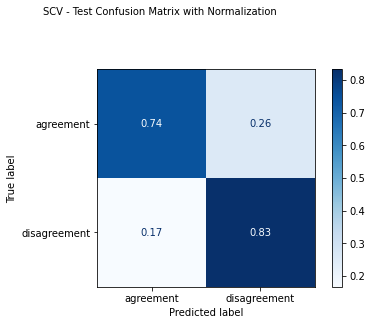

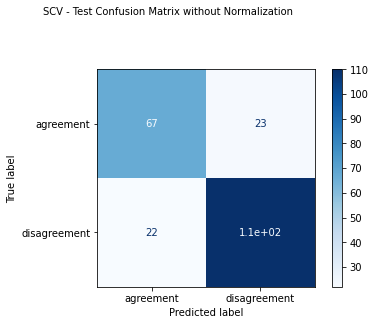

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 161.951s

Best score: 0.746
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        90
           1       0.82      0.82      0.82       132

    accuracy                           0.78       222
   macro avg       0.78      0.78      0.78       222
weighted avg       0.78      0.78      0.78       222

Balanced test accuracy:  0.776


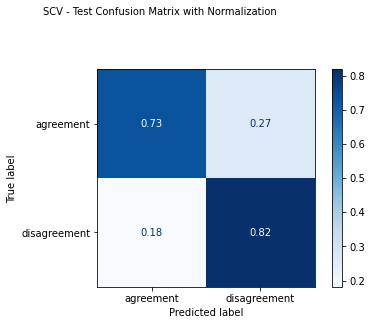

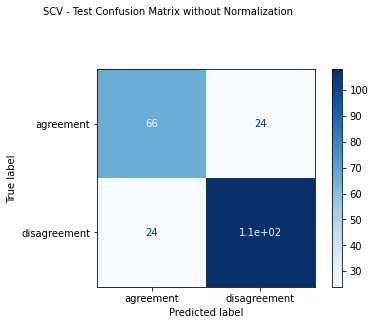

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 78.564s

Best score: 0.638
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.66      0.65      0.65        91
           1       0.72      0.73      0.72       114

    accuracy                           0.69       205
   macro avg       0.69      0.69      0.69       205
weighted avg       0.69      0.69      0.69       205

Balanced test accuracy:  0.688


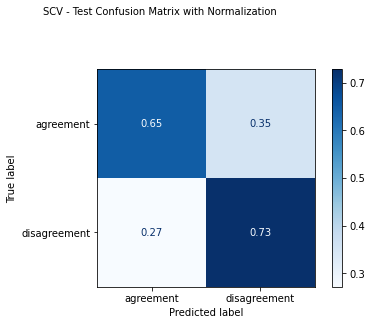

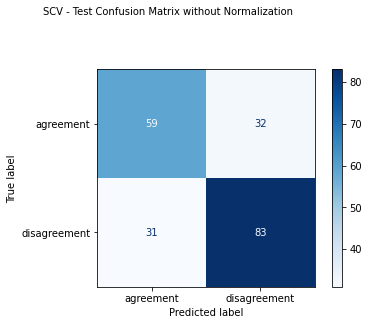

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 107.049s

Best score: 0.715
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82        91
           1       0.84      0.89      0.86       114

    accuracy                           0.84       205
   macro avg       0.84      0.84      0.84       205
weighted avg       0.84      0.84      0.84       205

Balanced test accuracy:  0.839


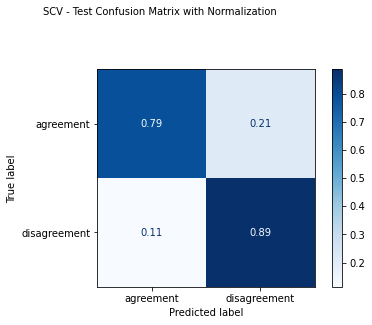

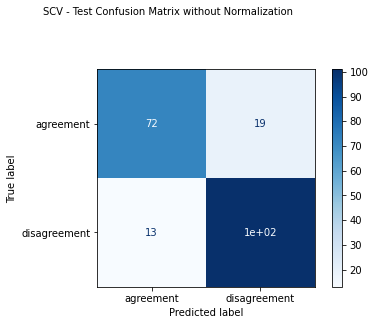

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 130.535s

Best score: 0.743
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.88      0.84      0.86        91
           1       0.87      0.91      0.89       114

    accuracy                           0.88       205
   macro avg       0.88      0.87      0.88       205
weighted avg       0.88      0.88      0.88       205

Balanced test accuracy:  0.874


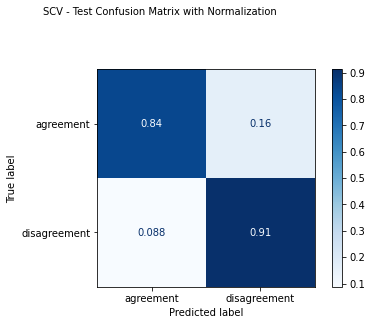

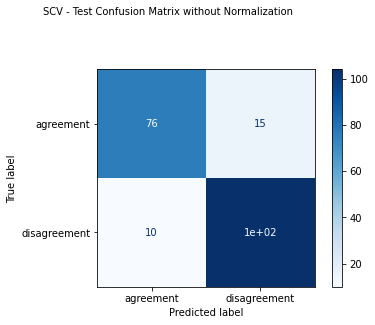

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 151.780s

Best score: 0.751
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.89      0.85      0.87        91
           1       0.88      0.91      0.90       114

    accuracy                           0.88       205
   macro avg       0.88      0.88      0.88       205
weighted avg       0.88      0.88      0.88       205

Balanced test accuracy:  0.879


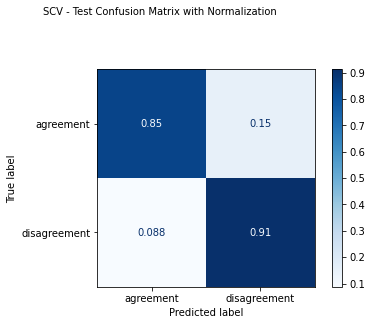

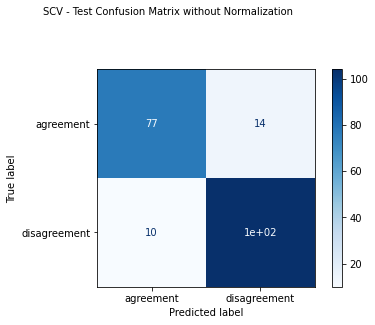

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 38.315s

Best score: 0.864
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.79      0.86        52
           1       0.88      0.98      0.93        85

    accuracy                           0.91       137
   macro avg       0.92      0.88      0.90       137
weighted avg       0.91      0.91      0.90       137

Balanced test accuracy:  0.882


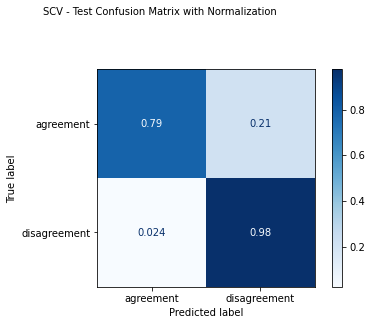

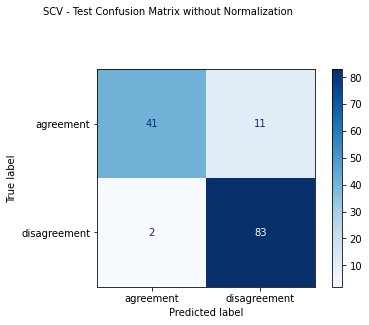

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 48.212s

Best score: 0.949
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        52
           1       0.98      0.98      0.98        85

    accuracy                           0.97       137
   macro avg       0.97      0.97      0.97       137
weighted avg       0.97      0.97      0.97       137

Balanced test accuracy:  0.969


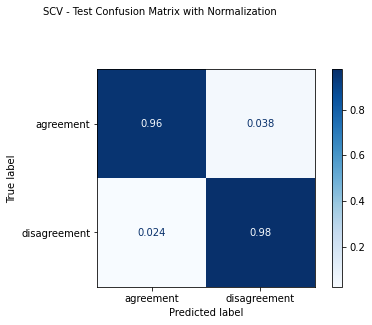

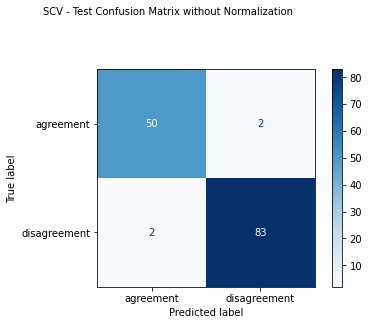

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 55.070s

Best score: 0.960
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        52
           1       0.98      0.98      0.98        85

    accuracy                           0.97       137
   macro avg       0.97      0.97      0.97       137
weighted avg       0.97      0.97      0.97       137

Balanced test accuracy:  0.969


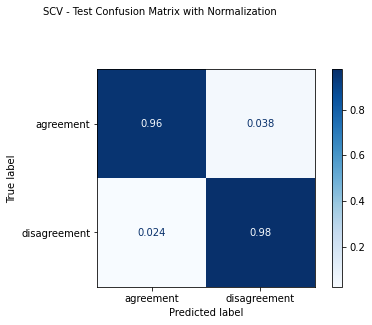

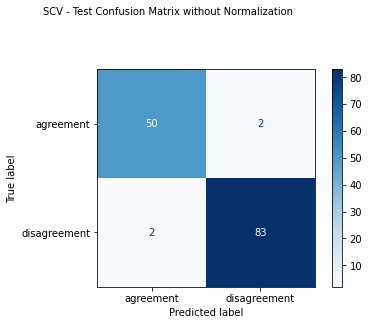

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 62.346s

Best score: 0.960
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        52
           1       0.99      0.95      0.97        85

    accuracy                           0.96       137
   macro avg       0.96      0.97      0.96       137
weighted avg       0.96      0.96      0.96       137

Balanced test accuracy:  0.967


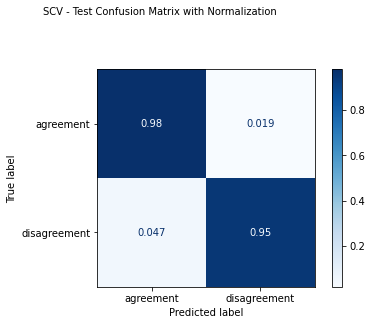

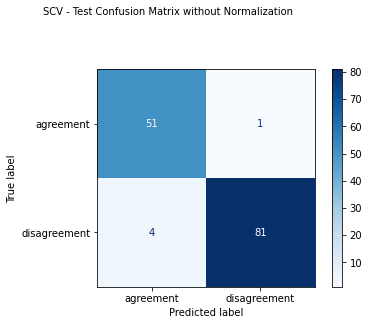

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 36.212s

Best score: 0.709
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        58
           1       0.74      0.93      0.82        69

    accuracy                           0.78       127
   macro avg       0.81      0.77      0.77       127
weighted avg       0.80      0.78      0.77       127

Balanced test accuracy:  0.765


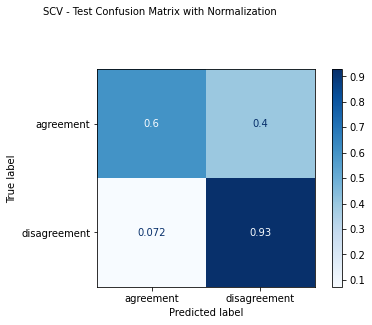

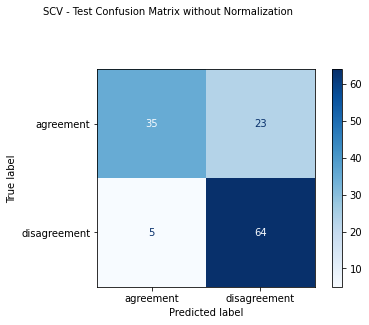

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 47.806s

Best score: 0.860
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.92      0.81      0.86        58
           1       0.86      0.94      0.90        69

    accuracy                           0.88       127
   macro avg       0.89      0.88      0.88       127
weighted avg       0.89      0.88      0.88       127

Balanced test accuracy:  0.876


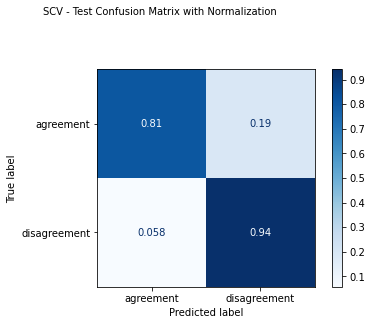

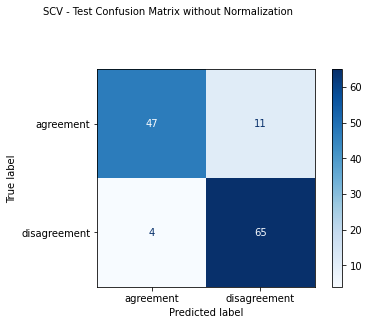

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 56.610s

Best score: 0.876
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.84      0.91        58
           1       0.88      0.99      0.93        69

    accuracy                           0.92       127
   macro avg       0.93      0.92      0.92       127
weighted avg       0.93      0.92      0.92       127

Balanced test accuracy:  0.915


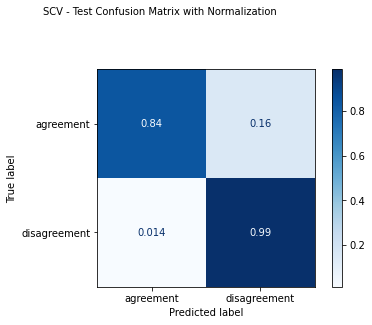

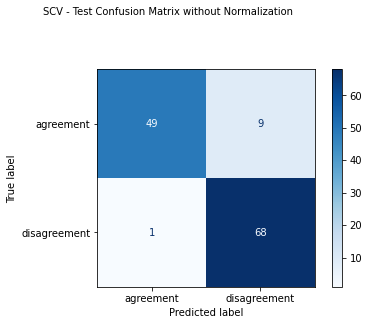

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 65.821s

Best score: 0.860
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.84      0.91        58
           1       0.88      0.99      0.93        69

    accuracy                           0.92       127
   macro avg       0.93      0.92      0.92       127
weighted avg       0.93      0.92      0.92       127

Balanced test accuracy:  0.915


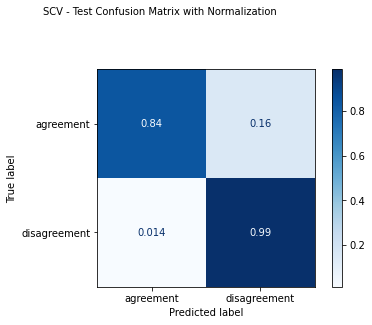

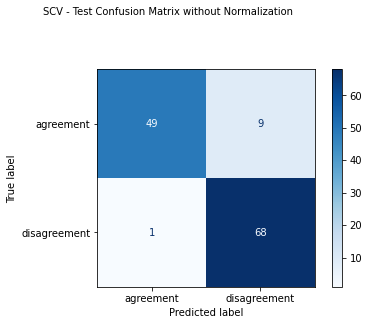

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 35.854s

Best score: 0.586
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.56      0.54      0.55        52
           1       0.67      0.69      0.68        71

    accuracy                           0.63       123
   macro avg       0.62      0.61      0.61       123
weighted avg       0.62      0.63      0.62       123

Balanced test accuracy:  0.614


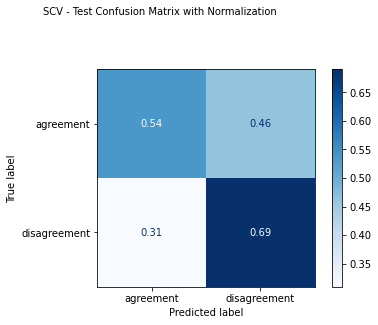

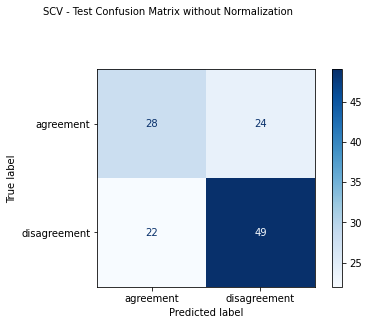

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 46.743s

Best score: 0.842
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.89      0.79      0.84        52
           1       0.86      0.93      0.89        71

    accuracy                           0.87       123
   macro avg       0.87      0.86      0.86       123
weighted avg       0.87      0.87      0.87       123

Balanced test accuracy:  0.859


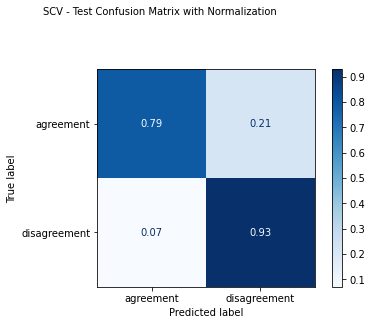

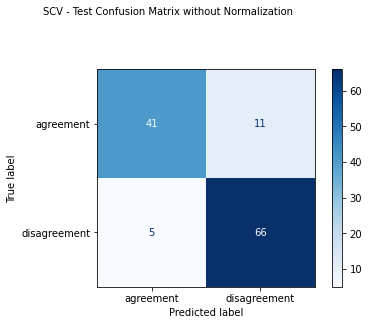

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 55.788s

Best score: 0.863
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        52
           1       0.88      0.93      0.90        71

    accuracy                           0.89       123
   macro avg       0.89      0.88      0.88       123
weighted avg       0.89      0.89      0.89       123

Balanced test accuracy:  0.878


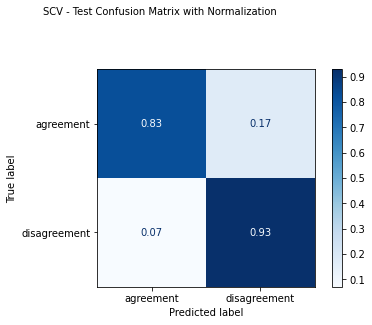

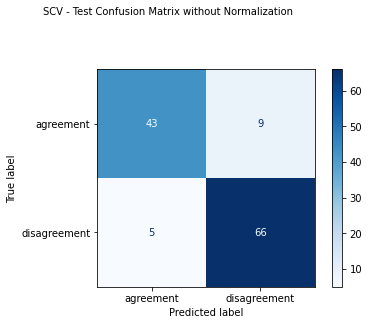

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 65.165s

Best score: 0.861
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        52
           1       0.88      0.94      0.91        71

    accuracy                           0.89       123
   macro avg       0.90      0.89      0.89       123
weighted avg       0.90      0.89      0.89       123

Balanced test accuracy:  0.885


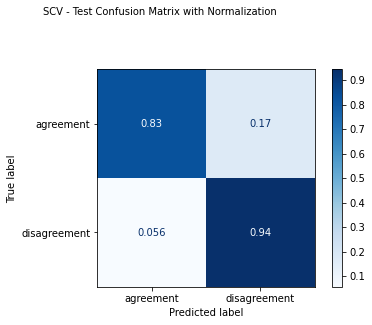

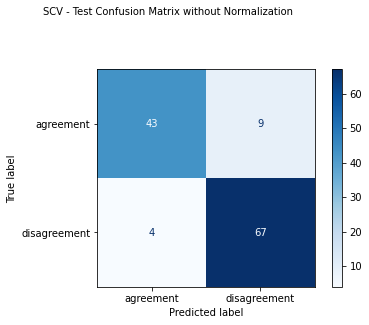

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 33.909s

Best score: 0.629
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.73      0.55      0.62        55
           1       0.69      0.83      0.75        66

    accuracy                           0.70       121
   macro avg       0.71      0.69      0.69       121
weighted avg       0.71      0.70      0.70       121

Balanced test accuracy:  0.689


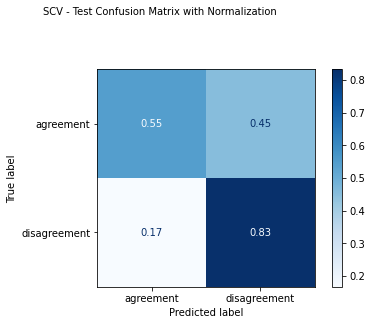

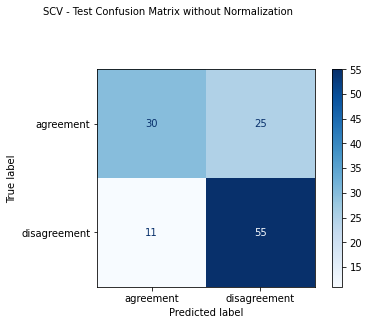

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 44.146s

Best score: 0.834
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        55
           1       0.84      0.95      0.89        66

    accuracy                           0.88       121
   macro avg       0.89      0.87      0.87       121
weighted avg       0.88      0.88      0.87       121

Balanced test accuracy:  0.868


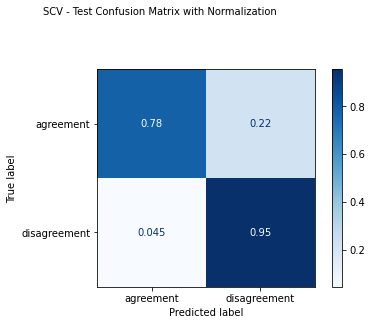

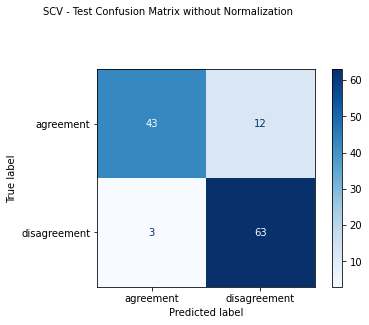

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 51.569s

Best score: 0.867
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.85      0.91        55
           1       0.89      0.98      0.94        66

    accuracy                           0.93       121
   macro avg       0.93      0.92      0.92       121
weighted avg       0.93      0.93      0.92       121

Balanced test accuracy:  0.92


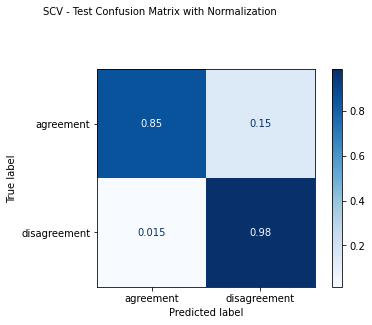

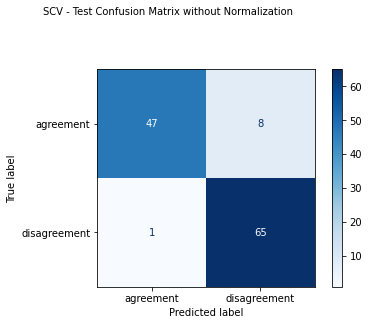

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 58.483s

Best score: 0.875
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.87      0.92        55
           1       0.90      0.98      0.94        66

    accuracy                           0.93       121
   macro avg       0.94      0.93      0.93       121
weighted avg       0.94      0.93      0.93       121

Balanced test accuracy:  0.929


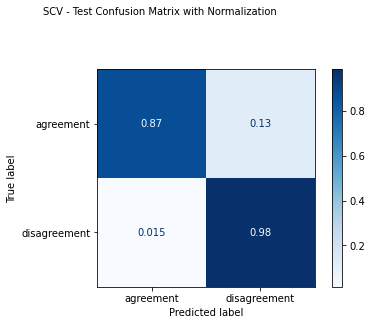

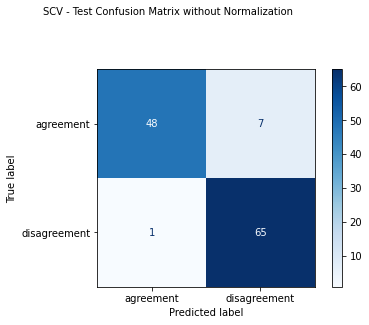

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 33.164s

Best score: 0.691
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.73      0.67      0.70        54
           1       0.75      0.81      0.78        67

    accuracy                           0.74       121
   macro avg       0.74      0.74      0.74       121
weighted avg       0.74      0.74      0.74       121

Balanced test accuracy:  0.736


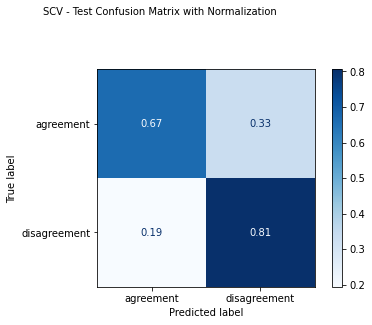

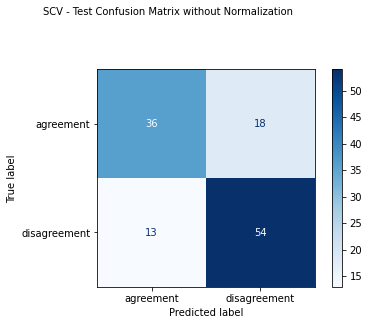

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 42.474s

Best score: 0.819
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        54
           1       0.84      0.96      0.90        67

    accuracy                           0.88       121
   macro avg       0.89      0.87      0.87       121
weighted avg       0.88      0.88      0.87       121

Balanced test accuracy:  0.867


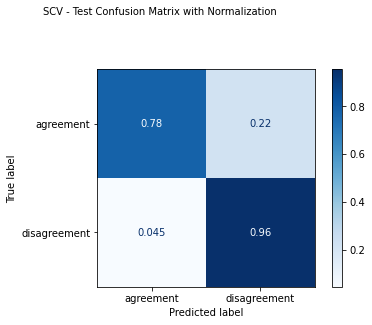

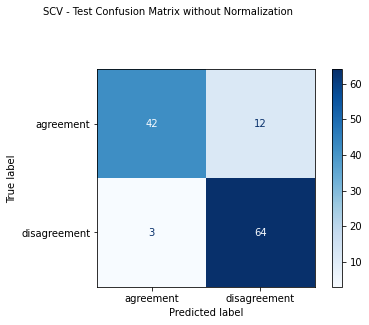

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 50.774s

Best score: 0.852
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        54
           1       0.85      0.96      0.90        67

    accuracy                           0.88       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.89      0.88      0.88       121

Balanced test accuracy:  0.876


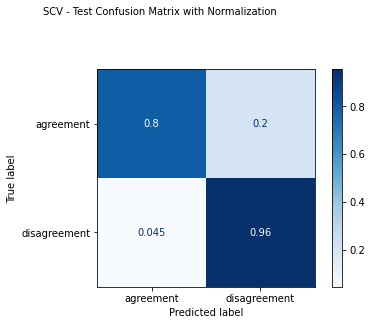

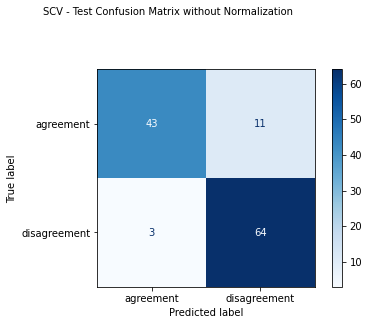

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 58.937s

Best score: 0.867
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        54
           1       0.85      0.96      0.90        67

    accuracy                           0.88       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.89      0.88      0.88       121

Balanced test accuracy:  0.876


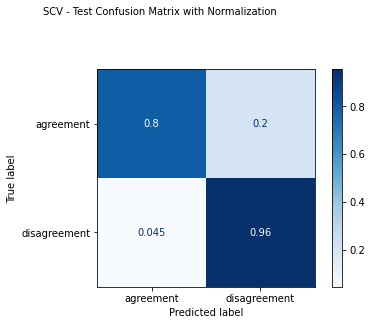

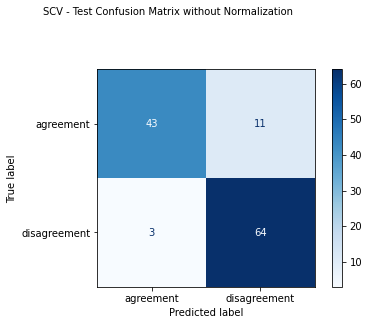

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 34.291s

Best score: 0.742
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.66      0.63      0.65        52
           1       0.72      0.74      0.73        66

    accuracy                           0.69       118
   macro avg       0.69      0.69      0.69       118
weighted avg       0.69      0.69      0.69       118

Balanced test accuracy:  0.689


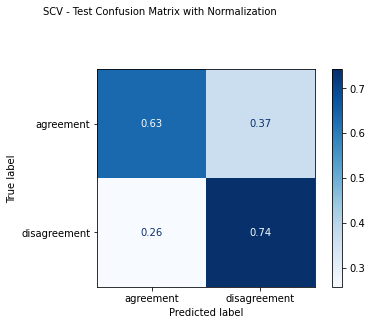

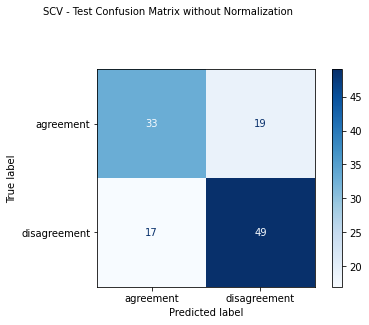

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 45.530s

Best score: 0.763
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.72      0.75      0.74        52
           1       0.80      0.77      0.78        66

    accuracy                           0.76       118
   macro avg       0.76      0.76      0.76       118
weighted avg       0.76      0.76      0.76       118

Balanced test accuracy:  0.761


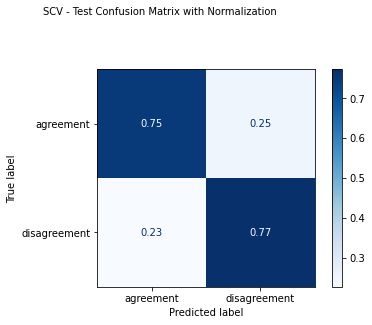

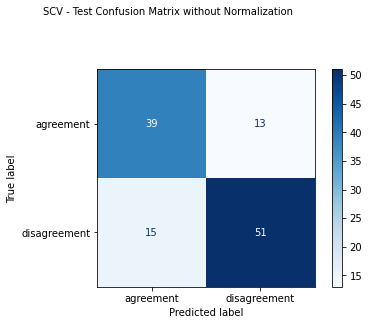

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 54.333s

Best score: 0.761
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        52
           1       0.84      0.80      0.82        66

    accuracy                           0.81       118
   macro avg       0.80      0.81      0.80       118
weighted avg       0.81      0.81      0.81       118

Balanced test accuracy:  0.805


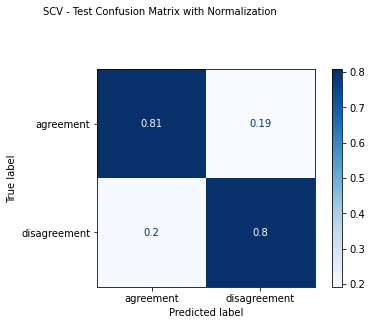

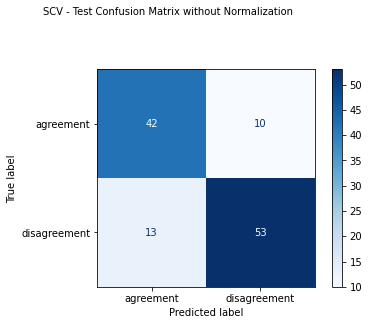

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 63.185s

Best score: 0.757
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        52
           1       0.87      0.80      0.83        66

    accuracy                           0.82       118
   macro avg       0.82      0.82      0.82       118
weighted avg       0.83      0.82      0.82       118

Balanced test accuracy:  0.825


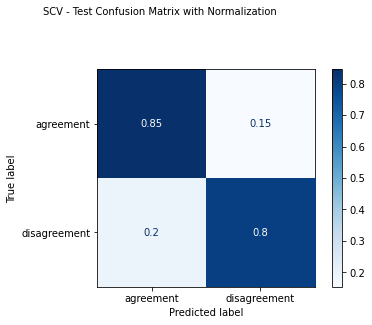

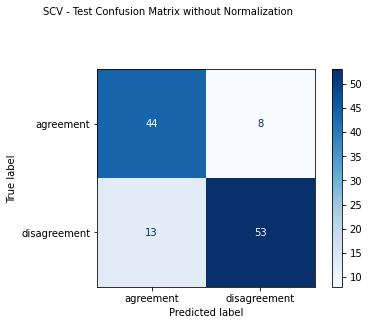

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 40.038s

Best score: 0.649
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.59      0.74      0.66        47
           1       0.79      0.65      0.71        69

    accuracy                           0.69       116
   macro avg       0.69      0.70      0.69       116
weighted avg       0.71      0.69      0.69       116

Balanced test accuracy:  0.698


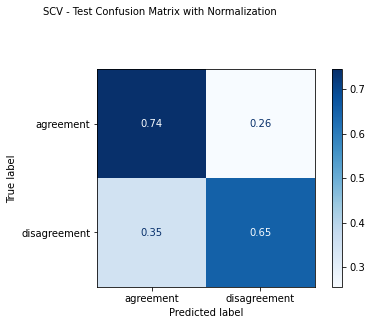

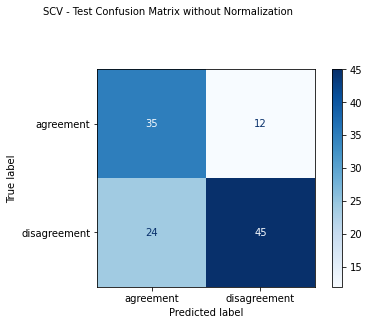

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 51.749s

Best score: 0.748
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.67      0.74      0.71        47
           1       0.81      0.75      0.78        69

    accuracy                           0.75       116
   macro avg       0.74      0.75      0.74       116
weighted avg       0.76      0.75      0.75       116

Balanced test accuracy:  0.749


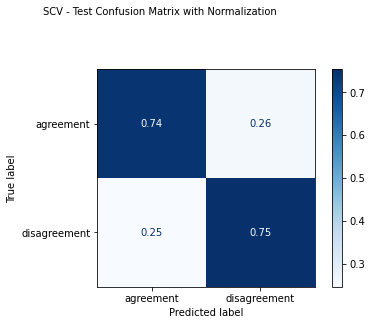

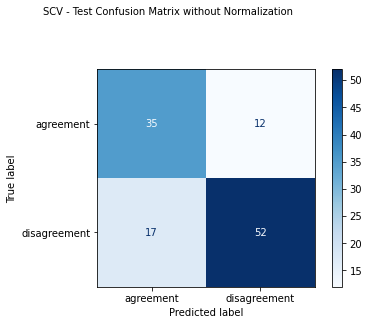

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 62.609s

Best score: 0.762
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.70      0.68      0.69        47
           1       0.79      0.80      0.79        69

    accuracy                           0.75       116
   macro avg       0.74      0.74      0.74       116
weighted avg       0.75      0.75      0.75       116

Balanced test accuracy:  0.739


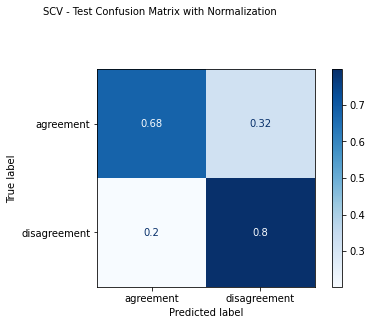

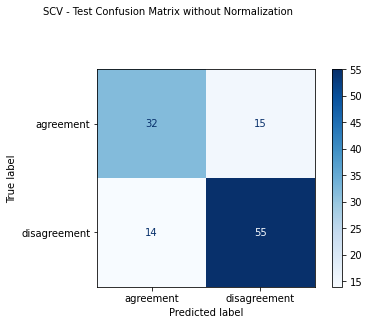

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 73.033s

Best score: 0.775
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.71      0.68      0.70        47
           1       0.79      0.81      0.80        69

    accuracy                           0.76       116
   macro avg       0.75      0.75      0.75       116
weighted avg       0.76      0.76      0.76       116

Balanced test accuracy:  0.746


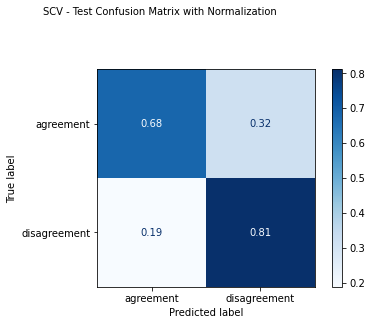

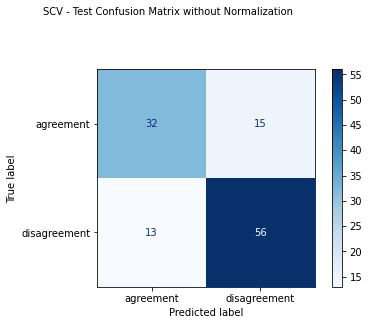

In [ ]:
f1_score_dict_debate_polarity = {}
for topic in toptentopics:
  for nrange in ngramranges:
    df= data_merged.loc[data_merged['topic'] == topic]
    y = df['agreement']
    X= df.drop(columns=['agreement', 'topic'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    labelEncoder = preprocessing.LabelEncoder()
    labelEncoder.fit(["disagreement", "agreement"])
    y_train= labelEncoder.transform(y_train)
    y_test= labelEncoder.transform(y_test)
   

    print(f'CREATING MODEL FOR TOPIC: "{topic}" WITH N-GRAMS RANGE {nrange} WITH POLARITY SCORE \n')
    preprocessor = ColumnTransformer(
        transformers= [
                       ('debate', TfidfVectorizer(tokenizer= tokenizer, ngram_range= nrange, use_idf= True), 'debate'), 
                       ('polarity', 'passthrough', ['polarity_score'])
        ],
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf',  SVC()),
    ])

    parameters = {'clf__kernel': ['linear', 'rbf'], 'clf__gamma': [1e-3, 1e-4],
                        'clf__C': [0.1, 1, 10, 100]
    }

    model_svc= gridsearch(pipeline=pipeline, parameters=parameters, X_train= X_train, y_train= y_train)
    save_model(modelname= 'SVC_fullDebate_polarity', topic= topic, ngramrange=nrange, model= model_svc, separated = False)
    modelname= f'svm_{topic}_{nrange}'
    f1_score_dict_debate_polarity[modelname]= f1_score(y_test, y_pred = model_svc.predict(X_test), average='weighted')
    modelevaluation(model_svc, X_test, y_test)
    confusionMatrix (model=model_svc, modelname= 'SCV', X_test=X_test, y_test=y_test)

In [ ]:
f1_score_df_debate_polarity= pd.DataFrame.from_dict(f1_score_dict_debate_polarity, orient='index', columns= ['f1_score'])
f1_score_df_debate_polarity

f1_score
svm_animal_(1, 1)        0.749916
svm_animal_(1, 2)        0.881853
svm_animal_(1, 3)        0.906235
svm_animal_(1, 4)        0.902745
svm_energy_(1, 1)        0.713426
svm_energy_(1, 2)        0.795814
svm_energy_(1, 3)        0.797114
svm_energy_(1, 4)        0.783784
svm_health_(1, 1)        0.692505
svm_health_(1, 2)        0.843243
svm_health_(1, 3)        0.877635
svm_health_(1, 4)        0.882621
svm_circumcision_(1, 1)  0.903000
svm_circumcision_(1, 2)  0.970803
svm_circumcision_(1, 3)  0.970803
svm_circumcision_(1, 4)  0.963687
svm_weapon_(1, 1)        0.772000
svm_weapon_(1, 2)        0.880948
svm_weapon_(1, 3)        0.920501
svm_weapon_(1, 4)        0.920501
svm_death_(1, 1)         0.624947
svm_death_(1, 2)         0.868573
svm_death_(1, 3)         0.885462
svm_death_(1, 4)         0.893437
svm_marijuana_(1, 1)     0.695050
svm_marijuana_(1, 2)     0.874466
svm_marijuana_(1, 3)     0.924965
svm_marijuana_(1, 4)     0.933414
svm_punishment_(1, 1)    0.742191
svm_punishment_(1, 2)    0.874299
svm_punishment_(1, 3)    0.882929
svm_punishment_(1, 4)    0.882929
svm_tax_(1, 1)           0.694201
svm_tax_(1, 2)           0.763125
svm_tax_(1, 3)           0.805551
svm_tax_(1, 4)           0.822612
svm_life_(1, 1)          0.692444
svm_life_(1, 2)          0.751614
svm_life_(1, 3)          0.749555
svm_life_(1, 4)          0.757721

## Models with split Debate

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 89.106s

Best score: 0.909
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       150
           1       0.88      0.94      0.91       138

    accuracy                           0.91       288
   macro avg       0.91      0.91      0.91       288
weighted avg       0.91      0.91      0.91       288

Balanced test accuracy:  0.911


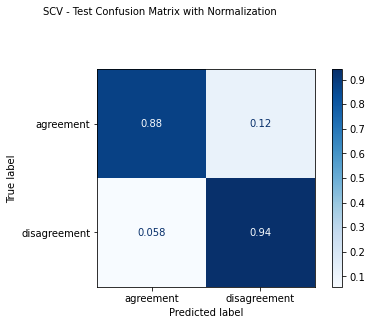

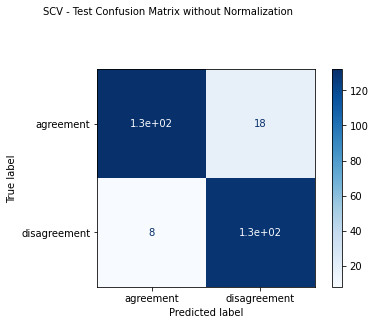

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 118.728s

Best score: 0.902
Best parameters set:
	clf__C: 100
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.88      0.92       150
           1       0.88      0.96      0.92       138

    accuracy                           0.92       288
   macro avg       0.92      0.92      0.92       288
weighted avg       0.92      0.92      0.92       288

Balanced test accuracy:  0.918


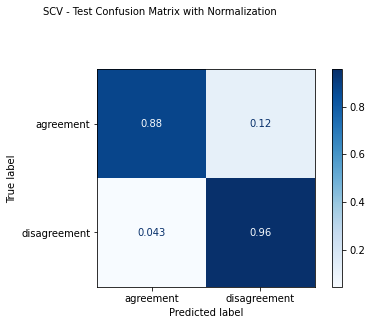

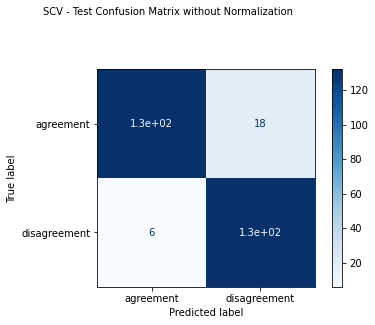

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 141.445s

Best score: 0.903
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       150
           1       0.86      0.96      0.90       138

    accuracy                           0.90       288
   macro avg       0.91      0.90      0.90       288
weighted avg       0.91      0.90      0.90       288

Balanced test accuracy:  0.905


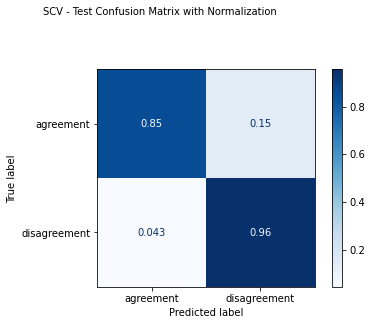

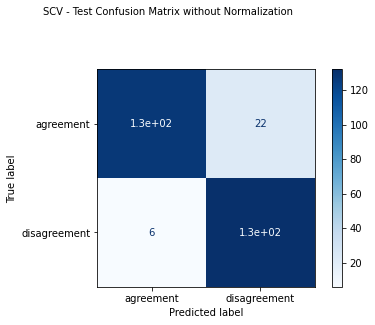

CREATING MODEL FOR TOPIC: "animal" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 163.147s

Best score: 0.905
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.85      0.90       150
           1       0.86      0.96      0.90       138

    accuracy                           0.90       288
   macro avg       0.91      0.90      0.90       288
weighted avg       0.91      0.90      0.90       288

Balanced test accuracy:  0.905


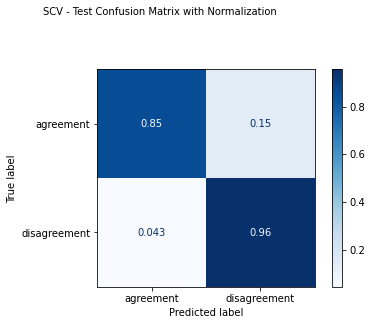

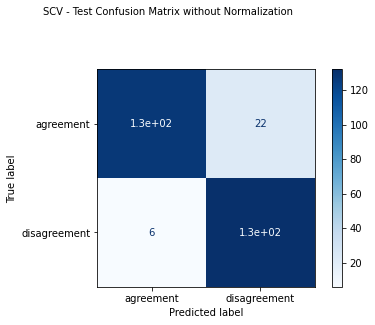

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 82.283s

Best score: 0.830
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        90
           1       0.92      0.93      0.92       132

    accuracy                           0.91       222
   macro avg       0.91      0.90      0.91       222
weighted avg       0.91      0.91      0.91       222

Balanced test accuracy:  0.905


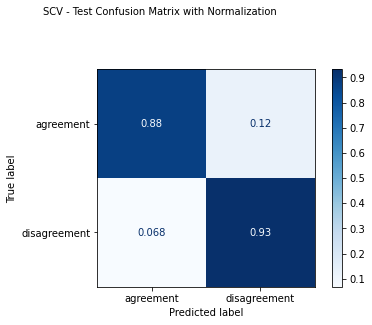

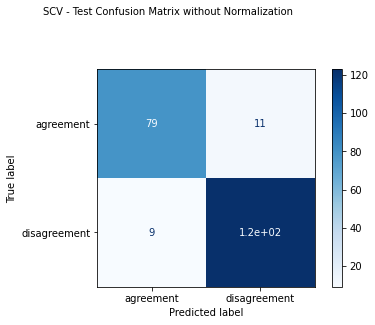

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 109.774s

Best score: 0.831
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        90
           1       0.91      0.92      0.92       132

    accuracy                           0.90       222
   macro avg       0.90      0.90      0.90       222
weighted avg       0.90      0.90      0.90       222

Balanced test accuracy:  0.895


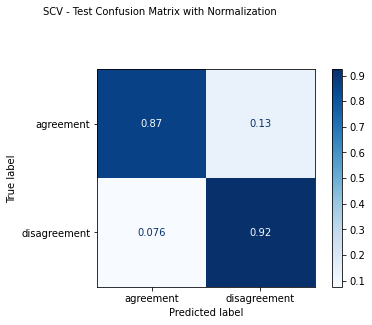

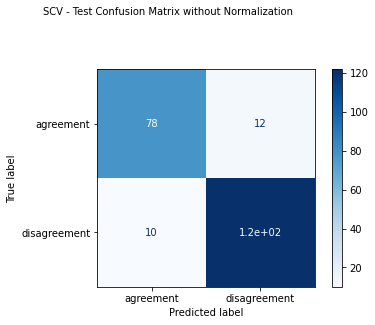

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 133.141s

Best score: 0.823
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        90
           1       0.91      0.92      0.92       132

    accuracy                           0.90       222
   macro avg       0.90      0.90      0.90       222
weighted avg       0.90      0.90      0.90       222

Balanced test accuracy:  0.895


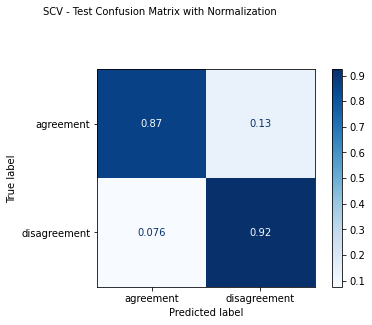

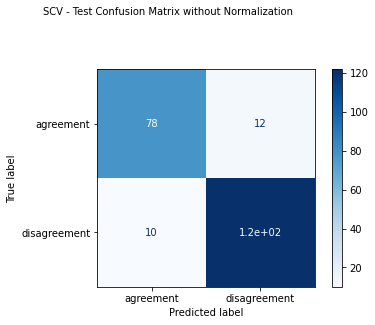

CREATING MODEL FOR TOPIC: "energy" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 156.507s

Best score: 0.822
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        90
           1       0.91      0.93      0.92       132

    accuracy                           0.91       222
   macro avg       0.90      0.90      0.90       222
weighted avg       0.91      0.91      0.91       222

Balanced test accuracy:  0.899


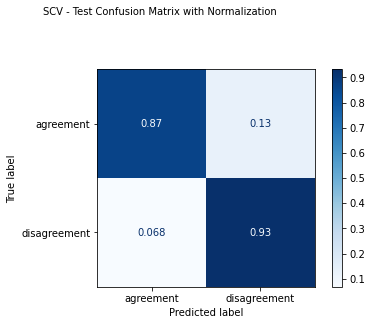

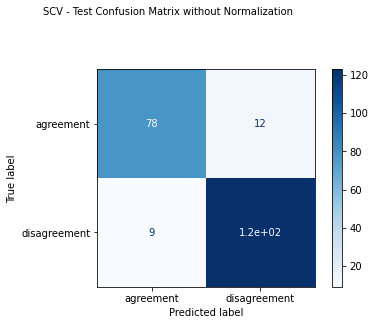

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 77.782s

Best score: 0.855
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        91
           1       0.90      0.94      0.92       114

    accuracy                           0.91       205
   macro avg       0.91      0.90      0.91       205
weighted avg       0.91      0.91      0.91       205

Balanced test accuracy:  0.903


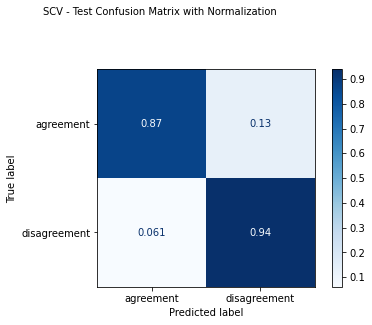

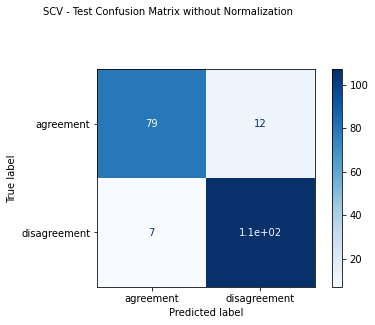

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 103.327s

Best score: 0.853
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        91
           1       0.91      0.96      0.93       114

    accuracy                           0.92       205
   macro avg       0.92      0.92      0.92       205
weighted avg       0.92      0.92      0.92       205

Balanced test accuracy:  0.918


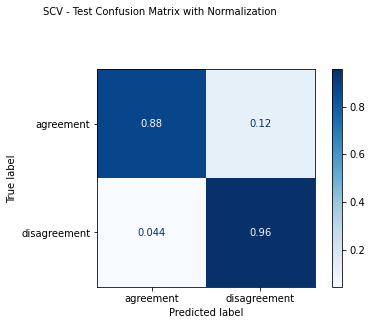

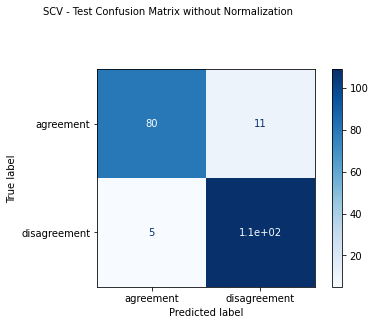

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 126.579s

Best score: 0.852
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        91
           1       0.91      0.96      0.93       114

    accuracy                           0.92       205
   macro avg       0.92      0.92      0.92       205
weighted avg       0.92      0.92      0.92       205

Balanced test accuracy:  0.918


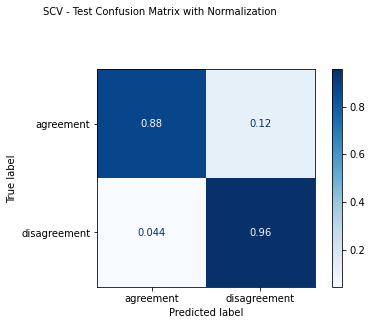

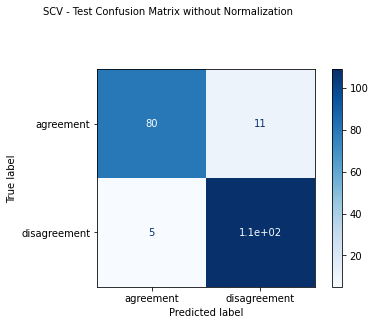

CREATING MODEL FOR TOPIC: "health" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 148.048s

Best score: 0.847
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.94      0.88      0.91        91
           1       0.91      0.96      0.93       114

    accuracy                           0.92       205
   macro avg       0.92      0.92      0.92       205
weighted avg       0.92      0.92      0.92       205

Balanced test accuracy:  0.918


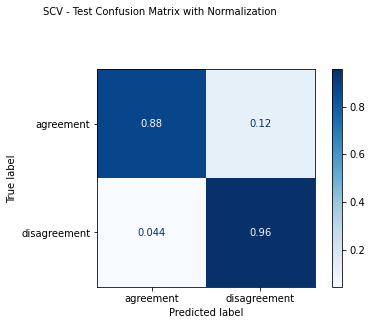

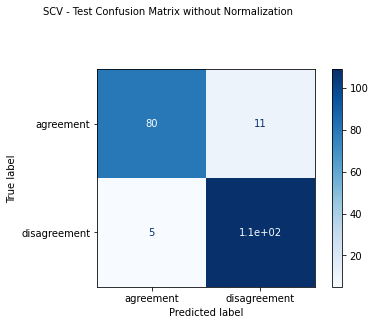

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 36.856s

Best score: 0.972
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        85

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137

Balanced test accuracy:  1.0


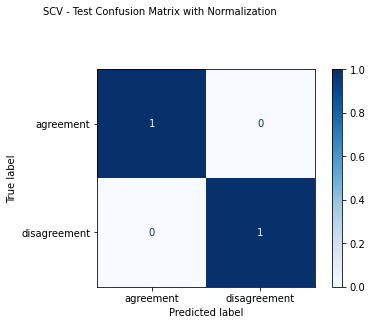

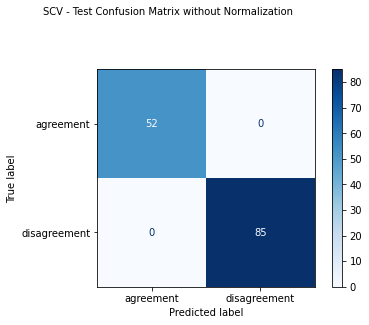

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 46.128s

Best score: 0.972
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        85

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137

Balanced test accuracy:  1.0


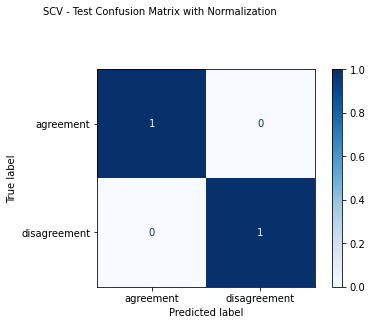

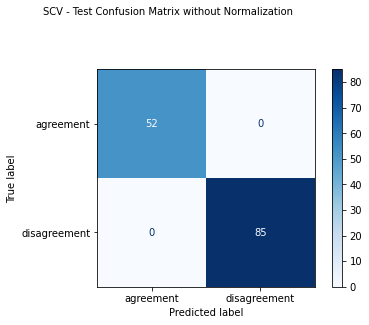

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 53.553s

Best score: 0.972
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        85

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137

Balanced test accuracy:  1.0


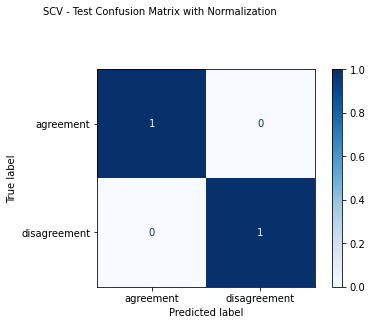

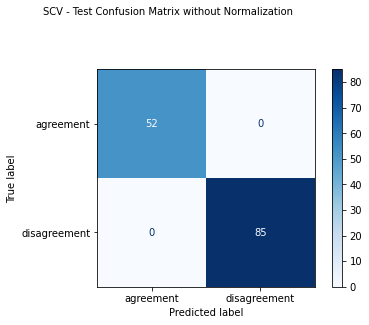

CREATING MODEL FOR TOPIC: "circumcision" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 60.191s

Best score: 0.978
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        85

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137

Balanced test accuracy:  1.0


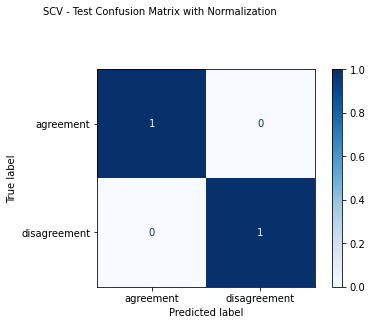

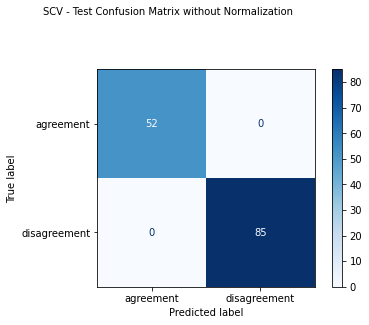

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 37.839s

Best score: 0.931
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.86      0.93        58
           1       0.90      1.00      0.95        69

    accuracy                           0.94       127
   macro avg       0.95      0.93      0.94       127
weighted avg       0.94      0.94      0.94       127

Balanced test accuracy:  0.931


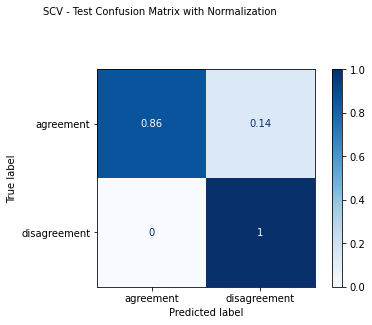

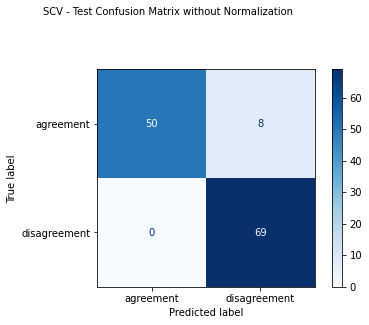

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 48.114s

Best score: 0.929
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.92        58
           1       0.88      1.00      0.94        69

    accuracy                           0.93       127
   macro avg       0.94      0.92      0.93       127
weighted avg       0.94      0.93      0.93       127

Balanced test accuracy:  0.922


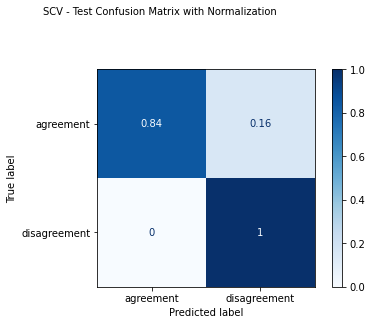

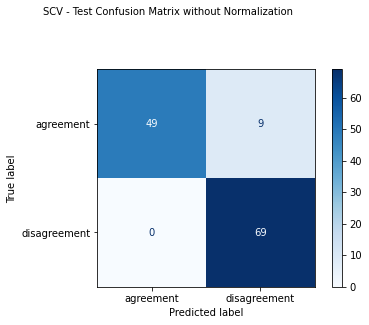

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 57.132s

Best score: 0.925
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.92        58
           1       0.88      1.00      0.94        69

    accuracy                           0.93       127
   macro avg       0.94      0.92      0.93       127
weighted avg       0.94      0.93      0.93       127

Balanced test accuracy:  0.922


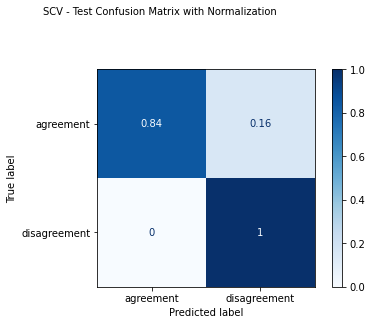

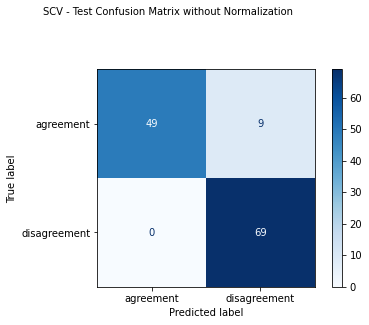

CREATING MODEL FOR TOPIC: "weapon" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 66.248s

Best score: 0.925
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.92        58
           1       0.88      1.00      0.94        69

    accuracy                           0.93       127
   macro avg       0.94      0.92      0.93       127
weighted avg       0.94      0.93      0.93       127

Balanced test accuracy:  0.922


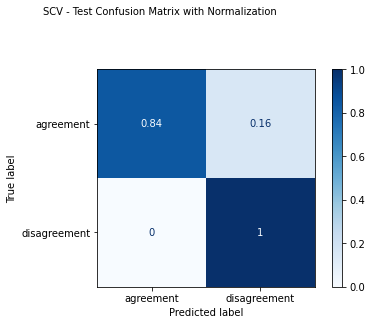

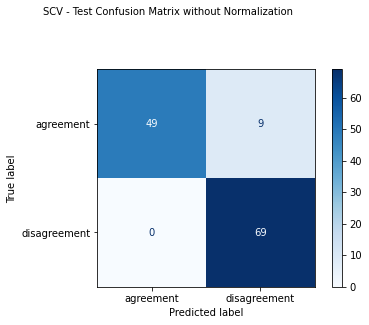

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 36.888s

Best score: 0.916
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.85      0.90        52
           1       0.90      0.97      0.93        71

    accuracy                           0.92       123
   macro avg       0.93      0.91      0.92       123
weighted avg       0.92      0.92      0.92       123

Balanced test accuracy:  0.909


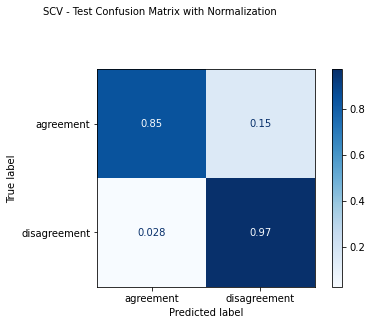

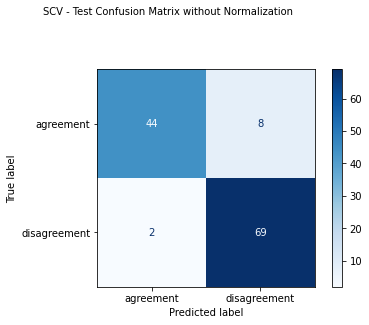

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 47.101s

Best score: 0.922
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        52
           1       0.88      0.97      0.93        71

    accuracy                           0.91       123
   macro avg       0.92      0.90      0.91       123
weighted avg       0.91      0.91      0.91       123

Balanced test accuracy:  0.899


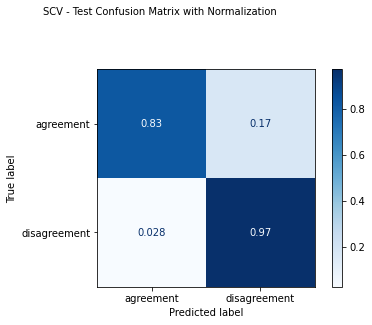

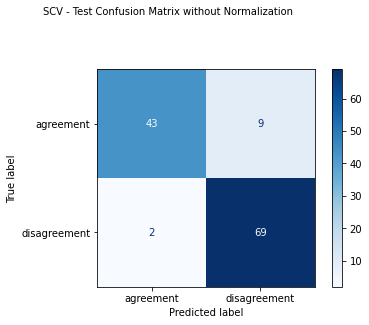

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 55.440s

Best score: 0.922
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        52
           1       0.88      0.97      0.93        71

    accuracy                           0.91       123
   macro avg       0.92      0.90      0.91       123
weighted avg       0.91      0.91      0.91       123

Balanced test accuracy:  0.899


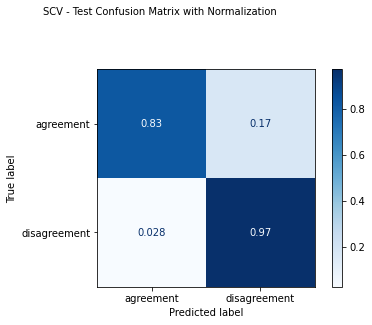

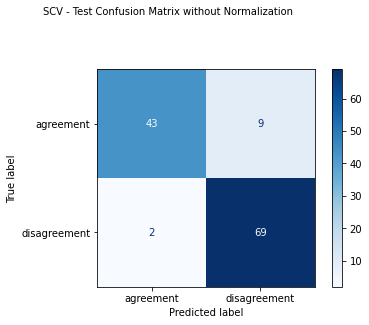

CREATING MODEL FOR TOPIC: "death" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 63.696s

Best score: 0.924
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.83      0.89        52
           1       0.88      0.97      0.93        71

    accuracy                           0.91       123
   macro avg       0.92      0.90      0.91       123
weighted avg       0.91      0.91      0.91       123

Balanced test accuracy:  0.899


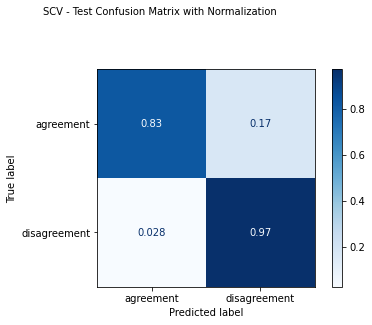

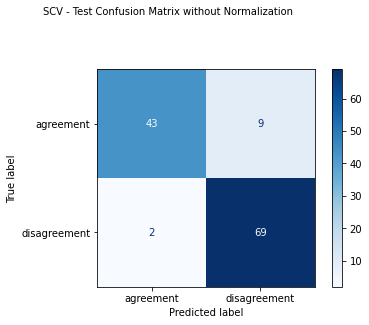

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 34.857s

Best score: 0.928
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        55
           1       0.97      0.98      0.98        66

    accuracy                           0.98       121
   macro avg       0.98      0.97      0.97       121
weighted avg       0.98      0.98      0.98       121

Balanced test accuracy:  0.974


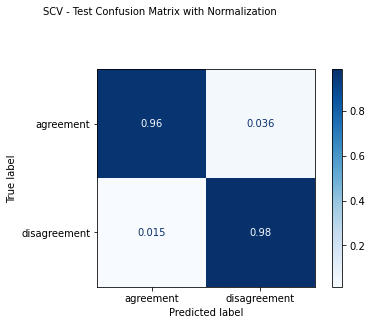

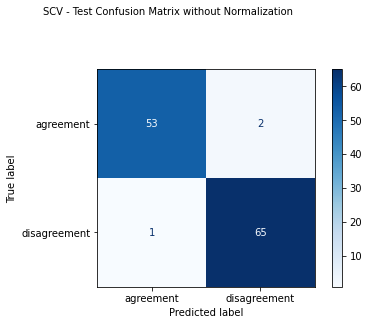

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 44.147s

Best score: 0.930
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        55
           1       0.97      0.98      0.98        66

    accuracy                           0.98       121
   macro avg       0.98      0.97      0.97       121
weighted avg       0.98      0.98      0.98       121

Balanced test accuracy:  0.974


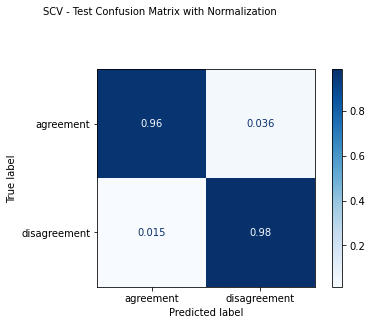

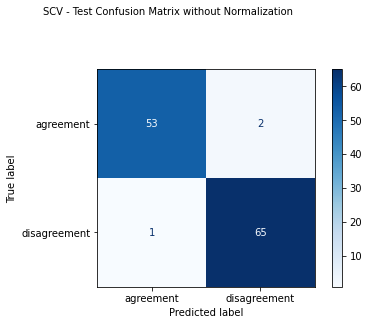

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 51.614s

Best score: 0.926
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        55
           1       0.97      0.98      0.98        66

    accuracy                           0.98       121
   macro avg       0.98      0.97      0.97       121
weighted avg       0.98      0.98      0.98       121

Balanced test accuracy:  0.974


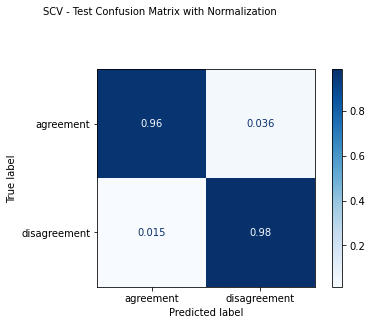

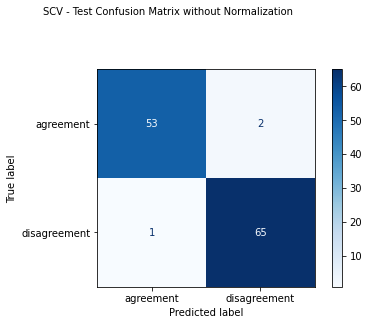

CREATING MODEL FOR TOPIC: "marijuana" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 59.920s

Best score: 0.930
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        55
           1       0.97      0.98      0.98        66

    accuracy                           0.98       121
   macro avg       0.98      0.97      0.97       121
weighted avg       0.98      0.98      0.98       121

Balanced test accuracy:  0.974


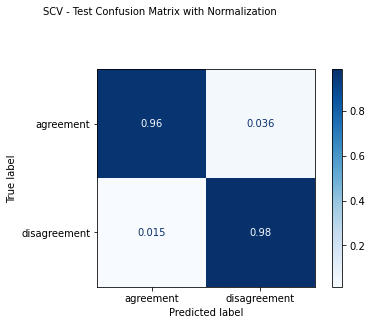

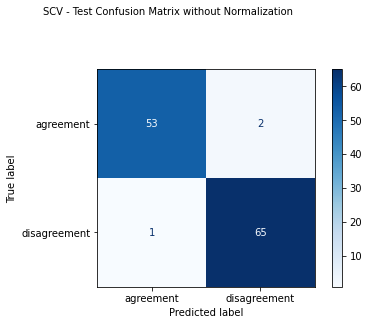

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 34.662s

Best score: 0.902
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        54
           1       0.85      0.96      0.90        67

    accuracy                           0.88       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.89      0.88      0.88       121

Balanced test accuracy:  0.876


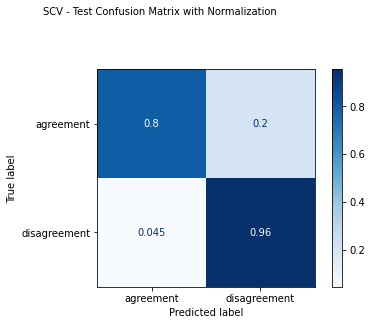

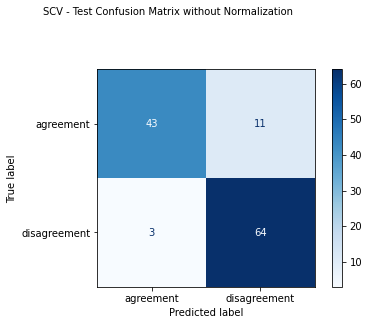

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 43.700s

Best score: 0.908
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        54
           1       0.85      0.96      0.90        67

    accuracy                           0.88       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.89      0.88      0.88       121

Balanced test accuracy:  0.876


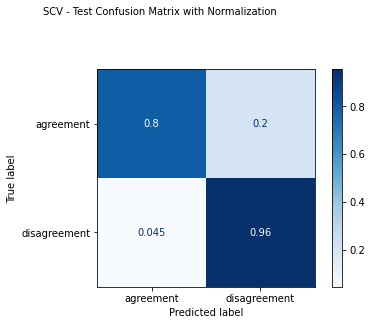

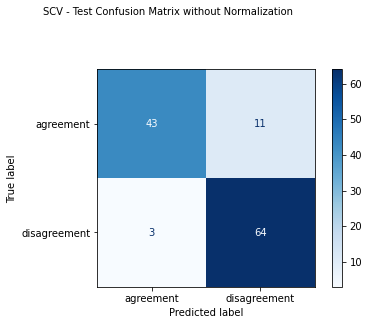

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 51.996s

Best score: 0.908
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        54
           1       0.85      0.96      0.90        67

    accuracy                           0.88       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.89      0.88      0.88       121

Balanced test accuracy:  0.876


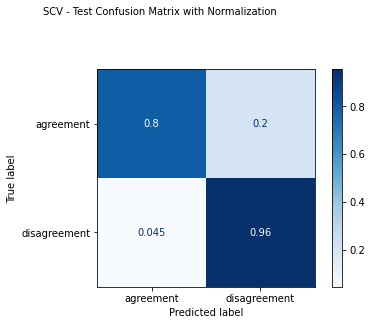

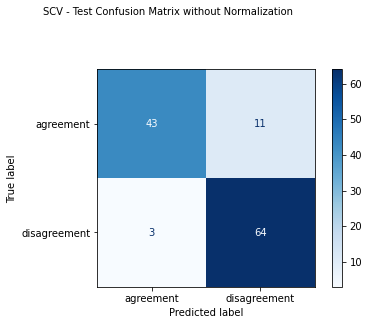

CREATING MODEL FOR TOPIC: "punishment" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 59.538s

Best score: 0.904
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.80      0.86        54
           1       0.85      0.96      0.90        67

    accuracy                           0.88       121
   macro avg       0.89      0.88      0.88       121
weighted avg       0.89      0.88      0.88       121

Balanced test accuracy:  0.876


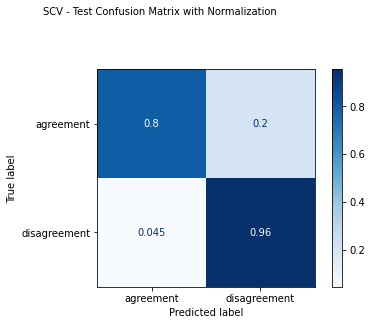

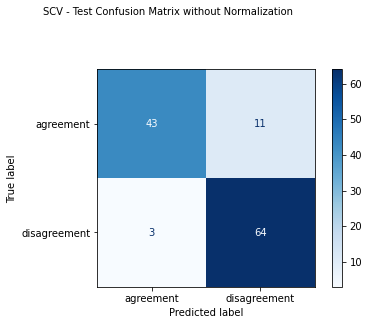

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 36.083s

Best score: 0.844
Best parameters set:
	clf__C: 1
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.83      0.92      0.87        52
           1       0.93      0.85      0.89        66

    accuracy                           0.88       118
   macro avg       0.88      0.89      0.88       118
weighted avg       0.89      0.88      0.88       118

Balanced test accuracy:  0.886


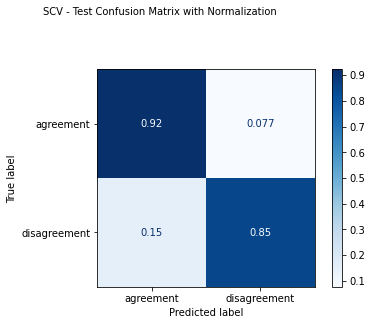

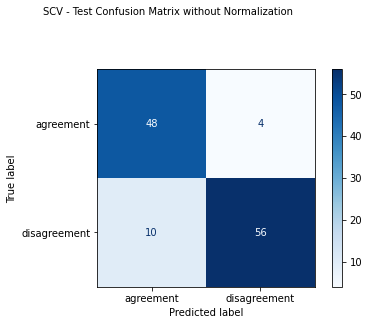

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 46.106s

Best score: 0.852
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        52
           1       0.94      0.88      0.91        66

    accuracy                           0.90       118
   macro avg       0.90      0.90      0.90       118
weighted avg       0.90      0.90      0.90       118

Balanced test accuracy:  0.901


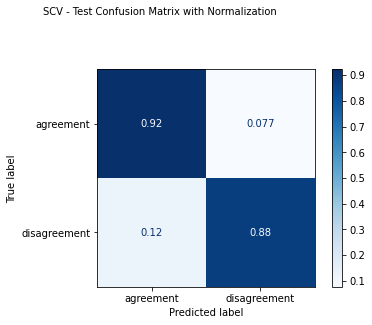

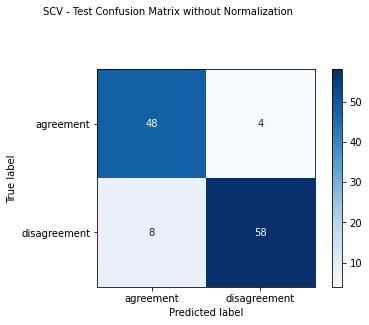

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 55.244s

Best score: 0.857
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        52
           1       0.94      0.88      0.91        66

    accuracy                           0.90       118
   macro avg       0.90      0.90      0.90       118
weighted avg       0.90      0.90      0.90       118

Balanced test accuracy:  0.901


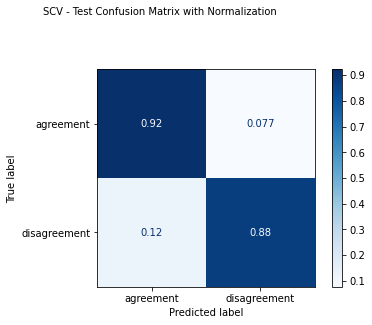

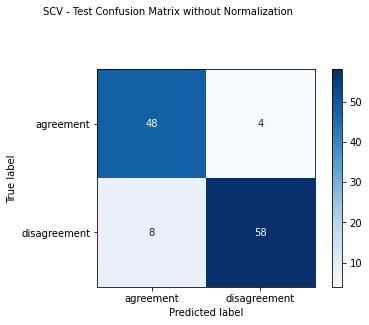

CREATING MODEL FOR TOPIC: "tax" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 63.908s

Best score: 0.850
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        52
           1       0.94      0.91      0.92        66

    accuracy                           0.92       118
   macro avg       0.91      0.92      0.91       118
weighted avg       0.92      0.92      0.92       118

Balanced test accuracy:  0.916


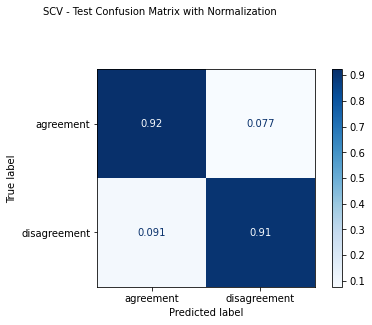

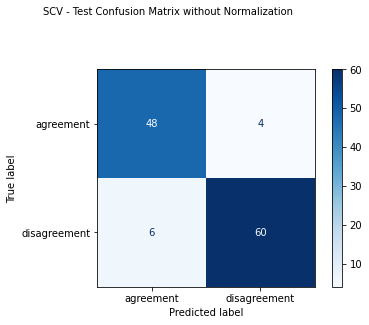

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 1) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 40.385s

Best score: 0.840
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.85      0.94      0.89        47
           1       0.95      0.88      0.92        69

    accuracy                           0.91       116
   macro avg       0.90      0.91      0.90       116
weighted avg       0.91      0.91      0.91       116

Balanced test accuracy:  0.91


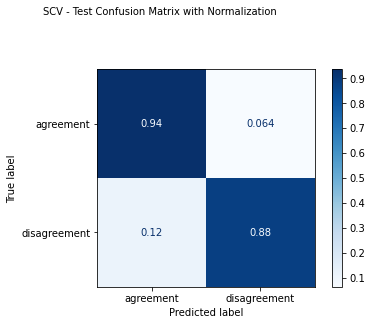

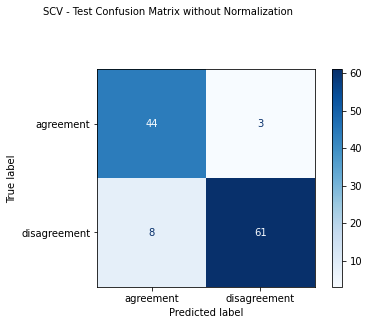

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 2) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 52.366s

Best score: 0.844
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        47
           1       0.94      0.90      0.92        69

    accuracy                           0.91       116
   macro avg       0.90      0.91      0.90       116
weighted avg       0.91      0.91      0.91       116

Balanced test accuracy:  0.907


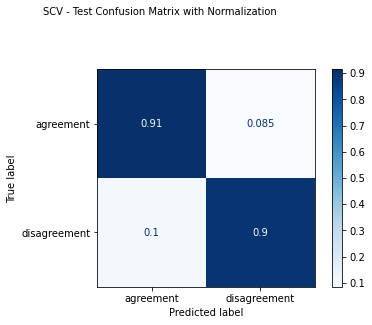

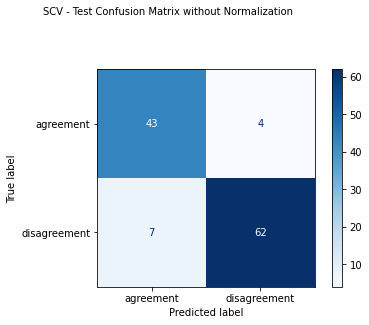

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 3) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 63.666s

Best score: 0.840
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.86      0.91      0.89        47
           1       0.94      0.90      0.92        69

    accuracy                           0.91       116
   macro avg       0.90      0.91      0.90       116
weighted avg       0.91      0.91      0.91       116

Balanced test accuracy:  0.907


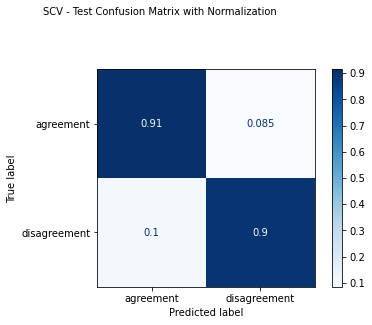

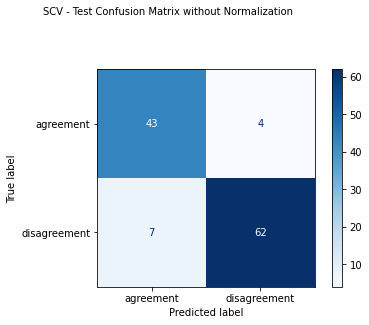

CREATING MODEL FOR TOPIC: "life" WITH N-GRAMS RANGE (1, 4) WITH POLARITY SCORE 

Performing grid search...
pipeline: ['preprocessor', 'clf']
parameters: 

{'clf__C': [0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.0001],
 'clf__kernel': ['linear', 'rbf']}
Executed in 76.460s

Best score: 0.836
Best parameters set:
	clf__C: 10
	clf__gamma: 0.001
	clf__kernel: 'linear'
Test Classification Report
              precision    recall  f1-score   support

           0       0.84      0.91      0.88        47
           1       0.94      0.88      0.91        69

    accuracy                           0.90       116
   macro avg       0.89      0.90      0.89       116
weighted avg       0.90      0.90      0.90       116

Balanced test accuracy:  0.899


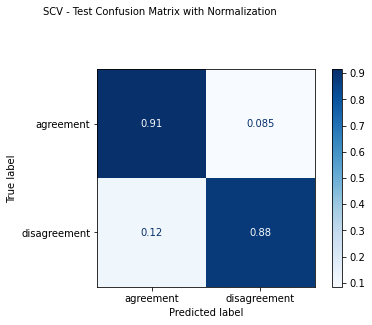

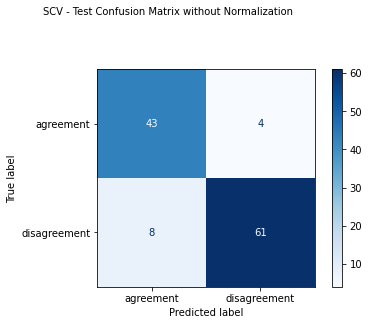

In [21]:
f1_score_dict_debate_split_polarity = {}
for topic in toptentopics:
  for nrange in ngramranges:
    df= data_separated.loc[data_separated['topic'] == topic]
    y = df['agreement']
    X= df.drop(columns=['agreement', 'topic'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    labelEncoder = preprocessing.LabelEncoder()
    labelEncoder.fit(["disagreement", "agreement"])
    y_train= labelEncoder.transform(y_train)
    y_test= labelEncoder.transform(y_test)
    

    print(f'CREATING MODEL FOR TOPIC: "{topic}" WITH N-GRAMS RANGE {nrange} WITH POLARITY SCORE \n')
    preprocessor = ColumnTransformer(
        transformers= [
                       ('pos1', TfidfVectorizer(tokenizer= tokenizer, ngram_range= nrange, use_idf= True), 'position1_cleaned'), 
                       ('pos2', TfidfVectorizer(tokenizer= tokenizer, ngram_range= nrange, use_idf= True), 'position2_cleaned'),
                       ('polarity1', 'passthrough', ['polarity_score_1']),
                       ('polarity2', 'passthrough', ['polarity_score_2'])
        ],
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('clf',  SVC()),
    ])

    parameters = {'clf__kernel': ['linear', 'rbf'], 'clf__gamma': [1e-3, 1e-4],
                        'clf__C': [0.1, 1, 10, 100]
    }

    model_svc= gridsearch(pipeline=pipeline, parameters=parameters, X_train= X_train, y_train= y_train)
    save_model(modelname= 'SVC_splitDebate_polarity', topic= topic, ngramrange=nrange, model= model_svc, separated = False)
    modelname= f'svm_{topic}_{nrange}'
    f1_score_dict_debate_split_polarity[modelname]= f1_score(y_test, y_pred = model_svc.predict(X_test), average='weighted')
    modelevaluation(model_svc, X_test, y_test)
    confusionMatrix (model=model_svc, modelname= 'SCV', X_test=X_test, y_test=y_test)

In [24]:
f1_score_df_debate_split_polarity= pd.DataFrame.from_dict(f1_score_dict_debate_split_polarity, orient='index', columns= ['f1_score'])
f1_score_df_debate_split_polarity

f1_score
svm_animal_(1, 1)        0.909744
svm_animal_(1, 2)        0.916667
svm_animal_(1, 3)        0.902703
svm_animal_(1, 4)        0.902703
svm_energy_(1, 1)        0.909742
svm_energy_(1, 2)        0.900717
svm_energy_(1, 3)        0.900717
svm_energy_(1, 4)        0.905135
svm_health_(1, 1)        0.907002
svm_health_(1, 2)        0.921621
svm_health_(1, 3)        0.921621
svm_health_(1, 4)        0.921621
svm_circumcision_(1, 1)  1.000000
svm_circumcision_(1, 2)  1.000000
svm_circumcision_(1, 3)  1.000000
svm_circumcision_(1, 4)  1.000000
svm_weapon_(1, 1)        0.936401
svm_weapon_(1, 2)        0.928323
svm_weapon_(1, 3)        0.928323
svm_weapon_(1, 4)        0.928323
svm_death_(1, 1)         0.917858
svm_death_(1, 2)         0.909443
svm_death_(1, 3)         0.909443
svm_death_(1, 4)         0.909443
svm_marijuana_(1, 1)     0.975186
svm_marijuana_(1, 2)     0.975186
svm_marijuana_(1, 3)     0.975186
svm_marijuana_(1, 4)     0.975186
svm_punishment_(1, 1)    0.882929
svm_punishment_(1, 2)    0.882929
svm_punishment_(1, 3)    0.882929
svm_punishment_(1, 4)    0.882929
svm_tax_(1, 1)           0.881767
svm_tax_(1, 2)           0.898599
svm_tax_(1, 3)           0.898599
svm_tax_(1, 4)           0.915402
svm_life_(1, 1)          0.905785
svm_life_(1, 2)          0.905585
svm_life_(1, 3)          0.905585
svm_life_(1, 4)          0.897119

# NeuralNetwork model without polarity score
In this section I explore the use of a neural network model, that exploits word embeddings to create a model that is capable of classifying the entire dataet, instead of making a distinction between topics. For this reason I use NN since they are better suited to work with big amount of data, unlike SVM models that work better with small amounts of data as they were used when considering topics singularly

## NeuralNetwork model - complete Debate

Split data

In [ ]:
y = data_merged['agreement']
X= data_merged.drop(columns=['agreement', 'topic', 'polarity_score'], axis=1)
X_train_debate, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Encode labels

In [ ]:
labelEncoder = preprocessing.LabelEncoder()
labelEncoder.fit(["disagreement", "agreement"])

LabelEncoder()

In [ ]:
y_train= labelEncoder.transform(y_train)
y_test= labelEncoder.transform(y_test)

Prepare data and build model

In [ ]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer_nn= Tokenizer()
tokenizer_nn.fit_on_texts(X_train_debate['debate'])


vocab_size = len(tokenizer_nn.word_index) + 1

#add padding to shorter sequences
max_length = max([len(s.split()) for s in X_train_debate['debate']])
X_train_padded = pad_sequences(tokenizer_nn.texts_to_sequences(X_train_debate['debate']), maxlen= max_length, padding = 'post')
X_test_padded = pad_sequences(tokenizer_nn.texts_to_sequences(X_test['debate']), maxlen= max_length, padding = 'post')

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import one_hot



model = Sequential()
model.add(Embedding(input_dim= vocab_size, output_dim = 100, input_length=max_length)) 
model.add(Flatten()) 
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())


model.fit(X_train_padded, y_train, batch_size=128, epochs=30, verbose=0, validation_split= 0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 555, 100)          2518300   
_________________________________________________________________
flatten (Flatten)            (None, 55500)             0         
_________________________________________________________________
dropout (Dropout)            (None, 55500)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 55501     
Total params: 2,573,801
Trainable params: 2,573,801
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#training accuracy
train_loss, train_accuracy = model.evaluate(X_train_padded, y_train, verbose=0)
print('Train Accuracy: %f' % (train_accuracy*100))
#test accuracy
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print('Test Accuracy: %f' % (test_accuracy*100))

Train Accuracy: 96.349645
Test Accuracy: 83.005643


Evaluate results

In [ ]:
from sklearn import metrics
def plot_nn_confusion_matrix(model, y_test, y_pred):
  array = metrics.confusion_matrix(y_test, y_pred)
  df_cm = pd.DataFrame(array, index = [i for i in ['t_agreement', 't_disagreement']], columns = [i for i in ['p_agreement', 'p_disagreement']])
  plt.figure(figsize = (6,5))
  ax = sn.heatmap(df_cm, annot=True, cmap= plt.cm.Blues)
  print(array)
  for _, spine in ax.spines.items():
      spine.set_visible(True)

In [ ]:
def classification_report_nn(y_test, y_pred):
  # accuracy
  accuracy = accuracy_score(y_test, y_pred)
  print('Accuracy: %f' % accuracy)
  # precision 
  precision = precision_score(y_test, y_pred)
  print('Precision: %f' % precision)
  # recall
  recall = recall_score(y_test, y_pred)
  print('Recall: %f' % recall)
  # f1 score
  f1 = f1_score(y_test, y_pred)
  print('F1 score: %f' % f1)
  

Accuracy: 0.830056
Precision: 0.818878
Recall: 0.868943
F1 score: 0.843168
[[2183  591]
 [ 403 2672]]


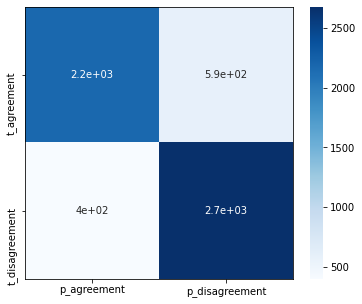

In [ ]:
y_pred = (model.predict(X_test_padded) > 0.5).astype("int32")
y_pred = y_pred[:, 0]

#classification report
classification_report_nn(y_test, y_pred)
#confusion matrix
plot_nn_confusion_matrix(model, y_test, y_pred)

## Neural Network model - split debate

Split data

In [ ]:
y = data_separated['agreement']
X= data_separated.drop(columns=['agreement', 'topic', 'polarity_score_1', 'polarity_score_2'], axis=1)
X_train_split, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Encode labels

In [ ]:
y_train= labelEncoder.transform(y_train)
y_test= labelEncoder.transform(y_test)

Prepare data and build model

In [ ]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences


#add padding to shorter sequences
max_length_pos1 = max([len(s.split()) for s in X_train_split['position1_cleaned']])
max_length_pos2 = max([len(s.split()) for s in X_train_split['position2_cleaned']])
X_train_padded_pos1 = pad_sequences(tokenizer_nn.texts_to_sequences(X_train_split['position1_cleaned']), maxlen= max_length_pos1, padding = 'post')
X_train_padded_pos2 = pad_sequences(tokenizer_nn.texts_to_sequences(X_train_split['position2_cleaned']), maxlen= max_length_pos2, padding = 'post')
X_test_padded_pos1 = pad_sequences(tokenizer_nn.texts_to_sequences(X_test['position1_cleaned']), maxlen= max_length_pos1, padding = 'post')
X_test_padded_pos2 = pad_sequences(tokenizer_nn.texts_to_sequences(X_test['position2_cleaned']), maxlen= max_length_pos2, padding = 'post')

In [ ]:
pos1_input =  keras.layers.Input(X_train_padded_pos1.shape[1])
pos1_embed = keras.layers.Embedding(input_dim= vocab_size, output_dim = 100, input_length=max_length_pos1)(pos1_input)
flatten_1 = keras.layers.Flatten()(pos1_embed)
pos2_input =  keras.layers.Input(X_train_padded_pos2.shape[1])
pos2_embed = keras.layers.Embedding(input_dim= vocab_size, output_dim = 100, input_length=max_length_pos2)(pos2_input)
flatten_2 = keras.layers.Flatten()(pos2_embed)
concatenation = keras.layers.Concatenate()([flatten_1, flatten_2])
out = keras.layers.Dense(1, activation='sigmoid')(concatenation)
model = keras.Model(inputs=[pos1_input, pos2_input], outputs=[out])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())


model.fit([X_train_padded_pos1, X_train_padded_pos2], y_train, batch_size= 128, epochs=50, verbose=0, validation_split= 0.2)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 455)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 455)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 455, 100)     2518300     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 455, 100)     2518300     input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
#training accuracy
train_loss, train_accuracy = model.evaluate([X_train_padded_pos1, X_train_padded_pos2], y_train, verbose=0)
print('Train Accuracy: %f' % (train_accuracy*100))
#test accuracy
test_loss, test_accuracy = model.evaluate([X_test_padded_pos1, X_test_padded_pos2], y_test, verbose=0)
print('Test Accuracy: %f' % (test_accuracy*100))

Train Accuracy: 97.678989
Test Accuracy: 89.246023


Evaluate results

Accuracy: 0.892460
Precision: 0.880286
Recall: 0.920650
F1 score: 0.900016
[[2389  385]
 [ 244 2831]]


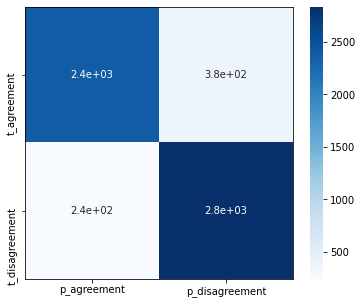

In [ ]:
y_pred = (model.predict([X_test_padded_pos1, X_test_padded_pos2]) > 0.5).astype("int32")
y_pred = y_pred[:, 0]

#classification report
classification_report_nn(y_test, y_pred)
#confusion matrix
plot_nn_confusion_matrix(model, y_test, y_pred)

# NeuralNetwork model with polarity score

## NeuralNetwork model - complete Debate

Split data

In [ ]:
y = data_merged['agreement']
X= data_merged.drop(columns=['agreement', 'topic'], axis=1)
X_train_debate_polarity, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Encode labels

In [ ]:
y_train= labelEncoder.transform(y_train)
y_test= labelEncoder.transform(y_test)

Prepare data and build model

In [ ]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences


#add padding to shorter sequences
max_length = max([len(s.split()) for s in X_train_debate['debate']])
X_train_padded = pad_sequences(tokenizer_nn.texts_to_sequences(X_train_debate['debate']), maxlen= max_length, padding = 'post')
X_test_padded = pad_sequences(tokenizer_nn.texts_to_sequences(X_test['debate']), maxlen= max_length, padding = 'post')

In [ ]:
polarity_input =  keras.layers.Input(1)
debate_input =  keras.layers.Input(X_train_padded.shape[1])
debate_embed = keras.layers.Embedding(input_dim= vocab_size, output_dim = 100, input_length=max_length)(debate_input)
flatten_debate = keras.layers.Flatten()(debate_embed)
concatenation = keras.layers.Concatenate()([flatten_debate, polarity_input])
out = keras.layers.Dense(1, activation='sigmoid')(concatenation)
model = keras.Model(inputs=[polarity_input, debate_input], outputs=[out])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())


model.fit([X_train_debate_polarity['polarity_score'], X_train_padded], y_train, batch_size= 128, epochs=50, verbose=0, validation_split= 0.2)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 555)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 555, 100)     2518300     input_4[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 55500)        0           embedding_2[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
#training accuracy
train_loss, train_accuracy = model.evaluate([X_train_debate_polarity['polarity_score'], X_train_padded], y_train, verbose=0)
print('Train Accuracy: %f' % (train_accuracy*100))
#test accuracy
test_loss, test_accuracy = model.evaluate([X_test['polarity_score'], X_test_padded], y_test, verbose=0)
print('Test Accuracy: %f' % (test_accuracy*100))

Train Accuracy: 96.336824
Test Accuracy: 82.407248


Accuracy: 0.824072
Precision: 0.819089
Recall: 0.853984
F1 score: 0.836173
[[2194  580]
 [ 449 2626]]


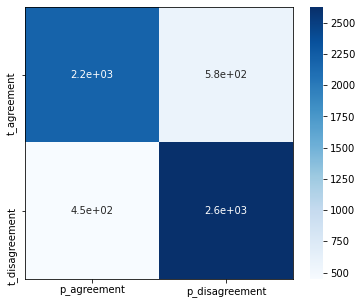

In [ ]:
y_pred = (model.predict([X_test['polarity_score'], X_test_padded]) > 0.5).astype("int32")
y_pred = y_pred[:, 0]

#classification report
classification_report_nn(y_test, y_pred)
#confusion matrix
plot_nn_confusion_matrix(model, y_test, y_pred)

## Neural Network model - split debate

Split data

In [ ]:
y = data_separated['agreement']
X= data_separated.drop(columns=['agreement', 'topic'], axis=1)
X_train_split_polarity, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Encode labels

In [ ]:
y_train= labelEncoder.transform(y_train)
y_test= labelEncoder.transform(y_test)

Prepare data and build model

In [ ]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences


#add padding to shorter sequences
max_length_pos1 = max([len(s.split()) for s in X_train_split_polarity['position1_cleaned']])
max_length_pos2 = max([len(s.split()) for s in X_train_split_polarity['position2_cleaned']])
X_train_padded_pos1 = pad_sequences(tokenizer_nn.texts_to_sequences(X_train_split_polarity['position1_cleaned']), maxlen= max_length_pos1, padding = 'post')
X_train_padded_pos2 = pad_sequences(tokenizer_nn.texts_to_sequences(X_train_split_polarity['position2_cleaned']), maxlen= max_length_pos2, padding = 'post')
X_test_padded_pos1 = pad_sequences(tokenizer_nn.texts_to_sequences(X_test['position1_cleaned']), maxlen= max_length_pos1, padding = 'post')
X_test_padded_pos2 = pad_sequences(tokenizer_nn.texts_to_sequences(X_test['position2_cleaned']), maxlen= max_length_pos2, padding = 'post')

In [ ]:
polarity1_input =  keras.layers.Input(1)
polarity2_input =  keras.layers.Input(1)
pos1_input =  keras.layers.Input(X_train_padded_pos1.shape[1])
pos1_embed = keras.layers.Embedding(input_dim= vocab_size, output_dim = 100, input_length=max_length_pos1)(pos1_input)
flatten_1 = keras.layers.Flatten()(pos1_embed)
pos2_input =  keras.layers.Input(X_train_padded_pos2.shape[1])
pos2_embed = keras.layers.Embedding(input_dim= vocab_size, output_dim = 100, input_length=max_length_pos2)(pos2_input)
flatten_2 = keras.layers.Flatten()(pos2_embed)
concatenation = keras.layers.Concatenate()([polarity1_input, polarity2_input, flatten_1, flatten_2])
out = keras.layers.Dense(1, activation='sigmoid')(concatenation)
model = keras.Model(inputs=[polarity1_input, polarity2_input, pos1_input, pos2_input], outputs=[out])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

model.fit([X_train_split_polarity['polarity_score_1'], X_train_split_polarity['polarity_score_2'],
                     X_train_padded_pos1, X_train_padded_pos2], y_train, batch_size= 128, 
                    epochs=50, verbose=0, validation_split= 0.2)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 455)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 455)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 455, 100)     2518300     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 455, 100)     2518300     input_8[0][0]                    
____________________________________________________________________________________________

In [ ]:
#training accuracy
train_loss, train_accuracy = model.evaluate([X_train_split_polarity['polarity_score_1'], X_train_split_polarity['polarity_score_2'], 
                                             X_train_padded_pos1, X_train_padded_pos2], y_train, verbose=0)
print('Train Accuracy: %f' % (train_accuracy*100))
#test accuracy
test_loss, test_accuracy = model.evaluate([X_test['polarity_score_1'], X_test['polarity_score_2'],
                                           X_test_padded_pos1, X_test_padded_pos2], y_test, verbose=0)
print('Test Accuracy: %f' % (test_accuracy*100))

Train Accuracy: 97.734559
Test Accuracy: 89.126348


Evaluate results

Accuracy: 0.891263
Precision: 0.873278
Recall: 0.927805
F1 score: 0.899716
[[2360  414]
 [ 222 2853]]


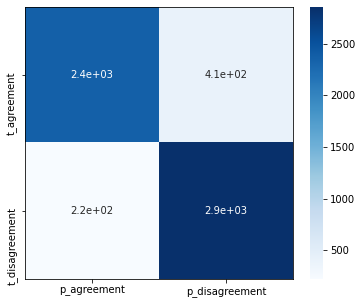

In [ ]:
y_pred = (model.predict([X_test['polarity_score_1'], X_test['polarity_score_2'], X_test_padded_pos1, X_test_padded_pos2]) > 0.5).astype("int32")
y_pred = y_pred[:, 0]

#classification report
classification_report_nn(y_test, y_pred)
#confusion matrix
plot_nn_confusion_matrix(model, y_test, y_pred)